In [2]:
import os
import sys

import ast
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import tensorflow as tf
import time
import xgboost as xgb

from ahrs.filters import Madgwick, Mahony
from pprint import pprint
from scipy import signal
from scipy.signal import find_peaks
from sklearn.cross_decomposition import CCA, PLSRegression
from sklearn.metrics import (accuracy_score, classification_report, 
                             confusion_matrix, f1_score, mean_squared_error, 
                             precision_score, recall_score)
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import OneClassSVM
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import (BatchNormalization, Conv1D, Dense, Dropout, 
                                     Flatten, LSTM, MaxPooling1D, RepeatVector, 
                                     Reshape, TimeDistributed, UpSampling1D)
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam, Adamax, RMSprop, SGD
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.utils import Sequence
import tensorflow.keras.backend as K

2024-12-09 01:29:11.680611: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-09 01:29:12.050322: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-09 01:29:12.050381: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-09 01:29:12.099235: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-09 01:29:12.210553: I tensorflow/core/platform/cpu_feature_guar

In [5]:
# Check for TensorFlow GPU access.
print(f"TensorFlow has access to the following devices:\n{tf.config.list_physical_devices()}")

# See TensorFlow version.
print(f"TensorFlow version: {tf.__version__}")

# If you are on ARM-based MacOS this will return "command not found".
# In that case, you need to consider the output of above statements. 
!nvidia-smi -L
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)
  
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

# This is useful on Google Colab to check if high-RAM is selected.
if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

TensorFlow has access to the following devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version: 2.15.0
GPU 0: NVIDIA RTX A6000 (UUID: GPU-76748847-01f8-4453-46b2-72ba4a516e70)
Sun Dec  8 12:49:39 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.29.02              Driver Version: 545.29.02    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A6000               Off | 00000000:65:0

**Run below if it crashes due to RAM shortage.**

**For First Use Case Only**

In [3]:
# Save as .npy files
# np.save('/tf/variables/nicla_nor.npy', nicla_nor)
# np.save('/tf/variables/nicla_anol.npy', nicla_anol)
# np.save('/tf/variables/nicla_labels_anol.npy', nicla_labels_anol)

# Load the arrays: normal, and anomalous data, and labels.
nicla_nor = np.load('/tf/variables/nicla_nor.npy')
nicla_anol = np.load('/tf/variables/nicla_anol.npy')
nicla_labels_anol = np.load('/tf/variables/nicla_labels_anol.npy')

# Calculate the indices for the split
total_length = nicla_nor.shape[0]
train_end = int(total_length * 0.6)
val_end = train_end + int(total_length * 0.2)

# Split the data
train_data = nicla_nor[:train_end]
validation_data = nicla_nor[train_end:val_end]
test_data = nicla_nor[val_end:]

# Scaling
scaler_X = StandardScaler().fit(train_data)
X_train, X_val, X_test, X_anol = [pd.DataFrame(scaler_X.transform(data), 
                                  columns=["AccX", "AccY", "AccZ", "GyroX", "GyroY", "GyroZ", "MagX", "MagY", "MagZ"]) 
                                  for data in [train_data, validation_data, test_data, nicla_anol]]

def create_windows(data, window_size=755, sliding_number=1):
    num_windows = (data.shape[0] - window_size) // sliding_number + 1
    shape = (num_windows, window_size, data.shape[-1])
    strides = (data.strides[0] * sliding_number, data.strides[0], data.strides[1])
    return np.lib.stride_tricks.as_strided(data, shape=shape, strides=strides)


# Set input and target data using the updated window creation function
X_train_windows = create_windows(X_train.to_numpy())
X_train_target = create_windows(train_data)
X_val_windows = create_windows(X_val.to_numpy())
X_val_target = create_windows(validation_data)
X_test_windows = create_windows(X_test.to_numpy())
X_test_target = create_windows(test_data)
X_anol_windows = create_windows(X_anol.to_numpy())
nicla_anol_windows = create_windows(nicla_anol)

# USE CASE 1

## Dataset Matching/Labeling

We have **2 data sources** that we need to match:
1. Built-in parameters data that contain the anomaly labels.
2. Nicla Sense ME data where we apply the anomaly detection algorithms.

We should correctly match the anomalous labels we got from the 1st data to 2nd.

#### The reasons for the mismatch in data sources:
1. Even thought we set both freqs to 20Hz with the given available libraries, we see that the freqs differ around **18Hz to 22Hz**.
2. The Nicla stopped **after the industrial robotic arm** (estimatedly few minutes.)
3. The Nicla **started earlier** than the industrial robotic arm.

If the freq was exactly **20Hz**, we would had **1728000** data points after 24 hours.

Now we match the data sources based on the **location of the first anomalous point**.

First we check Nicla Dataset.

In [3]:
# Generate Nicla dataframe, perform initial checks.
# If local the path:
nicla_path = "/tf/datasets/nicla.csv"

# We skip first 6 rows due to faulty format/data.
nicla = pd.read_csv(nicla_path, on_bad_lines='warn', skiprows=6, 
                    names=["AccX", "AccY", "AccZ", "GyroX", "GyroY", "GyroZ", "MagX", "MagY", "MagZ"])

# Check if there are any empty/Nan variables. 
if nicla.isnull().values.any():
    raise ValueError("Nan variable is present.")

# Explore the dataframe.
print(nicla.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1751682 entries, 0 to 1751681
Data columns (total 9 columns):
 #   Column  Dtype  
---  ------  -----  
 0   AccX    float64
 1   AccY    float64
 2   AccZ    float64
 3   GyroX   float64
 4   GyroY   float64
 5   GyroZ   float64
 6   MagX    float64
 7   MagY    float64
 8   MagZ    float64
dtypes: float64(9)
memory usage: 120.3 MB
None


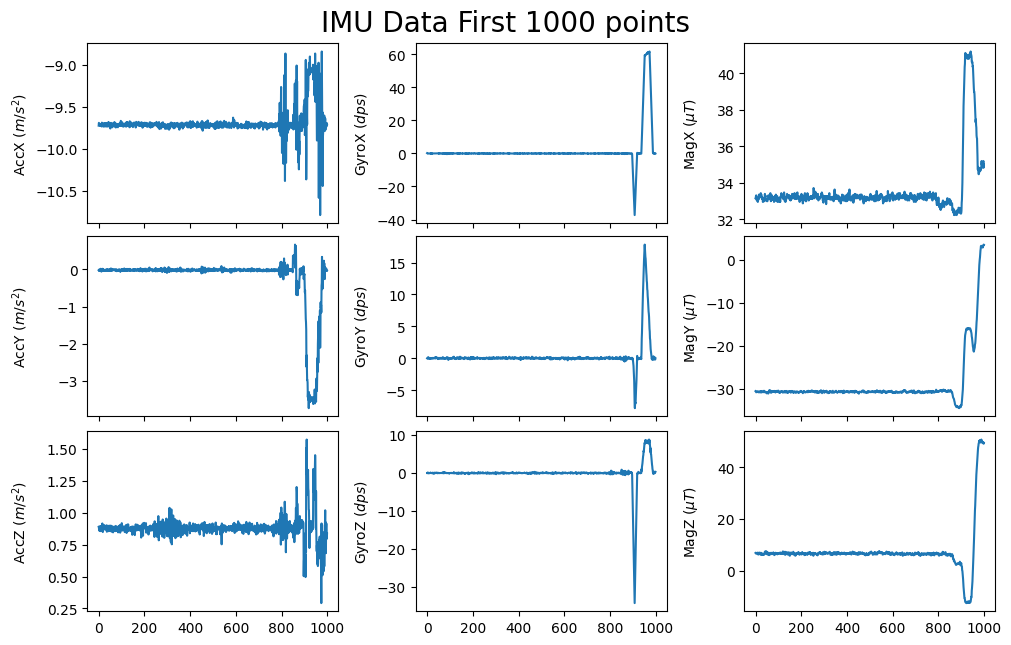

In [4]:
# Visualize the first 1000 point
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, sharex = True, figsize=(10, 6), constrained_layout=True)

start_index = 0
end_index = 1000

ax1.plot(nicla.index[start_index:end_index], nicla['AccX'][start_index:end_index])
ax1.set_ylabel(r'AccX $(m/s^2)$')

ax2.plot(nicla.index[start_index:end_index], nicla['GyroX'][start_index:end_index])
ax2.set_ylabel(r'GyroX $(dps)$')

ax3.plot(nicla.index[start_index:end_index], nicla['MagX'][start_index:end_index])
ax3.set_ylabel(r'MagX (${\mu}T$)')

ax4.plot(nicla.index[start_index:end_index], nicla['AccY'][start_index:end_index])
ax4.set_ylabel(r'AccY $(m/s^2)$')

ax5.plot(nicla.index[start_index:end_index], nicla['GyroY'][start_index:end_index])
ax5.set_ylabel(r'GyroY $(dps)$')

ax6.plot(nicla.index[start_index:end_index], nicla['MagY'][start_index:end_index])
ax6.set_ylabel(r'MagY (${\mu}T$)')

ax7.plot(nicla.index[start_index:end_index], nicla['AccZ'][start_index:end_index])
ax7.set_ylabel(r'AccZ $(m/s^2)$')

ax8.plot(nicla.index[start_index:end_index], nicla['GyroZ'][start_index:end_index])
ax8.set_ylabel(r'GyroZ $(dps)$')

ax9.plot(nicla.index[start_index:end_index], nicla['MagZ'][start_index:end_index])
ax9.set_ylabel(r'MagZ (${\mu}T$)')

fig.align_labels()
plt.suptitle("IMU Data First 1000 points", x = 0.5, y = 1.05, fontsize = 20)
fig.savefig("/tf/figures/first1000.pdf", format='pdf', bbox_inches='tight')
plt.show()

We see that the Nicla is idle for some time. We now find the **exact starting point**.

In [5]:
# We see that Gyro. noise occurs at range of 0 < x < 1, so we find the first point where x >= 1
index = np.argmax(nicla['GyroX'][:1000].diff().abs() >= 1)
print(f"The movement starts at {index}.")

The movement starts at 898.


As the movement starts at (roughly) 898th data point we can **remove the first 897 data points.**

In [6]:
nicla_dropped = nicla.iloc[897:].reset_index(drop=True)

In [7]:
%%time
# Generate df from dataset that contains labels/built-in parameters.
# Path for local PC.
right_arm_csv_path = "/tf/datasets/right_arm.csv"

# Generate the dataframe.
right_arm = pd.read_csv(right_arm_csv_path, on_bad_lines='warn')

# Reset Timestamp to 0.
right_arm["Timestamp"] = right_arm["Timestamp"] - right_arm["Timestamp"][0]

CPU times: user 20.1 s, sys: 1.3 s, total: 21.4 s
Wall time: 21.8 s


We compare the lengths of the data.

In [8]:
print(f"The length of the right arm data is {len(right_arm)}")
print(f"The length of the nicla data is {len(nicla_dropped)}")

The length of the right arm data is 1762650
The length of the nicla data is 1750785


As we see the lengths **do not match**. The **final point** of built-in dataset is an **anomaly**, that is how we can locate the **exact end of the 24 hour period.**

Now, we find the final **1** which corresponds to an anomaly.

In [9]:
# Find the final 1.
df_labels = right_arm["Anomaly State"]
index_list = np.where(df_labels == 1)
index_of_last_one = index_list[0][-1]
print(f"The final 1 is located at: {index_of_last_one}")

The final 1 is located at: 1728006


We run the test for just a bit more than 24 hours, while setting operation to normal after 24 hours.

The final 1 is at 1728006, well, this makes sense, because the **24 hour data at 20Hz means 1728000 data points**. We only have **6 extra** data points in this case.

We now **match the datasets**.

Now we try to find corresponding points at Nicla.

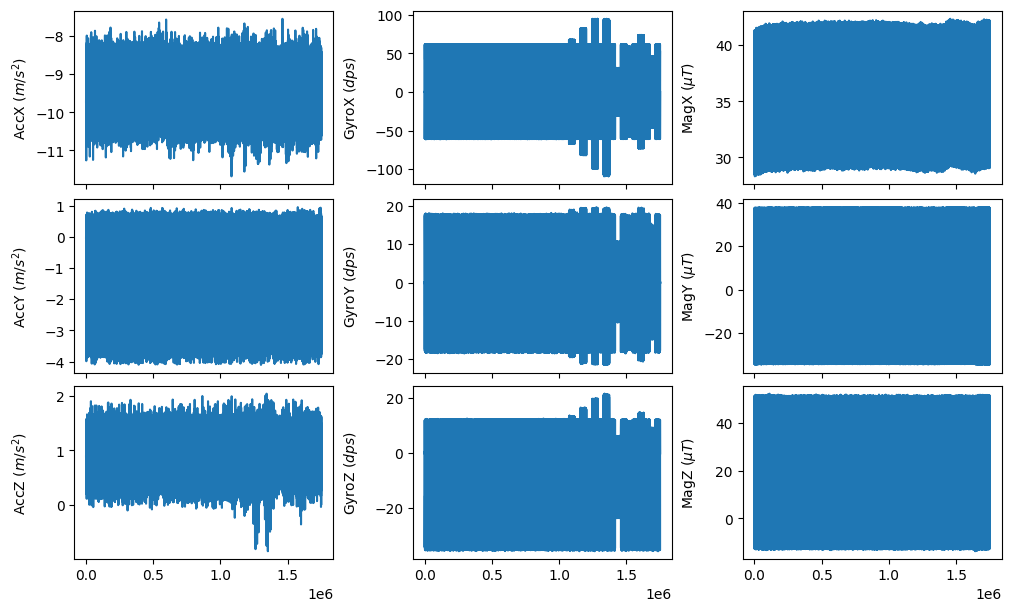

In [10]:
# Visualize the first 1000 point
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, sharex = True, figsize=(10, 6), constrained_layout=True)

ax1.plot(nicla.index, nicla['AccX'])
ax1.set_ylabel(r'AccX $(m/s^2)$')

ax2.plot(nicla.index, nicla['GyroX'])
ax2.set_ylabel(r'GyroX $(dps)$')

ax3.plot(nicla.index, nicla['MagX'])
ax3.set_ylabel(r'MagX (${\mu}T$)')

ax4.plot(nicla.index, nicla['AccY'])
ax4.set_ylabel(r'AccY $(m/s^2)$')

ax5.plot(nicla.index, nicla['GyroY'])
ax5.set_ylabel(r'GyroY $(dps)$')

ax6.plot(nicla.index, nicla['MagY'])
ax6.set_ylabel(r'MagY (${\mu}T$)')

ax7.plot(nicla.index, nicla['AccZ'])
ax7.set_ylabel(r'AccZ $(m/s^2)$')

ax8.plot(nicla.index, nicla['GyroZ'])
ax8.set_ylabel(r'GyroZ $(dps)$')

ax9.plot(nicla.index, nicla['MagZ'])
ax9.set_ylabel(r'MagZ (${\mu}T$)')

fig.align_labels()
fig.savefig("tf/figures/niclaData.pdf", dpi=300, bbox_inches='tight', transparent=True)
plt.show()

The anomalies are most obvious on **GyroX**, thus we utilize that feature for matching the datasets. 

We also compare the anomaly points seen in **arm** and the anomaly points seen in **Nicla**.

Now we will spot the first anomalous point on Nicla Data.

In [11]:
# Remove the rest of the data.
right_arm = right_arm[0:1728000]
# Check the anomaly labels.
df_anol = right_arm["Anomaly State"]
# Find the first anomaly point.
idx_f = (df_anol == 1.0).idxmax()

# Get the GyroX feature.
df_gyroX = nicla_dropped["GyroX"]
# Convert into numpy array.
gyroX = df_gyroX.to_numpy()
# Get first 1 m data points that we know its normal.
gyroX_1m = gyroX[0:1000000]
gyroX_1m_min = np.min(gyroX_1m)
gyroX_1m_max = np.max(gyroX_1m)

# Find the data either bigger than max or lower then min.
greater_indices = np.argwhere(gyroX > gyroX_1m_max)
lesser_indices = np.argwhere(gyroX < gyroX_1m_min)

first_greater = greater_indices[0][0]
first_lesser = lesser_indices[0][0]
last_greater = greater_indices[-1][0]
last_lesser = lesser_indices[-1][0]

print(f"The first greater than max at {first_greater}, the first lesser than min at {first_lesser}.")
print(f"The first anomaly point in Arm data seen at {idx_f}.")
print(f"The final anomaly point in Arm data seen at {index_of_last_one}.")
print(f"The final anomaly point in Nicla-Gyro data seen at {last_lesser}.")

The first greater than max at 1072794, the first lesser than min at 1072917.
The first anomaly point in Arm data seen at 1080004.
The final anomaly point in Arm data seen at 1728006.
The final anomaly point in Nicla-Gyro data seen at 1629872.


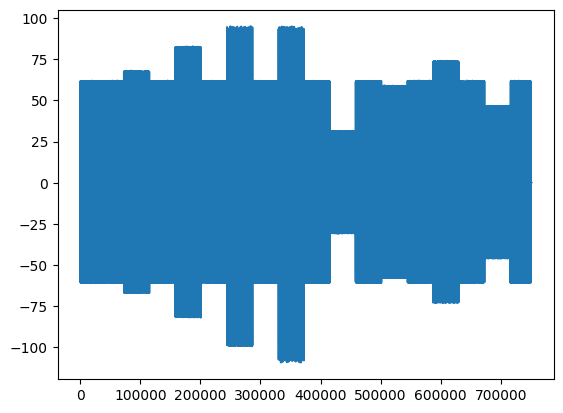

In [12]:
# Remove the first 1m points as we know they are normal.
gyroX_a_1m = gyroX[1000000:]
plt.plot(gyroX_a_1m)
plt.show()

Before matching labels, we need to filter the noise as the **data length will change**.

We apply **moving median filter** with fixed window size.

Then, we **manually** detect (error rate is < 1%) starting and ending points of anomaly event manually from the above graphs.
The anomalies are seen at below intervals (after 1m points):
1. **10% increase** at joint velocity between **72450 - 115125**.
1. **35% increase** at joint velocity between **158150 - 201100**.
1. **65% increase** at joint velocity between **244100 - 286875**.
1. **100% increase** at joint velocity between **329900 - 372650**.
1. **50% decrease** at joint velocity between **415700 - 458415**.
1. **5% decrease** at joint velocity between **501500 - 544725**.
1. **20% increase** at joint velocity between **587750 - 630150**.
1. **25% decrease** at joint velocity between **673200 - 716456 (the final anomaly)**.

We see that first anomaly is seen at 1072450 while the expected point is 1080000 if the data rate would be 20Hz.

1072450 corresponds to a data rate at 19.86Hz which explains the difference. The last point being at 1716456 also confirms this.

While one solution would be shifting the data based on this information, for the sake of accuracy we manually label the data.

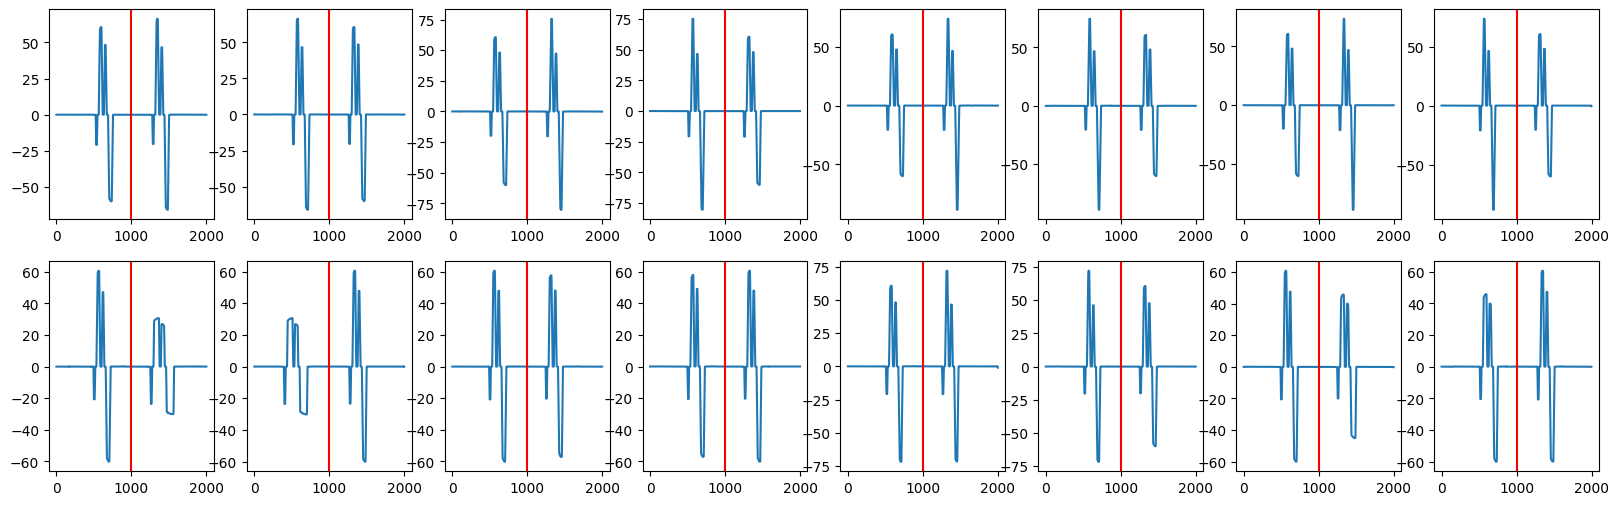

In [13]:
# Set window size for moving median.
f_window_size = 20

# Apply moving median and convert back to numpy array for faster ops.
nicla_filtered = nicla_dropped.rolling(f_window_size).median().dropna().to_numpy()

# Manually find the anomalous run.
fig, ((ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8), 
      (ax9, ax10, ax11, ax12, ax13, ax14, ax15, ax16)) = plt.subplots(nrows=2, ncols=8, figsize=(20, 6))
# First jump seen at around 1072450.
ax1.plot(nicla_filtered[1071450:1073450, 3])
ax1.axvline(x=1000, color='red')
# First down seen at around 1115125.
ax2.plot(nicla_filtered[1114125:1116125, 3])
ax2.axvline(x=1000, color='red')
# Second jump seen at around 1158150.
ax3.plot(nicla_filtered[1157150:1159150, 3])
ax3.axvline(x=1000, color='red')
# Second down seen at around 1201100.
ax4.plot(nicla_filtered[1200100:1202100, 3])
ax4.axvline(x=1000, color='red')
# Third up seen at around 1244100.
ax5.plot(nicla_filtered[1243100:1245100, 3])
ax5.axvline(x=1000, color='red')
# Third down seen at around 1286875.
ax6.plot(nicla_filtered[1285875:1287875, 3])
ax6.axvline(x=1000, color='red')
# Fourth up seen at around 1329900.
ax7.plot(nicla_filtered[1328900:1330900, 3])
ax7.axvline(x=1000, color='red')
# Fourth down seen at around 1372650.
ax8.plot(nicla_filtered[1371675:1373675, 3])
ax8.axvline(x=1000, color='red')
# Fifth down seen at around 1415700.
ax9.plot(nicla_filtered[1414700:1416700, 3])
ax9.axvline(x=1000, color='red')
# Fifth up seen at around 1458415.
ax10.plot(nicla_filtered[1457415:1459415, 3])
ax10.axvline(x=1000, color='red')
# Sixth down seen at around 1501500.
ax11.plot(nicla_filtered[1500475:1502475, 3])
ax11.axvline(x=1000, color='red')
# Sixth up seen at around 1544725.
ax12.plot(nicla_filtered[1543725:1545725, 3])
ax12.axvline(x=1000, color='red')
# Seventh up seen at around 1587750.
ax13.plot(nicla_filtered[1586750:1588750, 3])
ax13.axvline(x=1000, color='red')
# Seventh down seen at around 1630150.
ax14.plot(nicla_filtered[1629150:1631150, 3])
ax14.axvline(x=1000, color='red')
# Eighth down seen at around 1673200.
ax15.plot(nicla_filtered[1672200:1674200, 3])
ax15.axvline(x=1000, color='red')
# Eighth up seen at around 1716450
ax16.plot(nicla_filtered[1715450:1717450, 3])
ax16.axvline(x=1000, color='red')
fig.savefig("tf/figures/anomalous_transitions.pdf", dpi=300, bbox_inches='tight', transparent=True)
plt.show()

We create labels based on our findings.

The length of the Nicla Data 1750766


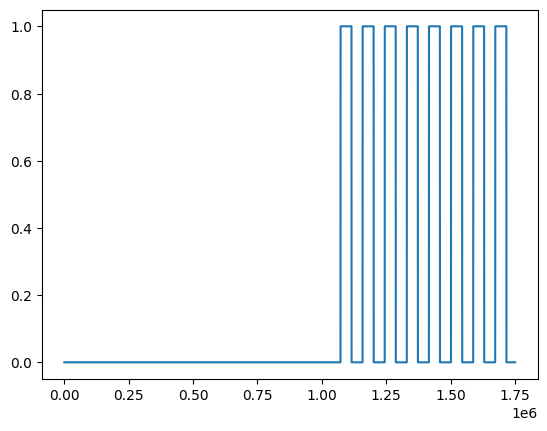

In [14]:
# Create a numpy array that will hold anomaly labels. 
len_nicla = len(nicla_filtered)
print(f"The length of the Nicla Data {len_nicla}")
nicla_labels = np.zeros((len_nicla, 1))
# Set anomaly points to ones.
nicla_labels[1072450:1115125] = 1 # 10% increase
nicla_labels[1158150:1201100] = 1 # 35% increase
nicla_labels[1244100:1286875] = 1 # 65% increase
nicla_labels[1329900:1372650] = 1 # 100% increase
nicla_labels[1415700:1458415] = 1 # 50% decrease
nicla_labels[1501500:1544725] = 1 # 5% decrease
nicla_labels[1587750:1630150] = 1 # 20% increase
nicla_labels[1673200:1716450] = 1 # 25% decrease
# Plot the labels for a visual check.
plt.plot(nicla_labels)
plt.show()

Now, we have our labels, so we split data into non-anomalous and anomalous.

Just to clarify, as you can see from the labels, **the anomalous run has both non-anomalous and anomalous operations.**

We know split our data based on this. We already need labels for the anomalous data where we apply anomaly detection.

In [15]:
# Split the non-anomalous and anomalous data.
nicla_nor = nicla_filtered[:1072450] # 1072450 -> first anomalous point
nicla_anol = nicla_filtered[1072450:]

# We only need labels for anomalous run.
nicla_labels_anol = nicla_labels[1072450:]

print(f"Length of non-anomalous run {len(nicla_nor)}")
print(f"Length of anomalous run {len(nicla_anol)}")
print(f"Length of labels {len(nicla_labels_anol)}")

Length of non-anomalous run 1072450
Length of anomalous run 678316
Length of labels 678316


## Correlation Analysis

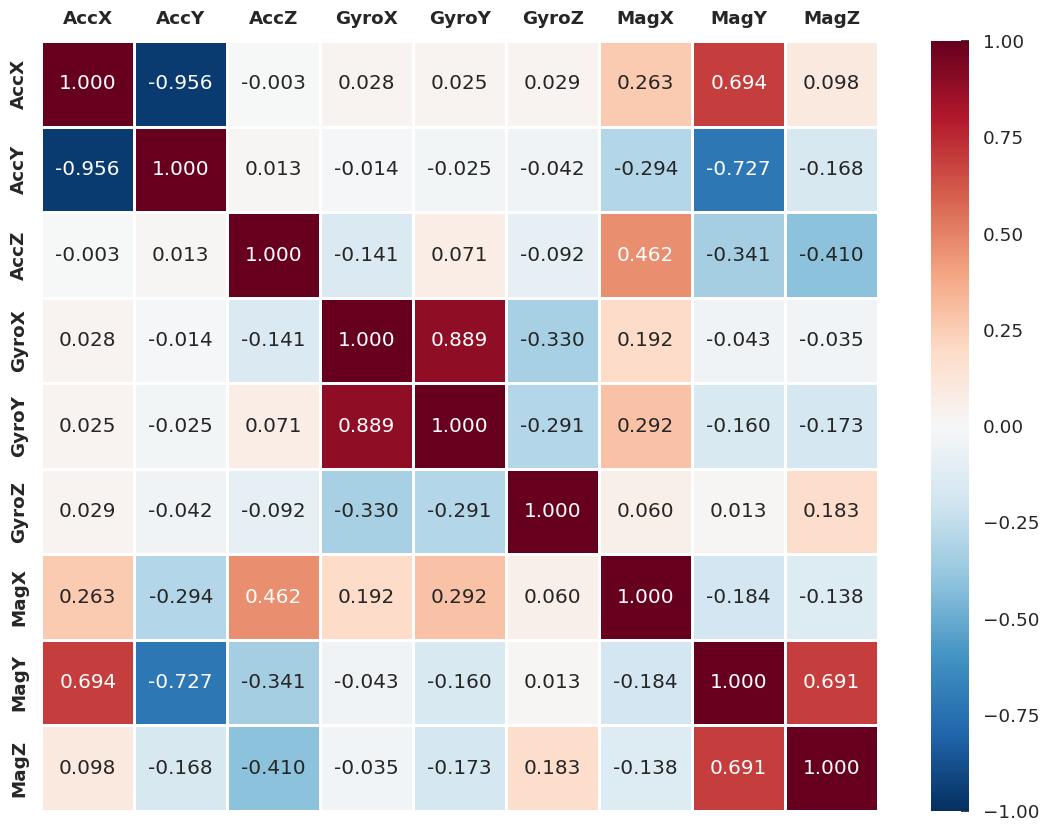

In [16]:
def cal_corr(arr):
    """
    Calculates the pearson correlation coefficient of given numpy arrays.
    Args:
        arr (list): A list containing numpy arrays.
    Returns:
        numpy_ndarray: A matrix that contains correlation coefficients.
    """
    corr_matrix = np.corrcoef(arr)
    return corr_matrix

# Split the features to single arrays.
np_accX = nicla_nor[:, 0]
np_accY = nicla_nor[:, 1]
np_accZ = nicla_nor[:, 2]
np_gyroX = nicla_nor[:, 3]
np_gyroY = nicla_nor[:, 4]
np_gyroZ = nicla_nor[:, 5]
np_magX = nicla_nor[:, 6]
np_magY = nicla_nor[:, 7]
np_magZ = nicla_nor[:, 8]

# Combine the features per modality.
np_acc = np.stack([np_accX, np_accY, np_accZ], axis=1)
np_gyro = np.stack([np_gyroX, np_gyroY, np_gyroZ], axis=1)
np_mag = np.stack([np_magX, np_magY, np_magZ], axis=1)

# Set tick labels.
tick_labels = ["AccX", "AccY", "AccZ",
               "GyroX", "GyroY", "GyroZ",
               "MagX", "MagY", "MagZ"]
# Check how input features correlate with each other.
corr_mat = cal_corr([np_accX, np_accY, np_accZ, 
                     np_gyroX, np_gyroY, np_gyroZ, 
                     np_magX, np_magY, np_magZ])

plt.figure(figsize=(13.5, 10))
sns.set(font_scale=1.2)
ax = sns.heatmap(corr_mat, cmap='RdBu_r', annot=True, linewidths=1, vmin=-1, 
                 square=False, cbar=True, fmt='.3f', annot_kws={"fontweight": "light"},
                 xticklabels=tick_labels, yticklabels=tick_labels)

# Get the colorbar object.
cbar = ax.collections[0].colorbar
# Set the location of the colorbar ticks to the right.
cbar.ax.yaxis.set_tick_params(pad=10, direction='in', labelright=True, labelleft=False)

ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False, labeltop=True)
ax.set_xticklabels(ax.get_xticklabels(), fontweight='bold')
ax.set_yticklabels(ax.get_yticklabels(), fontweight='bold')
plt.savefig('/tf/figures/corr_heatmap_IMU.pdf', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

Based on the above matrix, the highest correlated features in order are:
1. AccX and AccY with pcc = **-0.956** 
2. GyroX and GyroY with pcc = **0.889**
3. AccY and MagY with pcc = **-0.727**  

When pcc > 0.7 or pcc < -0.7, we accept that as a strong correlation. In this case, features of GyroX and GyroY, AccY and MagY seems to highly correlate.

Even though, the **single features might not correlate**, sets of features can. Now we check if accelerometer, gyroscrope and magnetometer data correlate with each other.

To find how sets of features correlate we apply **canonical-correlation analysis (CCA)**.

In [17]:
# Standardize with zero mean and unit variance / only normal data.
scaler = StandardScaler() 
acc_sc = scaler.fit_transform(np_acc)
gyro_sc = scaler.fit_transform(np_gyro) 
mag_sc = scaler.fit_transform(np_mag) 

# Apply CCA. 
n_comp = 3
cca_1 = CCA(scale=False, n_components=n_comp)
cca_2 = CCA(scale=False, n_components=n_comp)
cca_3 = CCA(scale=False, n_components=n_comp)
cca_1.fit(acc_sc, gyro_sc)
cca_2.fit(acc_sc, mag_sc)
cca_3.fit(gyro_sc, mag_sc)
acc_c_1, gyro_c_1 = cca_1.transform(acc_sc, gyro_sc)
acc_c_2, mag_c_1 = cca_2.transform(acc_sc, mag_sc)
gyro_c_2, mag_c_2 = cca_3.transform(gyro_sc, mag_sc)

# Canonical variate correlations.
acc_gyro_corr = [np.corrcoef(acc_c_1[:, i], gyro_c_1[:, i])[1][0] for i in range(n_comp)]
acc_mag_corr = [np.corrcoef(acc_c_2[:, i], mag_c_1[:, i])[1][0] for i in range(n_comp)]
gyro_mag_corr = [np.corrcoef(gyro_c_2[:, i], mag_c_2[:, i])[1][0] for i in range(n_comp)]

print(f"Acc-Gyro cvc: {acc_gyro_corr}")
print(f"Acc-Mag cvc: {acc_mag_corr}")
print(f"Gyro-Mag cvc: {gyro_mag_corr}")

Acc-Gyro cvc: [0.4856142661636789, 0.07371715418811832, 0.02834430994559355]
Acc-Mag cvc: [0.9696214582282653, 0.5802248892976103, 0.27068518080662746]
Gyro-Mag cvc: [0.4117384040755246, 0.30430201562288056, 0.07603021337917858]


This confirms our previous per feature correlation analysis.

In this case, the **accelerometer and magnetometer** data highly correlate.

In [18]:
# We know our data at roughly 19.86Hz.
s_period = 1 / 19.86
mad_fil = Madgwick(sample_period=s_period)
mah_fil = Mahony(sample_period=s_period)
# Set the identity quaternion, so we accept as zero rotation.
q = np.empty((len(np_acc), 4))
q_mahony = np.empty((len(np_acc), 4))
q[0] = np.array([1.0, 0.0, 0.0, 0.0])
q_mahony[0] = np.array([1.0, 0.0, 0.0, 0.0])
# Calculate quaternions.
for i in range(1, len(np_acc)):
    q[i] = mad_fil.updateMARG(q[i-1], acc=np_acc[i-1], gyr=np_gyro[i-1], mag=np_mag[i-1])
    q_mahony[i] = mah_fil.updateMARG(q_mahony[i-1], acc=np_acc[i-1], gyr=np_gyro[i-1], mag=np_mag[i-1])

[[ 1.          0.01543437 -0.003104    0.31948101]
 [ 0.01543437  1.         -0.2838297  -0.02259608]
 [-0.003104   -0.2838297   1.          0.01661727]
 [ 0.31948101 -0.02259608  0.01661727  1.        ]]
[[ 1.          0.46047982  0.93099665 -0.61002263]
 [ 0.46047982  1.          0.17652929 -0.83840541]
 [ 0.93099665  0.17652929  1.         -0.4621761 ]
 [-0.61002263 -0.83840541 -0.4621761   1.        ]]


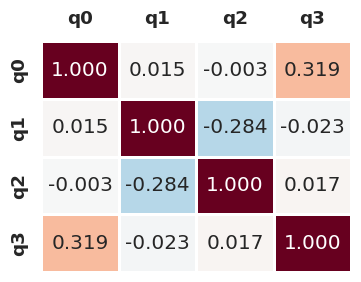

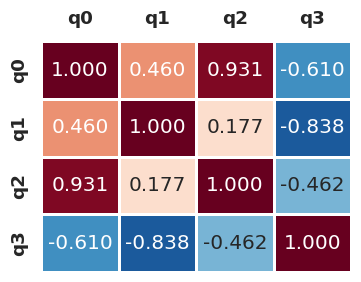

In [19]:
# Split the features to single arrays.
q_0 = q[:, 0]
q_1 = q[:, 1]
q_2 = q[:, 2]
q_3 = q[:, 3]
q_mahony_0 = q_mahony[:, 0]
q_mahony_1 = q_mahony[:, 1]
q_mahony_2 = q_mahony[:, 2]
q_mahony_3 = q_mahony[:, 3]

# Check how input features correlate with each other.
corr_mad = cal_corr([q_0, q_1, q_2, q_3])
corr_mah = cal_corr([q_mahony_0, q_mahony_1, q_mahony_2, q_mahony_3])
print(corr_mad)
print(corr_mah)

# Visualize the correlation map of Madgwick.
q_tick_labels = ["q0", "q1", "q2", "q3"]
plt.figure(figsize=(4, 3))
sns.set(font_scale=1.2)
ax = sns.heatmap(corr_mad, cmap='RdBu_r', annot=True, linewidths=1, vmin=-1, 
                 square=False, cbar=False, fmt='.3f', annot_kws={"fontweight": "light"},
                 xticklabels=q_tick_labels, yticklabels=q_tick_labels)
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False, labeltop=True)
ax.set_xticklabels(ax.get_xticklabels(), fontweight='bold')
ax.set_yticklabels(ax.get_yticklabels(), fontweight='bold')
plt.savefig('/tf/figures/corr_heatmap_madgwick.pdf', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

# Visualize the correlation map of Mahony.
plt.figure(figsize=(4, 3))
sns.set(font_scale=1.2)
ax = sns.heatmap(corr_mah, cmap='RdBu_r', annot=True, linewidths=1, vmin=-1, 
                 square=False, cbar=False, fmt='.3f', annot_kws={"fontweight": "light"},
                 xticklabels=q_tick_labels, yticklabels=q_tick_labels)
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False, labeltop=True)
ax.set_xticklabels(ax.get_xticklabels(), fontweight='bold')
ax.set_yticklabels(ax.get_yticklabels(), fontweight='bold')
plt.savefig('/tf/figures/corr_heatmap_mahony.pdf', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

The quaternions of Madgwick do not highly correlate.

The highly correlated quaternion features of **Mahony** filtering are:
1. **q0** and **q2** with pcc = **0.931**
2. **q1** and **q3** with pcc = **-0.838**

The quaternions generated via Mahony seems to correlate more than Madgwick generated ones.

This makes **Madgwick** more suitable for the regression analysis.

## Null Model (Always Yes)
1 means anomaly, 0 means normal.

In [21]:
# Count the number of actual anomalies (1s)
num_anomalies = np.sum(nicla_labels_anol)

# Calculate the total number of instances
total_instances = nicla_labels_anol.size

# Recall is 1.0 because we are predicting all instances as anomalies
recall = 1.0

# Precision is the number of true positives divided by the total number of predicted positives
# Here, predicted positives are equal to the total number of instances
precision = num_anomalies / total_instances

# F1 Score is 2 times the product of precision and recall divided by the sum of precision and recall
f1_score_null = 2 * (precision * recall) / (precision + recall)

print(f"Accuracy when predicting all as anomalies: {precision}")
print(f"Recall when predicting all as anomalies: {recall}")
print(f"Precision when predicting all as anomalies: {precision}")
print(f"F1 Score when predicting all as anomalies: {f1_score_null}")

# True Positives (TP) is equal to the actual anomalies
tp = num_anomalies

# False Positives (FP) is the total number of normal instances (0s)
fp = total_instances - num_anomalies

# FPR is the ratio of FP to the sum of FP and TN
# Since TN is 0 in this case (as all instances are predicted as positive), FPR = FP / (FP + TN) = FP / FP = 1
fpr = fp / (fp + 0)

print(f"False Positive Rate when predicting all as anomalies: {fpr}")

Accuracy when predicting all as anomalies: 0.5052807246180246
Recall when predicting all as anomalies: 1.0
Precision when predicting all as anomalies: 0.5052807246180246
F1 Score when predicting all as anomalies: 0.6713441770089006
False Positive Rate when predicting all as anomalies: 1.0


## One-Class SVM

In [4]:
# Define a function to create a dataset with rolling windows
def create_dataset(data, window_size, step=1):
    X, y = [], []
    for i in range(0, len(data) - window_size - step + 1, step):
        X.append(data[i:(i + window_size)])  # Window of observations
        y.append(data[i + window_size])      # Next observation as target
    return np.array(X), np.array(y)

# Load the arrays: normal, and anomalous data, and labels.
nicla_nor = np.load('/tf/variables/nicla_nor.npy')
nicla_anol = np.load('/tf/variables/nicla_anol.npy')
nicla_labels_anol = np.load('/tf/variables/nicla_labels_anol.npy')

# Reduce the size of normal data to 10%
total_length = int(nicla_nor.shape[0] * 0.1)
train_end = int(total_length * 0.6)
val_end = train_end + int(total_length * 0.2)

# Split the reduced data (10% of original)
reduced_nor_data = nicla_nor[:total_length]
train_data = reduced_nor_data[:train_end]
validation_data = reduced_nor_data[train_end:val_end]
test_data = reduced_nor_data[val_end:]

# Scaling
scaler_X = StandardScaler().fit(train_data)
X_train = scaler_X.transform(train_data)
X_val = scaler_X.transform(validation_data)
X_test = scaler_X.transform(test_data)
X_anol = scaler_X.transform(nicla_anol)

In [8]:
# Define One-Class SVM model
oc_svm = OneClassSVM(kernel='rbf', gamma='auto')

# Flatten the data if required (One-Class SVM expects 2D input)
X_train_flattened = X_train.reshape(X_train.shape[0], -1)

# Fit the model
oc_svm.fit(X_train_flattened)

# Flatten the datasets for prediction
# X_val_flattened = X_val.reshape(X_val.shape[0], -1)
# X_test_flattened = X_test.reshape(X_test.shape[0], -1)
X_anol_flattened = X_anol.reshape(X_anol.shape[0], -1)

# Predict
# val_pred = oc_svm.predict(X_val_flattened)
# test_pred = oc_svm.predict(X_test_flattened)

# Start the timer
start_time = time.time()

# Predict on anomalous data
anol_pred = oc_svm.predict(X_anol_flattened)

# Stop the timer
end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time

print(f"Time taken for predicting on anomalous data: {elapsed_time} seconds")

Time taken for predicting on anomalous data: 605.9545867443085 seconds


In [9]:
# Total number of predictions
num_predictions = X_anol_flattened.shape[0]

# Calculate average inference latency (time per prediction)
average_inference_latency = elapsed_time / num_predictions
print(f"Average inference latency per prediction: {average_inference_latency} seconds")
anol_pred = (anol_pred == -1).astype(int)

def calculate_performance_metrics(y_true, y_pred):
    # Compute confusion matrix
    TN, FP, FN, TP = confusion_matrix(y_true, y_pred).ravel()

    # Calculate metrics
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP) if (TP + FP) != 0 else 0
    recall = TP / (TP + FN) if (TP + FN) != 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
    fpr = FP / (FP + TN) if (FP + TN) != 0 else 0

    return accuracy, precision, recall, f1, fpr

# Assuming 'nicla_labels_anol' and 'anol_pred' are defined and have the same length
accuracy, precision, recall, f1, fpr = calculate_performance_metrics(nicla_labels_anol, anol_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"False Positive Rate: {fpr}")

Average inference latency per prediction: 0.0008933219719781171 seconds
Accuracy: 0.4988884236845364
Precision: 0.5036224458426414
Recall: 0.5735718036995974
F1 Score: 0.536325987199284
False Positive Rate: 0.5773893246239302


## PLS

In [11]:
# Define a function to create a dataset with rolling windows
def create_dataset(data, window_size, step=1):
    X, y = [], []
    for i in range(0, len(data) - window_size - step + 1, step):
        X.append(data[i:(i + window_size)])  # Window of observations
        y.append(data[i + window_size])      # Next observation as target
    return np.array(X), np.array(y)

# Load the arrays: normal, and anomalous data, and labels.
nicla_nor = np.load('/tf/variables/nicla_nor.npy')
nicla_anol = np.load('/tf/variables/nicla_anol.npy')
nicla_labels_anol = np.load('/tf/variables/nicla_labels_anol.npy')

# Reduce the size of normal data to 10%
total_length = int(nicla_nor.shape[0] * 0.1)
train_end = int(total_length * 0.6)
val_end = train_end + int(total_length * 0.2)

# Split the reduced data (10% of original)
reduced_nor_data = nicla_nor[:total_length]
train_data = reduced_nor_data[:train_end]
validation_data = reduced_nor_data[train_end:val_end]
test_data = reduced_nor_data[val_end:]

# Scaling
scaler_X = StandardScaler().fit(train_data)
X_train = scaler_X.transform(train_data)
X_val = scaler_X.transform(validation_data)
X_test = scaler_X.transform(test_data)
X_anol = scaler_X.transform(nicla_anol)

# Split the data into input and target using the window size of 755
window_size = 755
X_train, y_train = create_dataset(X_train, window_size=window_size)
X_val, y_val = create_dataset(X_val, window_size=window_size)
X_test, y_test = create_dataset(X_test, window_size=window_size)
X_anol, y_anol = create_dataset(X_anol, window_size=window_size)

# Define the number of PLS components
n_components = 2

# Initialize the PLS model
pls_model = PLSRegression(n_components=n_components)

# Flatten the timesteps and features for each sample in X_train
X_train_2d = X_train.reshape(X_train.shape[0], -1)

# Fit the model with the reshaped data
pls_model.fit(X_train_2d, y_train)

# Flatten validation and test data
X_val_2d = X_val.reshape(X_val.shape[0], -1)
X_test_2d = X_test.reshape(X_test.shape[0], -1)
X_anol_2d = X_anol.reshape(X_anol.shape[0], -1)

# Predict on validation and test data
y_val_pred = pls_model.predict(X_val_2d)
y_test_pred = pls_model.predict(X_test_2d)

# Start timer
start_time = time.time()
# Predict on anomalous data
y_anol_pred = pls_model.predict(X_anol_2d)
# End timer
end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time
total_samples_anol = X_anol_2d.shape[0]  # Total number of samples in anomalous data

# Calculate average inference time per sample
average_inference_time_per_sample = elapsed_time / total_samples_anol

print(f"Time taken for predicting on anomalous data: {elapsed_time} seconds")
print(f"Average inference time per sample: {average_inference_time_per_sample} seconds")

# Calculate RMSE for validation and test data
rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

# Calculate RMSE per row for anomalous data
rmse_anol_per_row = np.sqrt(np.mean((y_anol - y_anol_pred) ** 2, axis=1))

print(f"Validation RMSE: {rmse_val}")
print(f"Test RMSE: {rmse_test}")

Time taken for predicting on anomalous data: 26.699185609817505 seconds
Average inference time per sample: 3.940484415398393e-05 seconds
Validation RMSE: 0.7077491220045599
Test RMSE: 0.7069148580651732


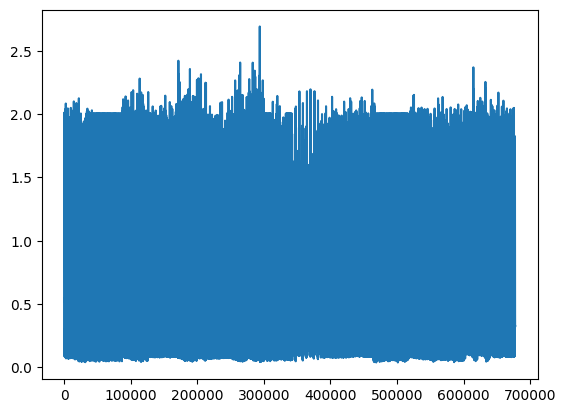

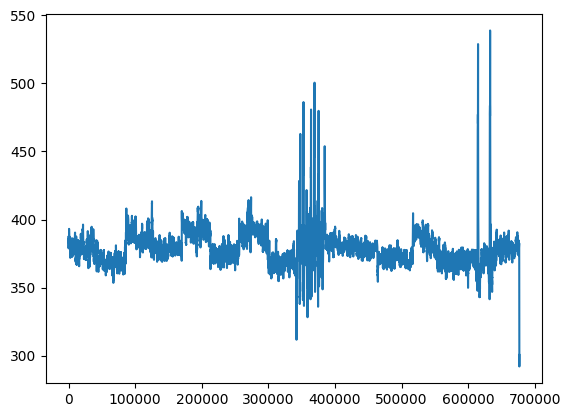

The length of the labels: 676807
The length of the windows: 676807
Best Threshold: 376.37610158396325
Best F1 Score: 0.7130593868282665
Precision: 0.6837078983704675
Recall: 0.7450440270719655
Accuracy: 0.697349465948195
FPR: 0.35125701448990004


In [13]:
plt.plot(rmse_anol_per_row)
plt.show()
window_size = 755
rmse_sliding_sums = np.convolve(rmse_anol_per_row, np.ones(window_size), 'valid')
plt.plot(rmse_sliding_sums)
plt.show()

# Flatten array to 1D and create binary result
adjusted_labels = nicla_labels_anol[755:].ravel()  
binary_result = np.convolve(adjusted_labels, np.ones(window_size), 'valid') > (755 / 2)
binary_result = binary_result.astype(int)

print(f"The length of the labels: {len(binary_result)}")
print(f"The length of the windows: {len(rmse_sliding_sums)}")

# Limits to find the threshold
min_rmse = np.min(rmse_sliding_sums)
max_rmse = np.max(rmse_sliding_sums)

# Initialize variables for the best metrics
best_metrics = {'Threshold': None, 'F1': 0, 'Precision': 0, 'Recall': 0, 'Accuracy': 0, 'FPR': 0}

# Generate a wide range of thresholds including the initial range and fine-tuning range
for threshold in np.linspace(min_rmse - (max_rmse - min_rmse) / 200, max_rmse + (max_rmse - min_rmse) / 200, 2000):
    predictions = (rmse_sliding_sums > threshold).astype(int)
    f1 = f1_score(binary_result, predictions)
    
    if f1 > best_metrics['F1']:
        tn, fp, fn, tp = confusion_matrix(binary_result, predictions).ravel()
        best_metrics = {
            'Threshold': threshold,
            'F1': f1,
            'Precision': precision_score(binary_result, predictions),
            'Recall': recall_score(binary_result, predictions),
            'Accuracy': accuracy_score(binary_result, predictions),
            'FPR': fp / (fp + tn) if (fp + tn) > 0 else 0
        }

# Print the best metrics
print(f"Best Threshold: {best_metrics['Threshold']}")
print(f"Best F1 Score: {best_metrics['F1']}")
print(f"Precision: {best_metrics['Precision']}")
print(f"Recall: {best_metrics['Recall']}")
print(f"Accuracy: {best_metrics['Accuracy']}")
print(f"FPR: {best_metrics['FPR']}")

## Statistical Baseline

In [22]:
# Find autocorrelation example.
def df_autocorr(df, lag=1, axis=0):
    """
    Compute the full-sample column-wise autocorrelation for a DataFrame.

    Parameters:
    -----------
    df : pandas.DataFrame
        The input DataFrame.
    lag : int, optional (default=1)
        The lag at which to compute the autocorrelation.
    axis : int, optional (default=0)
        The axis along which to compute the autocorrelation.

    Returns:
    --------
    pandas.Series
        A Series containing the autocorrelation coefficients for each column of the input DataFrame.
    """
    return df.apply(lambda col: col.autocorr(lag), axis=axis)

def df_rolling_autocorr(df, window, lag=1):
    """
    Compute the rolling column-wise autocorrelation for a DataFrame.

    Parameters:
    -----------
    df : pandas.DataFrame
        The input DataFrame.
    window : int
        The size of the rolling window.
    lag : int, optional (default=1)
        The lag at which to compute the autocorrelation.

    Returns:
    --------
    pandas.DataFrame
        A DataFrame containing the rolling autocorrelation coefficients for each column of the input DataFrame.
    """

    return (df.rolling(window=window)
        .corr(df.shift(lag)))

def df_autocorr_highest(df, window_min, window_max, lag_f):
    """
    Compute the highest mean correlation with respect to window length for each column of a DataFrame.

    Parameters:
    -----------
    df : pandas.DataFrame
        The input DataFrame.
    window_min : int
        The minimum window size to consider.
    window_max : int
        The maximum window size to consider.
    lag_f : int
        The lag at which to compute the autocorrelation.

    Returns:
    --------
    pandas.DataFrame
        A DataFrame containing the highest mean correlation and corresponding window size for each column of the input DataFrame.
    """
    df_corrs = pd.DataFrame()
    df_corr_dict = {}
    for i in range(len(df.columns)):
        corr_init = 0
        corr_index = 0
        for j in range(window_min, window_max): 
            corr = df_rolling_autocorr(df.iloc[:,i], window=j, lag=lag_f).dropna().mean()
            if corr > corr_init:
                corr_init = corr
                corr_index = j
        corr_label = df.columns[i] + "_corr"    
        df_corrs[corr_label] = [corr_init, corr_index]
        df_corr_dict[corr_label] = [corr_init, corr_index]
    return df_corr_dict

# Set tick labels.
tick_labels = ["AccX", "AccY", "AccZ",
               "GyroX", "GyroY", "GyroZ",
               "MagX", "MagY", "MagZ"]

# First we find how anomalous part autocorrelates.
corr = df_autocorr_highest(pd.DataFrame(nicla_anol, columns=tick_labels), 600, 800, 1)
pprint(corr)

{'AccX_corr': [0.9957331570349306, 755],
 'AccY_corr': [0.9989057067106933, 753],
 'AccZ_corr': [0.97650084106174, 769],
 'GyroX_corr': [0.997800197516097, 758],
 'GyroY_corr': [0.9966574060862569, 756],
 'GyroZ_corr': [0.9951860194030435, 751],
 'MagX_corr': [0.9985353721251077, 756],
 'MagY_corr': [0.9996710646640955, 764],
 'MagZ_corr': [0.9991870812175039, 755]}


We see that due to the anomalies, this data **do not correlate** like non-anomalous data.

In [23]:
# Define non-scaled version.
IMU_non_scaled = np.hstack((np_acc, np_gyro, np_mag))

pd_IMU_data = pd.DataFrame(IMU_non_scaled, columns=tick_labels)

# Get sample start / end points.
s_start = 300000
s_end = 400000

# Find the window length that generates highest r (pearson correlation coefficient).
corr = df_autocorr_highest(pd_IMU_data[s_start:s_end], 600, 800, 1)
pprint(corr)

{'AccX_corr': [0.9956480501872034, 755],
 'AccY_corr': [0.9988926089826179, 755],
 'AccZ_corr': [0.9777193381788154, 755],
 'GyroX_corr': [0.9978351908182033, 755],
 'GyroY_corr': [0.9967375464573313, 755],
 'GyroZ_corr': [0.9952034562782655, 755],
 'MagX_corr': [0.9985234447917424, 755],
 'MagY_corr': [0.9996763904760192, 755],
 'MagZ_corr': [0.9991879996879954, 755]}


From the autocorrelation analysis, we see that data correlate highest when window length is **755**.

Data rate is ≈ 19.86Hz. So, **755** points correspond to **38 seconds**. During the test, we tried to set each arm's whole process to **40 seconds**. Thus, that is also confirmed by this analysis.

Our baseline methodology is simple:
   1. We know the periodicity. We set **periodicity to a window length** (755).
   2. We split whole dataset into input windows **with a period length**. 
   3. We generate two base windows via calculating the **mean** and **median** non-anomalous input windows.
   4. We calculate **overall RMSE** for **mean** and **median**.
   
However, there is one challenge that we need to solve. Even though, the data highly correlates with 755 points, we see that there is a **gradually increasing lag** occurring between windows.

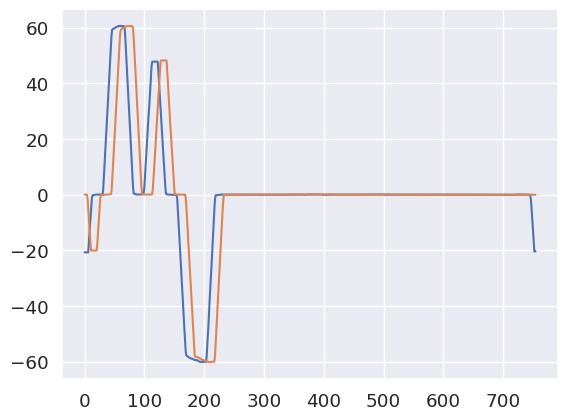

In [24]:
plt.plot(IMU_non_scaled[0:755:, 3])
plt.plot(IMU_non_scaled[755*100:755*101:, 3])
plt.show()

We need to **get rid of this lag** to come up with mean and median baseline windows.

First, we convert whole data to input windows and select random **three consecutive windows** to see if there is a lag.

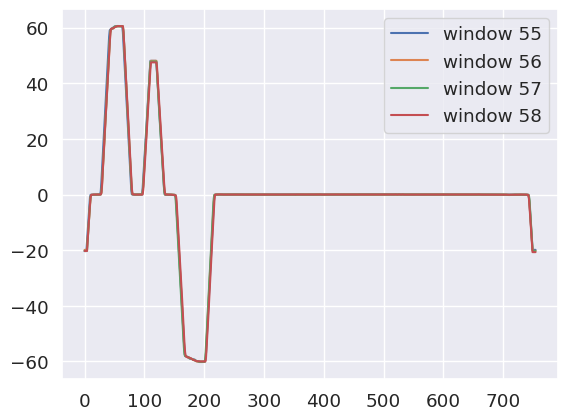

In [25]:
# Set window size.
window_size = 755
# We trim data in a way that it is exactly divided to 755.
# 1072100 data points mean 1420 windows.
IMU_cut = IMU_non_scaled[0:1072100]

# Reshape dataframe into an array of arrays with shape (1420, 755, 9).
n_windows = len(IMU_cut) // window_size

windows = np.empty((1420, 755, 9))
windows = IMU_cut[:n_windows * window_size].reshape(n_windows, window_size, -1)

# Plot windows.
plt.plot(windows[55][:, 3], label="window 55")
plt.plot(windows[56][:, 3], label="window 56")
plt.plot(windows[57][:, 3], label="window 57")
plt.plot(windows[58][:, 3], label="window 58")
plt.legend(loc="upper right")
plt.savefig('/tf/figures/consecutive_windows.pdf', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

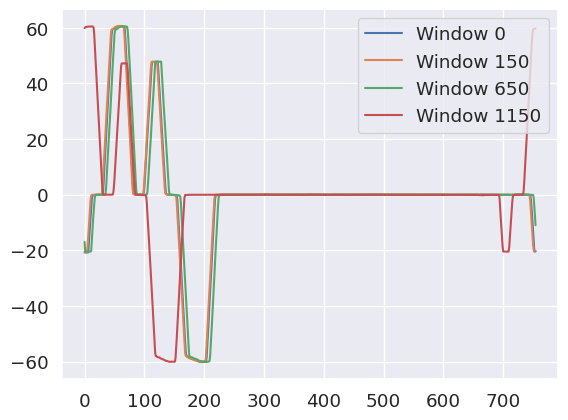

In [26]:
plt.plot(windows[0][0:755:, 3], label="Window 0")
plt.plot(windows[150][0:755, 3], label="Window 150")
plt.plot(windows[650][0:755, 3], label="Window 650")
plt.plot(windows[1150][0:755, 3], label="Window 1150")
plt.legend(loc="upper right")
plt.savefig('/tf/figures/random_windows.pdf', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

We see that, the **lag is more obvius as the gap between the windows increases.**

Now we **detect the lag of all consecutive windows** to confirm what we claimed above.

In [27]:
# Find lag of two consecutive windows.
lag_meds = []
for j in range(n_windows - 1):
    lag_arr = []
    for i in range(windows.shape[2]):
        x = windows[j][:, i]
        y = windows[j+1][:, i]
        correlation = signal.correlate(x-np.mean(x), y - np.mean(y), mode="full")
        lags = signal.correlation_lags(len(x), len(y), mode="full")
        lag = lags[np.argmax(abs(correlation))]
        # print(lag)
        lag_arr.append(lag)
    # print(lag_arr)
    lag_meds.append(np.median(lag_arr))
# Print the max, min lags.
print(min(lag_meds), max(lag_meds))

-3.0 3.0


We confirmed the lags between consecutive windows are **negligible as only ranges from -3 to 3 data points**.

Now, we find the lag of all windows to the **first window**.

In [28]:
# Find lag of all to first window.
lag_meds = []
lag_max = []
lag_mins = []
for j in range(n_windows - 1):
    lag_arr = []
    for i in range(windows.shape[2]):
        x = windows[0][:, i]
        y = windows[j+1][:, i]
        correlation = signal.correlate(x-np.mean(x), y - np.mean(y), mode="full")
        lags = signal.correlation_lags(len(x), len(y), mode="full")
        lag = lags[np.argmax(abs(correlation))]
        # print(lag)
        lag_arr.append(lag)
        
    lag_meds.append(np.median(lag_arr))
    lag_max.append(max(lag_arr))
    
# Print the max, min lags.
print(f"The min med: {min(lag_meds)}, the max med:{max(lag_meds)}")
print(f"The max:{max(lag_max)}")

The min med: -34.0, the max med:114.0
The max:121


This proves that the window sampling based on just **pearson correlation analysis** becomes inadequate when there are high number of near-zero values (this is our guess, need further analysis) are present within the data.

Now, **we will get rid of the lags and align all windows to the first window to come up with a stronger baseline.**

In [29]:
for j in range(n_windows - 1):
    lag_arr = []
    for i in range(windows.shape[2]):
        x = windows[0][:, i]
        y = windows[j+1][:, i]
        correlation = signal.correlate(x-np.mean(x), y - np.mean(y), mode="full")
        lags = signal.correlation_lags(len(x), len(y), mode="full")
        lag = lags[np.argmax(abs(correlation))]
        lag_arr.append(lag)
    
    # Get the lag median.
    w_lag = np.median(lag_arr)
    
    # Append/Prepend the base window's points
    if int(w_lag) < 0:
        # Get the corresponding shifted n points from the base window and append to the shifted window.
        points_diff = windows[0][int(w_lag):]
        # Get the part of the window that aligns with base window.
        cut_window = windows[j+1][(-1*int(w_lag)):755]
        cut_window = np.concatenate((cut_window, points_diff), axis=0)
        windows[j+1] = cut_window
    elif int(w_lag) == 0:
        pass
    else:
        # Get the corresponding shifted n points from the base window and append to the shifted window.
        points_diff = windows[0][0:int(w_lag)]
        # Get the part of the window that aligns with base window.
        cut_window = windows[j+1][0:(755-int(w_lag))]
        cut_window = np.concatenate((points_diff, cut_window), axis=0)
        windows[j+1] = cut_window

Now, that all windows are aligned, **we generate the mean/median windows to be used as stronger baselines.** 

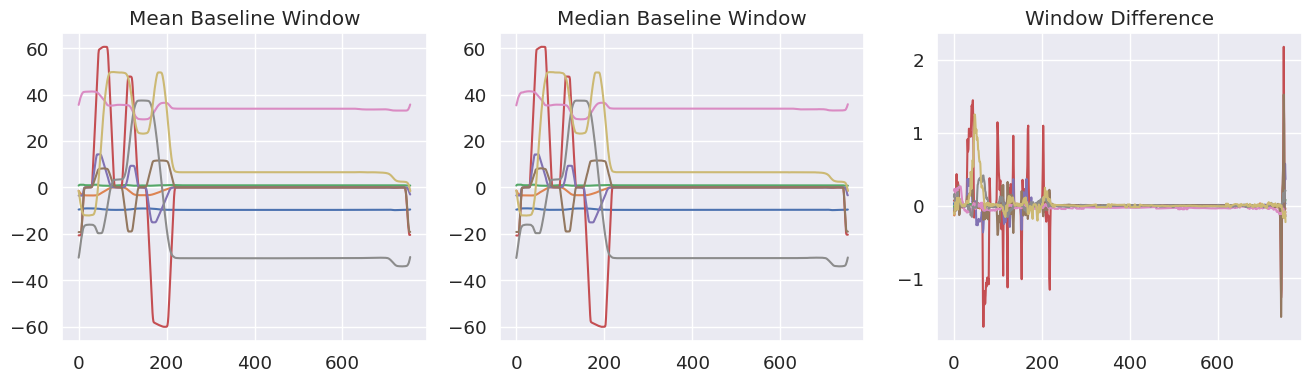

In [30]:
# Get the stronger mean/medians as baselines.
mean_window = np.mean(windows, axis=0)
median_window = np.median(windows, axis=0)

# Find difference between two windows.
diff_window = mean_window - median_window
# Visualise the baselines
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))
ax1.plot(mean_window)
ax2.plot(median_window)
ax3.plot(diff_window)
ax1.set_title("Mean Baseline Window")
ax2.set_title("Median Baseline Window")
ax3.set_title("Window Difference")
plt.savefig('/tf/figures/baseline_windows.pdf', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

In [31]:
sum_rmse_mean = 0
sum_rmse_median = 0
# Sum the RMSEs per feature.
for window in windows:
    rmse_mean = np.sqrt(np.mean((window - mean_window)**2, axis=0))
    rmse_median = np.sqrt(np.mean((window - median_window)**2, axis=0))
    sum_rmse_mean += rmse_mean
    sum_rmse_median += rmse_median
mean_per_feature = sum_rmse_mean / windows.shape[0]
median_per_feature = sum_rmse_median / windows.shape[0]
overall_mean_rmse = np.mean(mean_per_feature)
overall_median_rmse = np.mean(median_per_feature)
print(f"Mean RMSE per feature: {mean_per_feature}")
print(f"Median RMSE per feature: {median_per_feature}")
print(f"Overall mean RMSE: {overall_mean_rmse}")
print(f"Overall median RMSE: {overall_median_rmse}")

Mean RMSE per feature: [0.04278741 0.07058257 0.02718    1.27839048 0.29570638 0.50613047
 0.20503904 0.49432547 0.59824453]
Median RMSE per feature: [0.04314793 0.0714159  0.028084   1.31436817 0.30415338 0.51580648
 0.20815076 0.50062956 0.61386907]
Overall mean RMSE: 0.3909318160524488
Overall median RMSE: 0.39995836045971617


We see that **mean as a baseline beats the median**, hence we will be using **mean baseline** from now on.

Now we will **detect anomalies via the mean baseline**. First, we generate the anomalous windows and check if they align with the baseline.

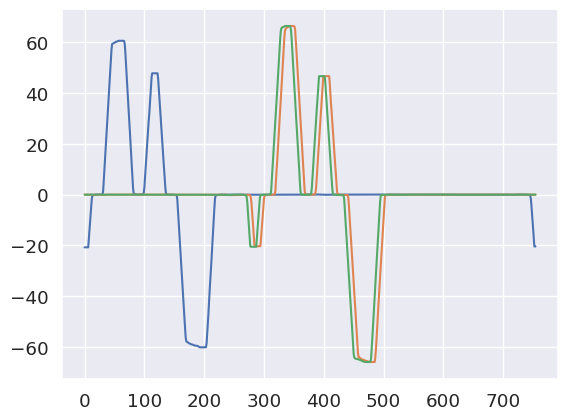

In [32]:
# Get the length of the anomalies
n_anol = len(nicla_anol)
# We cut in a way that it is exactly divided to window size.
anol_cut = nicla_anol[:677990]
# Reshape dataframe into an array of arrays with shape (852, 755, 9).
n_anol_windows = len(anol_cut) // window_size
windows_anol = np.empty((898, 755, 9))
windows_anol = anol_cut[:n_windows * window_size].reshape(n_anol_windows, window_size, -1)

# Compare random windows with the baseline window.
plt.plot(windows[0][:, 3])
plt.plot(windows_anol[0][:, 3])
plt.plot(windows_anol[1][:, 3])
plt.show()

We see that **anomalous windows are not aligned**. They neither align with the base window nor each other.

Now **we align them.**

In [33]:
for j in range(n_anol_windows):
    lag_arr = []
    for i in range(windows_anol.shape[2]):
        x = windows[0][:, i]
        y = windows_anol[j][:, i]
        correlation = signal.correlate(x-np.mean(x), y - np.mean(y), mode="full")
        lags = signal.correlation_lags(len(x), len(y), mode="full")
        lag = lags[np.argmax(abs(correlation))]
        lag_arr.append(lag)
    
    # Get the lag median.
    w_lag = np.median(lag_arr)
    
    # Append/Prepend the base window's points
    if int(w_lag) < 0:
        # Get the corresponding shifted n points from the base window and append to the shifted window.
        points_diff = windows[0][int(w_lag):]
        # Get the part of the window that aligns with base window.
        cut_window = windows_anol[j][(-1*int(w_lag)):755]
        cut_window = np.concatenate((cut_window, points_diff), axis=0)
        windows_anol[j] = cut_window
    elif int(w_lag) == 0:
        pass
    else:
        # Get the corresponding shifted n points from the base window and append to the shifted window.
        points_diff = windows[0][0:int(w_lag)]
        # Get the part of the window that aligns with base window.
        cut_window = windows_anol[j][0:(755-int(w_lag))]
        cut_window = np.concatenate((points_diff, cut_window), axis=0)
        windows_anol[j] = cut_window

We **plot the random anomalous windows** to see if windows are aligned.

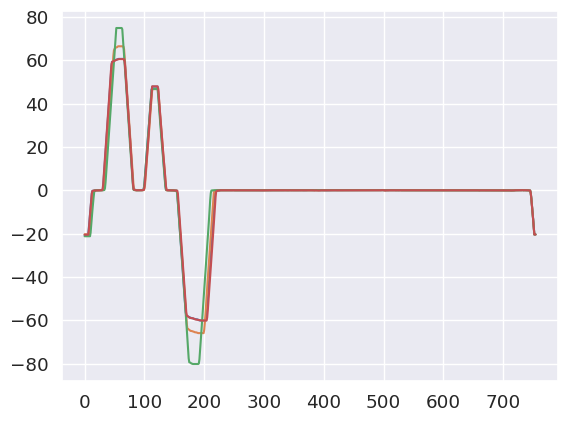

In [34]:
plt.plot(windows[0][:, 3])
plt.plot(windows_anol[0][:, 3])
plt.plot(windows_anol[150][:, 3])
plt.plot(windows_anol[-1][:, 3])
plt.show()

Due to data having anomalies, we work with **non-normalized/standardized** data until now as **anomalies affect the standardization/normalization**. There are robust methods are available but these are not utilized under the context of anomaly detection, as we want our anomalies to stay as they are here.

However, this creates an issue during the RMSE calculation (thresholding), due to data being on different scales, **one feature's noise might contribute RMSE more than the anomaly of an another feature.**

For this reason, we **min-max normalize** the windows before calculating the RMSE. We apply normalization beforehand.

Then we calcuate **mean**, **median**, and **sum** of each RMSE windows. 

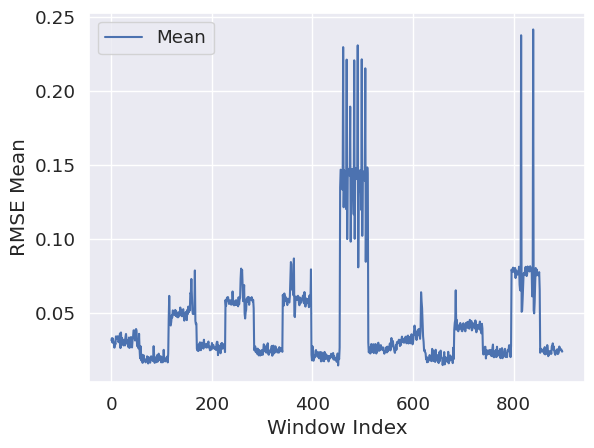

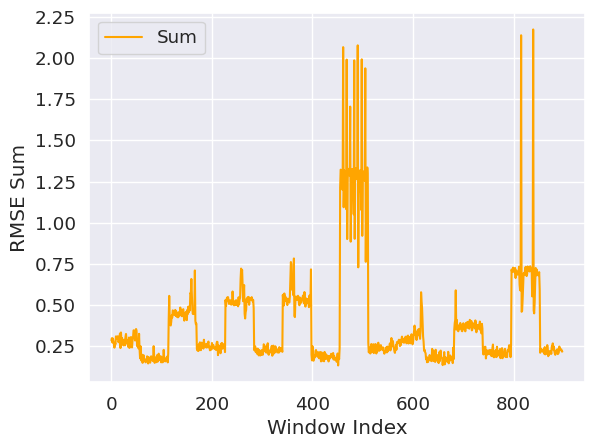

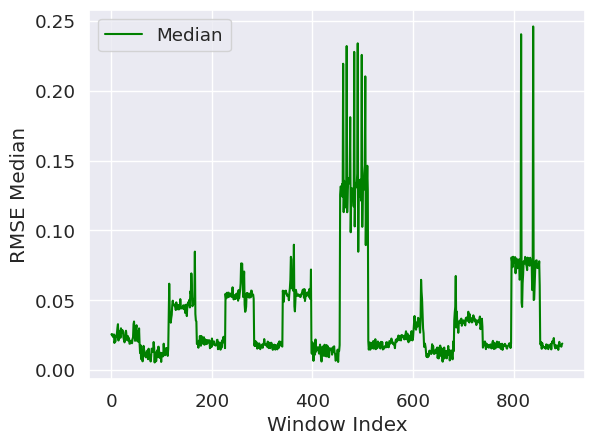

Total processing time: 0.1440274715423584 seconds
Average processing time per window: 0.00016038693935674654 seconds


In [35]:
# Initialize a MinMaxScaler object.
scaler_mm = MinMaxScaler()

# Apply the scaler to the data.
scaler_mm.fit(mean_window)

# Scale the data.
mean_window_mm = scaler_mm.transform(mean_window)

# Start the timer
start_time = time.time()

rmse_anols_mean = []
rmse_anols_sum = []
rmse_anols_median = []

# Calculate the RMSEs per feature for each window
for window in windows_anol:
    
    # Normalize the window via the mean window fit
    anol_scaled = scaler_mm.transform(window)

    # Calculate RMSE for each feature
    rmse_per_feature = np.sqrt(np.mean((anol_scaled - mean_window_mm)**2, axis=0))

    # Calculate and append the mean RMSE
    rmse_mean = np.mean(rmse_per_feature)
    rmse_anols_mean.append(rmse_mean)

    # Calculate and append the sum of RMSE
    rmse_sum = np.sum(rmse_per_feature)
    rmse_anols_sum.append(rmse_sum)

    # Calculate and append the median of RMSE
    rmse_median = np.median(rmse_per_feature)
    rmse_anols_median.append(rmse_median)

# Stop the timer
end_time = time.time()

# Calculate the total processing time
total_processing_time = end_time - start_time

# Calculate the average processing time per window
average_processing_time_per_window = total_processing_time / len(windows_anol)

# Plot and Save RMSE Mean
plt.figure()
plt.xlabel("Window Index")
plt.ylabel("RMSE Mean")
plt.plot(rmse_anols_mean, label='Mean')
plt.legend()
plt.savefig('/tf/figures/rmse_baseline_mean.pdf', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

# Plot and Save RMSE Sum
plt.figure()
plt.xlabel("Window Index")
plt.ylabel("RMSE Sum")
plt.plot(rmse_anols_sum, label='Sum', color='orange')
plt.legend()
plt.savefig('/tf/figures/rmse_baseline_sum.pdf', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

# Plot and Save RMSE Median
plt.figure()
plt.xlabel("Window Index")
plt.ylabel("RMSE Median")
plt.plot(rmse_anols_median, label='Median', color='green')
plt.legend()
plt.savefig('/tf/figures/rmse_baseline_median.pdf', dpi=300, bbox_inches='tight', transparent=True)
plt.show()
print(f"Total processing time: {total_processing_time} seconds")
print(f"Average processing time per window: {average_processing_time_per_window} seconds")

We need to set our labels correctly, as the labels we have are one per point, but we need to label our windows.

We will accept the window as **anomalous if half or more than half of the window contains anomalous points**.

Then based on a **certain threshold (found via grid search)**, we will accept the RMSE window as anomaly or not.

Grid search is a labour intensive task, thus we only provide **the final search parameters below**.

In [36]:
# Similar to windowing previously, divideable to 755.
nicla_labels_anol_cut = nicla_labels_anol[:677990]

# Convert into windows.
label_windows = nicla_labels_anol_cut[:n_windows * window_size].reshape(n_anol_windows, window_size, -1)

# if sum is above 755/2 its anomaly.
# If sum is above 755/2, it's an anomaly.
# if sum is above 755/2 its anomaly.
label_final = []
for window in label_windows:
    if np.sum(window) > 755/2:
        label_final.append(1)
    else:
        label_final.append(0)

In [37]:
# Define a function to calculate different metrics
def calculate_metrics(tp, fp, tn, fn):
    acc = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) != 0 else 0
    rec = tp / (tp + fn) if (tp + fn) != 0 else 0
    prec = tp / (tp + fp) if (tp + fp) != 0 else 0
    f1 = (2 * prec * rec) / (prec + rec) if (prec + rec) != 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) != 0 else 0
    return acc, rec, prec, f1, fpr

# Set a range of thresholds.
# We set the best one, feel free to play with these.
th = [x/10000 for x in range(0, 5001, 1)]

best_f1_mean = 0
best_threshold_mean = 0
best_results_mean = {}

best_f1_median = 0
best_threshold_median = 0
best_results_median = {}

best_f1_sum = 0
best_threshold_sum = 0
best_results_sum = {}

for threshold in th:
    # For Mean RMSE
    y_pred_mean = [1 if rmse >= threshold else 0 for rmse in rmse_anols_mean]
    tn_mean, fp_mean, fn_mean, tp_mean = confusion_matrix(label_final, y_pred_mean).ravel()
    acc_mean, rec_mean, prec_mean, f1_mean, fpr_mean = calculate_metrics(tp_mean, fp_mean, tn_mean, fn_mean)

    if f1_mean > best_f1_mean:
        best_f1_mean = f1_mean
        best_threshold_mean = threshold
        best_results_mean = {'Threshold': threshold, 'Accuracy': acc_mean, 'Recall': rec_mean, 'Precision': prec_mean, 'F1': f1_mean, 'FPR': fpr_mean}


    # For Median RMSE
    y_pred_median = [1 if rmse >= threshold else 0 for rmse in rmse_anols_median]
    tn_median, fp_median, fn_median, tp_median = confusion_matrix(label_final, y_pred_median).ravel()
    acc_median, rec_median, prec_median, f1_median, fpr_median = calculate_metrics(tp_median, fp_median, tn_median, fn_median)

    if f1_median > best_f1_median:
        best_f1_median = f1_median
        best_threshold_median = threshold
        best_results_median = {'Threshold': threshold, 'Accuracy': acc_median, 'Recall': rec_median, 'Precision': prec_median, 'F1': f1_median, 'FPR': fpr_median}


    # For Sum RMSE
    y_pred_sum = [1 if rmse >= threshold else 0 for rmse in rmse_anols_sum]
    tn_sum, fp_sum, fn_sum, tp_sum = confusion_matrix(label_final, y_pred_sum).ravel()
    acc_sum, rec_sum, prec_sum, f1_sum, fpr_sum = calculate_metrics(tp_sum, fp_sum, tn_sum, fn_sum)

    if f1_sum > best_f1_sum:
        best_f1_sum = f1_sum
        best_threshold_sum = threshold
        best_results_sum = {'Threshold': threshold, 'Accuracy': acc_sum, 'Recall': rec_sum, 'Precision': prec_sum, 'F1': f1_sum, 'FPR': fpr_sum}

print(f"For mean: {best_results_mean}")
print(f"For median: {best_results_median}")
print(f"For sum: {best_results_sum}")

For mean: {'Threshold': 0.0302, 'Accuracy': 0.9576837416481069, 'Recall': 0.933920704845815, 'Precision': 0.9814814814814815, 'F1': 0.9571106094808127, 'FPR': 0.018018018018018018}
For median: {'Threshold': 0.0208, 'Accuracy': 0.9510022271714922, 'Recall': 0.960352422907489, 'Precision': 0.9437229437229437, 'F1': 0.9519650655021834, 'FPR': 0.05855855855855856}
For sum: {'Threshold': 0.2716, 'Accuracy': 0.9587973273942093, 'Recall': 0.9361233480176211, 'Precision': 0.9815242494226328, 'F1': 0.9582863585118377, 'FPR': 0.018018018018018018}


Now let's see which anomalies are detected.

In [38]:
# Function to find indices where predictions and actual labels differ
def find_misclassified_indices(y_pred, label_final):
    return np.where(np.array(y_pred) != np.array(label_final))[0]

# For Mean RMSE
y_pred_mean_best = [1 if rmse >= best_threshold_mean else 0 for rmse in rmse_anols_mean]
misclassified_mean = find_misclassified_indices(y_pred_mean_best, label_final)

# For Median RMSE
y_pred_median_best = [1 if rmse >= best_threshold_median else 0 for rmse in rmse_anols_median]
misclassified_median = find_misclassified_indices(y_pred_median_best, label_final)

# For Sum RMSE
y_pred_sum_best = [1 if rmse >= best_threshold_sum else 0 for rmse in rmse_anols_sum]
misclassified_sum = find_misclassified_indices(y_pred_sum_best, label_final)

# Print the indices of misclassified windows
print(f"Misclassified indices for mean RMSE: {misclassified_mean}")
print(f"Misclassified indices for median RMSE: {misclassified_median}")
print(f"Misclassified indices for sum RMSE: {misclassified_sum}")

Misclassified indices for mean RMSE: [  2   5   6   7   8  18  23  24  27  31  34  36  38  41  51  52  54  56
 176 184 193 210 211 557 560 569 574 576 582 587 591 595 599 622 623 624
 625 682]
Misclassified indices for median RMSE: [  6   8  26  27  34  36  37  38  40  41  52  54  56 174 176 179 180 182
 184 186 187 189 192 193 195 200 210 211 220 222 223 304 406 525 557 566
 591 622 623 624 625 682 759 880]
Misclassified indices for sum RMSE: [  5   6   7   8  18  23  24  27  31  34  36  38  41  51  52  54  56 176
 184 193 210 211 557 560 569 574 576 582 587 591 595 599 622 623 624 625
 682]


We manually examined the windows and labels are as below:
- 1 - 57 = 10% increase
- 115 - 170 = 35% increase
- 228 - 284 = 65% increase
- 342 - 398 = 100% increase
- 456 - 511 = 5% decrease
- 569 - 626 = 50% decrease
- 684 - 739 = 20% increase
- 797 - 853 = 25% decrease

Based on these we see that: 

- Mean RMSE 18 of %10 increase, 11 of 5% decrease, 12 of 50% decrease.
- Median RMSE 13 of %10 increase, 5 of 50% decrease.
- Sum RMSE 17 of %10 increase, 12 of %50 decrease.

The above windows are the ones that cannot be detected. As we cannot confirm the joint velocity for each cycle these numbers are not useful. Hence from now on, we do not investigate per anomaly. 

From the above figure, we see that baseline is pretty strong, but struggles to detect 5% decrease setting on maximum joint velocity.

Now we check, how much change that corresponds actually.

In [39]:
# For some reason, joint velocities are string.
# We get sum here.
def sum_of_abs_values(row):
    # Convert the string representation to a list
    numbers = ast.literal_eval(row)
    # Return the sum of absolute values
    return sum(abs(i) for i in numbers)

# For some reason, joint velocities are string.
# We get max here
def max_of_abs_values(row):
    # Convert the string representation to a list
    numbers = ast.literal_eval(row)
    # Return the maximum of absolute values
    return max(abs(i) for i in numbers)

# Check the anomaly labels.
df_anol = right_arm["Anomaly State"]
# Find the first anomaly point.
idx_f = (df_anol == 1.0).idxmax()
print(f"The first anomaly is seen at {idx_f}")

normal_joint_velocity = right_arm["Actual Joint Velocities"][0:idx_f]
anomalous_joint_velocity = right_arm["Actual Joint Velocities"][idx_f:]

# We get absolute sums.
normal_joint_velocity_sum = normal_joint_velocity.apply(sum_of_abs_values)
anomalous_joint_velocity_sum = anomalous_joint_velocity.apply(sum_of_abs_values)

# We get absolute maximums.
normal_joint_velocity_max = normal_joint_velocity.apply(max_of_abs_values)
anomalous_joint_velocity_max = anomalous_joint_velocity.apply(max_of_abs_values)

The first anomaly is seen at 1080004


 Let's see how sum of joint velocities reflect on data.

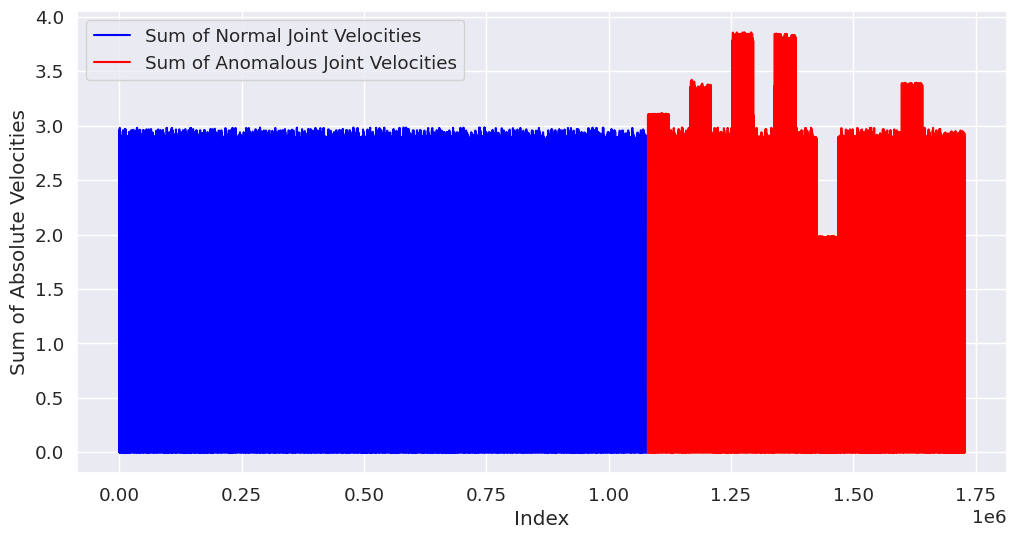

In [40]:
# Plotting
plt.figure(figsize=(12, 6))

# Plotting normal_joint_velocity
plt.plot(normal_joint_velocity_sum, label='Sum of Normal Joint Velocities', color='blue')

# Plotting anomalous_joint_velocity
plt.plot(anomalous_joint_velocity_sum, label='Sum of Anomalous Joint Velocities', color='red')

# Adding title and labels
# plt.title('Comparison of Normal and Anomalous Joint Velocities')
plt.xlabel('Index')
plt.ylabel('Sum of Absolute Velocities')

# Adding legend
plt.legend()

# Save the figure
plt.savefig('/tf/figures/absoluteSumVelocities.pdf', dpi=300, bbox_inches='tight', transparent=True)

# Showing the plot
plt.show()

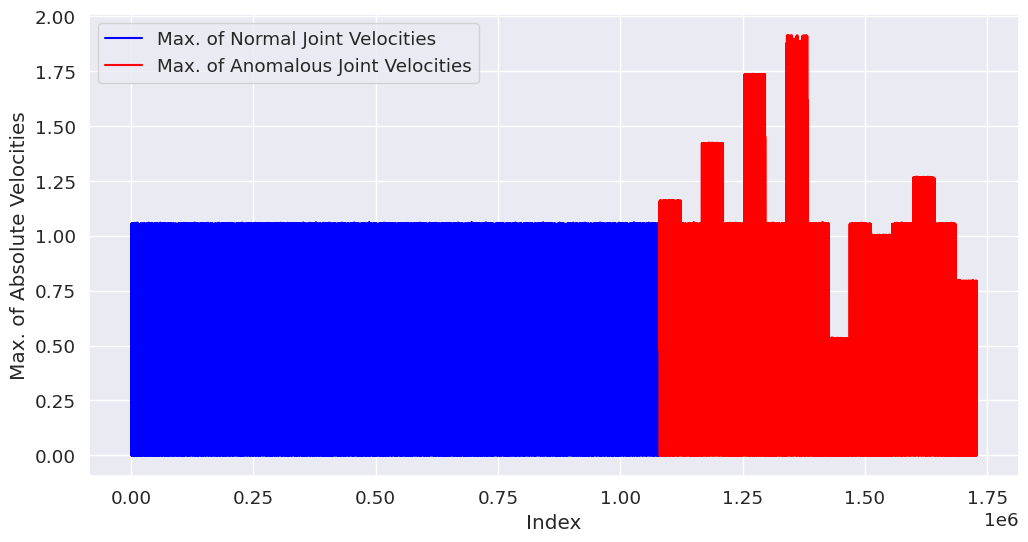

In [41]:
# Plotting
plt.figure(figsize=(12, 6))

# Plotting normal_joint_velocity
plt.plot(normal_joint_velocity_max, label='Max. of Normal Joint Velocities', color='blue')

# Plotting anomalous_joint_velocity
plt.plot(anomalous_joint_velocity_max, label='Max. of Anomalous Joint Velocities', color='red')

# Adding title and labels
# plt.title('Comparison of Normal and Anomalous Joint Velocities')
plt.xlabel('Index')
plt.ylabel('Max. of Absolute Velocities')

# Adding legend
plt.legend()

# Save the figure
plt.savefig('/tf/figures/absoluteMaxVelocities.pdf', dpi=300, bbox_inches='tight', transparent=True)

# Showing the plot
plt.show()

Now we find how actually these changes are.

In [42]:
max_joint_len = len(anomalous_joint_velocity_max)
default_joint_velo = anomalous_joint_velocity_max[46000:47000].max()
first_high_max_joint = anomalous_joint_velocity_max[0:40000].max()
second_high_max_joint = anomalous_joint_velocity_max[90000:91000].max()
third_high_max_joint = anomalous_joint_velocity_max[210000:211000].max()
fourth_high_max_joint = anomalous_joint_velocity_max[295000:296000].max()
fifth_high_max_joint = anomalous_joint_velocity_max[360000:361000].max()
sixth_high_max_joint = anomalous_joint_velocity_max[460000:461000].max()
seventh_high_max_joint = anomalous_joint_velocity_max[540000:541000].max()
eight_high_max_joint = anomalous_joint_velocity_max[640000:641000].max()

print(f"The defaul joint velocity {default_joint_velo}")
print(f"The first anomaly {first_high_max_joint}")
print(f"The second anomaly {second_high_max_joint}")
print(f"The third anomaly {third_high_max_joint}")
print(f"The fourth anomaly {fourth_high_max_joint}")
print(f"The fifth anomaly {fifth_high_max_joint}")
print(f"The sixth anomaly {sixth_high_max_joint}")
print(f"The seventh anomaly {seventh_high_max_joint}")
print(f"The eight anomaly {eight_high_max_joint}")

# Calculating percentage changes
first_percent_change = ((first_high_max_joint - default_joint_velo) / default_joint_velo) * 100
second_percent_change = ((second_high_max_joint - default_joint_velo) / default_joint_velo) * 100
third_percent_change = ((third_high_max_joint - default_joint_velo) / default_joint_velo) * 100
fourth_percent_change = ((fourth_high_max_joint - default_joint_velo) / default_joint_velo) * 100
fifth_percent_change = ((fifth_high_max_joint - default_joint_velo) / default_joint_velo) * 100
sixth_percent_change = ((sixth_high_max_joint - default_joint_velo) / default_joint_velo) * 100
seventh_percent_change = ((seventh_high_max_joint - default_joint_velo) / default_joint_velo) * 100
eighth_percent_change = ((eight_high_max_joint - default_joint_velo) / default_joint_velo) * 100

# Printing the percentage changes
print(f"First anomaly change: {first_percent_change:.2f}%")
print(f"Second anomaly change: {second_percent_change:.2f}%")
print(f"Third anomaly change: {third_percent_change:.2f}%")
print(f"Fourth anomaly change: {fourth_percent_change:.2f}%")
print(f"Fifth anomaly change: {fifth_percent_change:.2f}%")
print(f"Sixth anomaly change: {sixth_percent_change:.2f}%")
print(f"Seventh anomaly change: {seventh_percent_change:.2f}%")
print(f"Eighth anomaly change: {eighth_percent_change:.2f}%")


The defaul joint velocity 1.057202696800232
The first anomaly 1.1630803346633911
The second anomaly 1.4227206707000732
The third anomaly 1.7359321117401123
The fourth anomaly 1.9131666421890259
The fifth anomaly 0.5323903560638428
The sixth anomaly 1.0038925409317017
The seventh anomaly 1.2661172151565552
The eight anomaly 0.7960149049758911
First anomaly change: 10.01%
Second anomaly change: 34.57%
Third anomaly change: 64.20%
Fourth anomaly change: 80.96%
Fifth anomaly change: -49.64%
Sixth anomaly change: -5.04%
Seventh anomaly change: 19.76%
Eighth anomaly change: -24.71%


## 1D-CNN

We try to reduce randomness via below commands.

In [324]:
# The below is necessary for starting core Python generated random numbers in a well-defined state.
random.seed(12345)

# The below is necessary for starting Numpy generated random numbers in a well-defined initial state.
np.random.seed(42)

# The below set_seed will make random number generation in the TensorFlow backend have a well-defined initial state.
# For further details, see: https://www.tensorflow.org/api_docs/python/tf/random/set_seed
tf.random.set_seed(1234)

In [10]:
patience = 3
batch_size = 1024
sequence_stride = 1
MAX_EPOCHS = 100

def compile_and_fit(model, window, patience=patience):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min')

    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                  optimizer=tf.keras.optimizers.Adamax(),
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                        validation_data=window.val,
                        callbacks=[early_stopping])
    return history

def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
                 [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                  axis=-1)

    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
             data=data,
             targets=None,
             sequence_length=self.total_window_size,
             sequence_stride=sequence_stride,
             shuffle=False,
             batch_size=batch_size,)

    ds = ds.map(self.split_window)

    return ds

@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def anol(self):
    return self.make_dataset(self.anol_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result

class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df, val_df, test_df, anol_df, label_columns=None):
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        self.anol_df = anol_df

        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

WindowGenerator.split_window = split_window
WindowGenerator.make_dataset = make_dataset
WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.anol = anol
WindowGenerator.example = example

In [11]:
CONV_WIDTH = 5 # Kernel size.
NUM_FILTERS = 32
MAX_POOL_SIZE = 3
NUM_FEATURES = 9
WINDOW_SIZE = 755 # This is output size.
OUT_SIZE = 1 # Gives the best result.

# Set neural network model/parameters.
cnn_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(NUM_FILTERS, activation='relu', kernel_size=(CONV_WIDTH)),
    tf.keras.layers.Conv1D(NUM_FILTERS, activation='relu', kernel_size=(CONV_WIDTH)),
    tf.keras.layers.MaxPooling1D(pool_size=MAX_POOL_SIZE),
    # tf.keras.layers.Conv1D(NUM_FILTERS, activation='relu', kernel_size=(CONV_WIDTH)),
    # tf.keras.layers.Conv1D(NUM_FILTERS, activation='relu', kernel_size=(CONV_WIDTH)),
    # tf.keras.layers.MaxPooling1D(pool_size=MAX_POOL_SIZE),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(OUT_SIZE*NUM_FEATURES, kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_SIZE, NUM_FEATURES])
])

val_performance = {}
loss = {}
val_loss = {}

cnn_model.build(input_shape=(None, 755, 9))
cnn_model.summary()

# Define window params.
w_1dcnn = WindowGenerator(input_width=WINDOW_SIZE, label_width=OUT_SIZE, shift=OUT_SIZE,
                     train_df=X_train, val_df=X_val, test_df = X_test, anol_df = X_anol)

# Verify the model input/output shape.
print('Input shape:', w_1dcnn.example[0].shape)
print('Output shape:', cnn_model(w_1dcnn.example[0]).shape)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 751, 32)           1472      
                                                                 
 conv1d_3 (Conv1D)           (None, 747, 32)           5152      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 249, 32)           0         
 g1D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 7968)              0         
                                                                 
 dense_1 (Dense)             (None, 9)                 71721     
                                                                 
 reshape_1 (Reshape)         (None, 1, 9)              0         
                                                      

2024-12-04 15:40:31.605455: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906


Output shape: (1024, 1, 9)


In [374]:
# Train the model.
history_1dcnn = compile_and_fit(cnn_model, w_1dcnn)

Epoch 1/100
628/628 [==============================] - 31s 48ms/step - loss: 0.0324 - root_mean_squared_error: 0.1800 - val_loss: 0.0225 - val_root_mean_squared_error: 0.1500
Epoch 2/100
628/628 [==============================] - 31s 49ms/step - loss: 0.0189 - root_mean_squared_error: 0.1376 - val_loss: 0.0168 - val_root_mean_squared_error: 0.1297
Epoch 3/100
628/628 [==============================] - 31s 49ms/step - loss: 0.0145 - root_mean_squared_error: 0.1204 - val_loss: 0.0127 - val_root_mean_squared_error: 0.1127
Epoch 4/100
628/628 [==============================] - 31s 49ms/step - loss: 0.0113 - root_mean_squared_error: 0.1065 - val_loss: 0.0099 - val_root_mean_squared_error: 0.0994
Epoch 5/100
628/628 [==============================] - 31s 49ms/step - loss: 0.0094 - root_mean_squared_error: 0.0971 - val_loss: 0.0085 - val_root_mean_squared_error: 0.0924
Epoch 6/100
628/628 [==============================] - 31s 49ms/step - loss: 0.0083 - root_mean_squared_error: 0.0911 - val_l

In [12]:
# Comment or uncomment accordingly.
# Path to save the model.
# Edit accordingly.
model_path = "/tf/models/1D_CNN_model_2_v5"
# Save the model.
# cnn_model.save(model_path + ".keras")
# Load the model.
cnn_model = load_model("/tf/models/1D_CNN_model_final.keras")

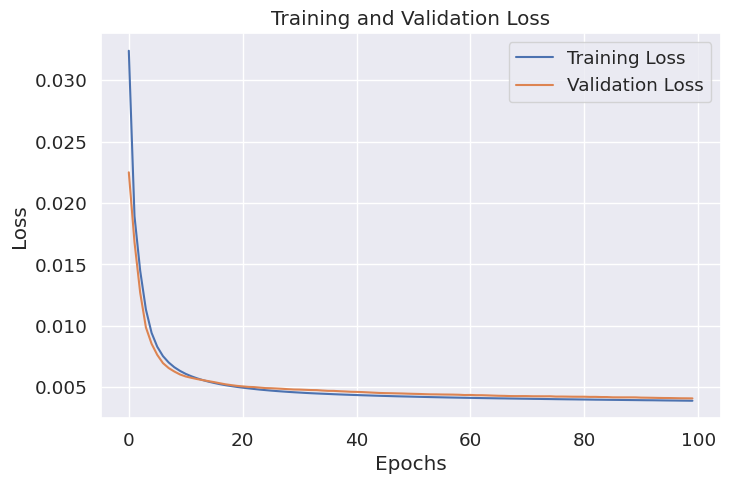

In [376]:
# Plot the loss graph.
# Extract loss and validation loss from the history object
train_loss = history_1dcnn.history['loss']
val_loss = history_1dcnn.history['val_loss']

# Generate a range for the number of epochs
epochs = range(len(train_loss))

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
# Saving the figure with the model_path in the file name
# Ensure that only the filename part is used in the save path
filename = model_path.split('/')[-1] 
save_path = f"/tf/figures/{filename}.pdf"
plt.savefig(save_path)
plt.show()

In [13]:
test_loss_1d_cnn, test_rmse_1d_cnn = cnn_model.evaluate(w_1dcnn.test, verbose=2)
print(f"Test Loss: {test_loss_1d_cnn}, Test RMSE: {test_rmse_1d_cnn}")

# Assuming each batch in w_1dcnn.anol (except possibly the last) contains 1024 samples
num_batches = len(w_1dcnn.anol)

# Measure inference time
start_time = time.time()
# Predict anomalous samples
anomalous_predictions = cnn_model.predict(w_1dcnn.anol, batch_size=1024)
end_time = time.time()

# Calculate total and average inference time
total_inference_time = end_time - start_time
total_samples = num_batches * 1024  # Assuming each batch has 1024 samples
average_inference_time_per_sample = total_inference_time / total_samples

print(f"Total inference time for all samples: {total_inference_time} seconds")
print(f"Average inference time per sample: {average_inference_time_per_sample} seconds")

209/209 - 5s - loss: 0.0117 - root_mean_squared_error: 0.1080 - 5s/epoch - 23ms/step
Test Loss: 0.011663087643682957, Test RMSE: 0.10799575597047806
662/662 [==============================] - 12s 18ms/step
Total inference time for all samples: 12.181888580322266 seconds
Average inference time per sample: 1.7970355840968222e-05 seconds


In [14]:
# Reshape predictions to 2D so we can scale back.
reshaped_predictions = anomalous_predictions.reshape(-1, 9)

# Inverse transform to original scale
# Assuming scaler_X is your StandardScaler instance
anol_preds = scaler_X.inverse_transform(reshaped_predictions)

# Drop the first 755 rows from nicla_anol to match the shape with anol_preds
adjusted_nicla_anol = nicla_anol[755:]

# Assuming anol_preds and reshaped_predictions are numpy arrays
rmse_per_row = np.sqrt(np.mean(np.square(anol_preds - adjusted_nicla_anol), axis=1))

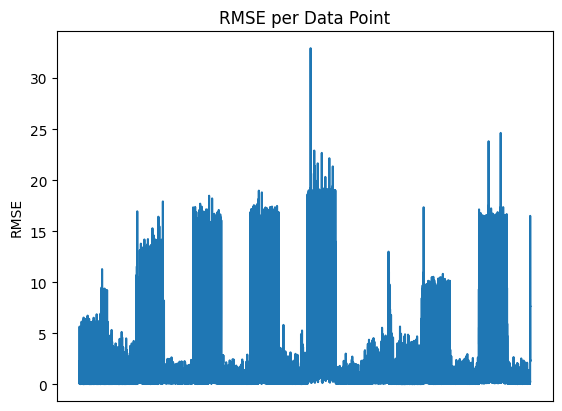

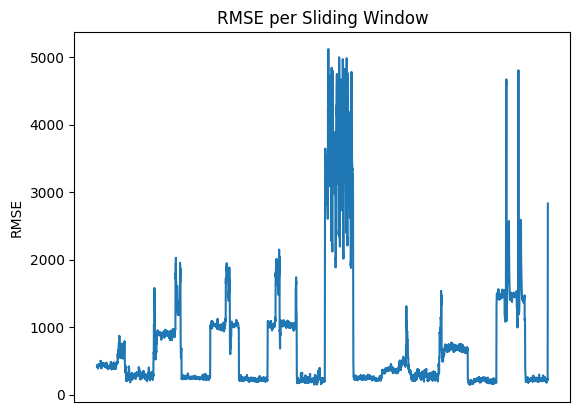

In [15]:
plt.plot(rmse_per_row)
# plt.xlabel('Row Index')
plt.ylabel('RMSE')
plt.title('RMSE per Data Point')
plt.xticks([])
plt.savefig('/tf/figures/rmse_model.pdf', format='pdf')
plt.show()

window_size = 755
rmse_sliding_sums = np.convolve(rmse_per_row, np.ones(window_size), 'valid')

plt.plot(rmse_sliding_sums)
# plt.xlabel('Window Index')
plt.ylabel('RMSE')
plt.title('RMSE per Sliding Window')
plt.xticks([])
plt.savefig('/tf/figures/rmse_slided_model.pdf', format='pdf')
plt.show()

**Prepare labels in a way that it matches with sliding sum rmse windows.**

In [132]:
# Flatten array to 1D.
adjusted_labels = nicla_labels_anol[755:].ravel()  
binary_result = np.convolve(adjusted_labels, np.ones(window_size), 'valid') > (755 / 2)
binary_result = binary_result.astype(int)
print(f"The length of the labels: {len(binary_result)}")
print(f"The length of the windows: {len(rmse_sliding_sums)}")

# Limits to find the threshold
min_rmse = np.min(rmse_sliding_sums)
max_rmse = np.max(rmse_sliding_sums)

# Initialize variables for the best metrics
best_metrics = {'F1': 0}
best_predictions = None

# Generate a wide range of thresholds including the initial range and fine-tuning range
for threshold in np.linspace(min_rmse - (max_rmse - min_rmse) / 200, max_rmse + (max_rmse - min_rmse) / 200, 1000):
    predictions = (rmse_sliding_sums > threshold).astype(int)
    f1 = f1_score(binary_result, predictions)
    
    if f1 > best_metrics['F1']:
        tn, fp, fn, tp = confusion_matrix(binary_result, predictions).ravel()
        best_metrics = {
            'Threshold': threshold,
            'F1': f1,
            'Precision': precision_score(binary_result, predictions),
            'Recall': recall_score(binary_result, predictions),
            'Accuracy': accuracy_score(binary_result, predictions),
            'FPR': fp / (fp + tn) if (fp + tn) > 0 else 0
        }
        best_predictions = predictions

# Print the best metrics
print(f"Best Threshold: {best_metrics['Threshold']}")
print(f"Best F1 Score: {best_metrics['F1']}")
print(f"Precision: {best_metrics['Precision']}")
print(f"Recall: {best_metrics['Recall']}")
print(f"Accuracy: {best_metrics['Accuracy']}")
print(f"FPR: {best_metrics['FPR']}")

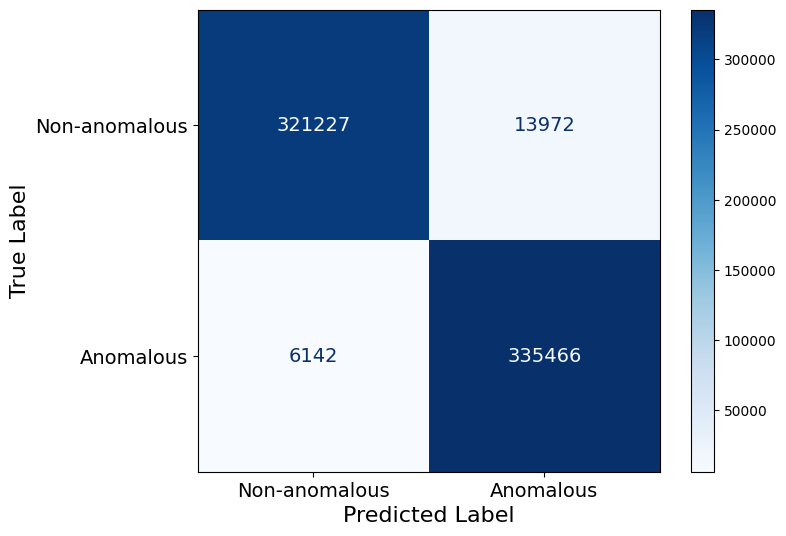

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute the confusion matrix
cm = confusion_matrix(binary_result, best_predictions)

# Create a ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-anomalous", "Anomalous"])

# Plot the confusion matrix and increase font size
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap="Blues", values_format="d")

# Increase font size
ax.tick_params(axis='both', labelsize=14)  # For tick labels
for text in disp.text_.ravel():
    text.set_fontsize(14)  # For matrix values

# Set axis labels with increased font size
ax.set_xlabel("Predicted Label", fontsize=16)
ax.set_ylabel("True Label", fontsize=16)

# Save the figure
plt.savefig("confusion_matrix_1d_cnn.pdf", format="pdf")
plt.show()

## LSTM

In [26]:
patience = 3
batch_size = 1024
sequence_stride = 1

def compile_and_fit(model, window, patience=patience):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min')

    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                  # optimizer=tf.keras.optimizers.RMSprop(),
                  optimizer=tf.keras.optimizers.Adamax(),
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                        validation_data=window.val,
                        callbacks=[early_stopping])
    return history

def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
                 [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                  axis=-1)

    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
             data=data,
             targets=None,
             sequence_length=self.total_window_size,
             sequence_stride=sequence_stride,
             shuffle=False,
             batch_size=batch_size,)

    ds = ds.map(self.split_window)

    return ds

@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def anol(self):
    return self.make_dataset(self.anol_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result

class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df, val_df, test_df, anol_df, label_columns=None):
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        self.anol_df = anol_df

        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

WindowGenerator.split_window = split_window
WindowGenerator.make_dataset = make_dataset
WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.anol = anol
WindowGenerator.example = example

In [27]:
MAX_EPOCHS = 10 # Can increase more for further analysis.
NUM_FILTERS = 8
NUM_FEATURES = 9
WINDOW_SIZE = 755 # This is output size.
OUT_SIZE = 1 # Gives the best result.

# # LSTM model
# lstm_model = Sequential([
#     LSTM(NUM_FILTERS, return_sequences=False, input_shape=(755, 9), 
#                          kernel_regularizer=l1(0.001)),
#     #Dense(NUM_FILTERS, activation='relu'),
#     #Dropout(0.2),
#     Dense(NUM_FEATURES),
#     Reshape([1, NUM_FEATURES], input_shape=(NUM_FEATURES,))
# ])

# # Adjusted LSTM model with Batch Normalization
# lstm_model = Sequential([
#     LSTM(NUM_FILTERS, return_sequences=True, input_shape=(755, 9)),
#     BatchNormalization(),
#     Dropout(0.1),
#     LSTM(NUM_FILTERS, return_sequences=False),
#     BatchNormalization(),
#     Dense(NUM_FILTERS, activation='tanh'),
#     Dropout(0.1),
#     Dense(NUM_FEATURES),
#     Reshape([1, NUM_FEATURES])
# ])

# # Minimal LSTM model
# lstm_model = Sequential([
#     LSTM(NUM_FILTERS, input_shape=(None, NUM_FEATURES)), 
#     Dense(NUM_FEATURES),
#     Reshape([1, NUM_FEATURES])
# ])

MAX_EPOCHS = 100 # Can increase more for further analysis.
NUM_FILTERS = 32
NUM_FEATURES = 9
WINDOW_SIZE = 755 # This is output size.
OUT_SIZE = 1 # Gives the best result.

lstm_model = Sequential([
    LSTM(NUM_FILTERS, return_sequences=True, input_shape=(WINDOW_SIZE, NUM_FEATURES)),  # First LSTM layer
    LSTM(NUM_FILTERS, return_sequences=False),  # Second LSTM layer
    Dense(NUM_FEATURES),  # Dense layer to output 9 features
    Reshape([1, NUM_FEATURES])  # Reshaping the output as needed
])

val_performance = {}
loss = {}
val_loss = {}

# Show the model architecture
lstm_model.summary()

# Set window.
w_lstm = WindowGenerator(input_width=WINDOW_SIZE, label_width=OUT_SIZE, shift=OUT_SIZE,
                     train_df=X_train, val_df=X_val, test_df = X_test, anol_df = X_anol)

# Verify the model input/output shape.
print('Input shape:', w_lstm.example[0].shape)
print('Output shape:', lstm_model(w_lstm.example[0]).shape)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 755, 32)           5376      
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dense_2 (Dense)             (None, 9)                 297       
                                                                 
 reshape_2 (Reshape)         (None, 1, 9)              0         
                                                                 
Total params: 13993 (54.66 KB)
Trainable params: 13993 (54.66 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Input shape: (1024, 755, 9)
Output shape: (1024, 1, 9)


In [443]:
# Train the model.
# Compile and evaluate.
history_lstm = compile_and_fit(lstm_model, w_lstm)

Epoch 1/100
628/628 [==============================] - 85s 132ms/step - loss: 0.1249 - root_mean_squared_error: 0.3534 - val_loss: 0.0254 - val_root_mean_squared_error: 0.1592
Epoch 2/100
628/628 [==============================] - 82s 131ms/step - loss: 0.0194 - root_mean_squared_error: 0.1395 - val_loss: 0.0163 - val_root_mean_squared_error: 0.1278
Epoch 3/100
628/628 [==============================] - 82s 131ms/step - loss: 0.0143 - root_mean_squared_error: 0.1196 - val_loss: 0.0127 - val_root_mean_squared_error: 0.1127
Epoch 4/100
628/628 [==============================] - 82s 131ms/step - loss: 0.0112 - root_mean_squared_error: 0.1059 - val_loss: 0.0101 - val_root_mean_squared_error: 0.1004
Epoch 5/100
628/628 [==============================] - 82s 131ms/step - loss: 0.0092 - root_mean_squared_error: 0.0962 - val_loss: 0.0085 - val_root_mean_squared_error: 0.0924
Epoch 6/100
628/628 [==============================] - 82s 131ms/step - loss: 0.0078 - root_mean_squared_error: 0.0884 -

In [28]:
# Save the model.
# lstm_model.save("/tf/models/LSTM_model_4_v2" + ".keras")

# Load the model
lstm_model = load_model("/tf/models/LSTM_model_4_v2" + ".keras")

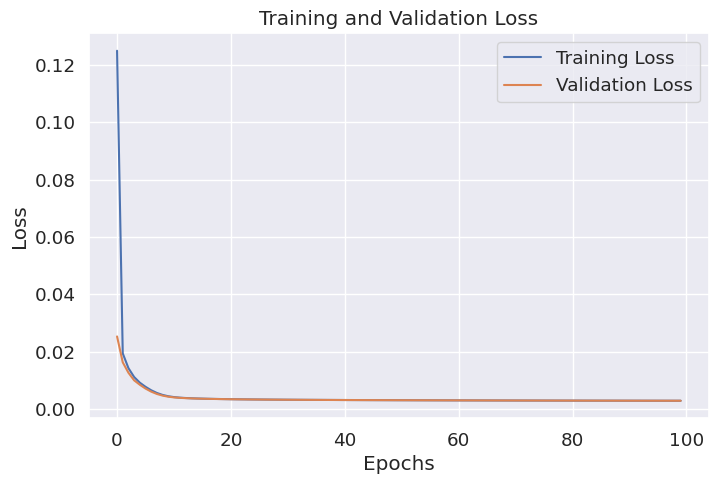

In [445]:
# Plot the loss graph.
# Extract loss and validation loss from the history object
train_loss = history_lstm.history['loss']
val_loss = history_lstm.history['val_loss']

# Generate a range for the number of epochs
epochs = range(len(train_loss))

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
# Saving the figure
# save_path = '../figures/losses_lstm.pdf'
# plt.savefig(save_path)
plt.show()

209/209 - 8s - loss: 0.0030 - root_mean_squared_error: 0.0549 - 8s/epoch - 39ms/step
Test Loss: 0.003008752828463912, Test RMSE: 0.05485209822654724
662/662 [==============================] - 22s 32ms/step
Total inference time for all samples: 22.068696975708008 seconds
Average inference time per sample: 3.2570789900404554e-05 seconds


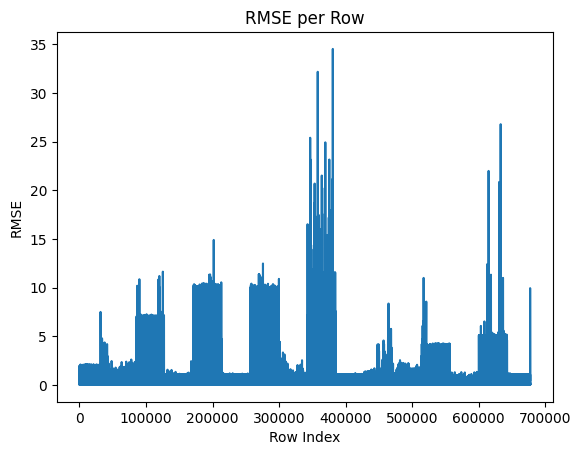

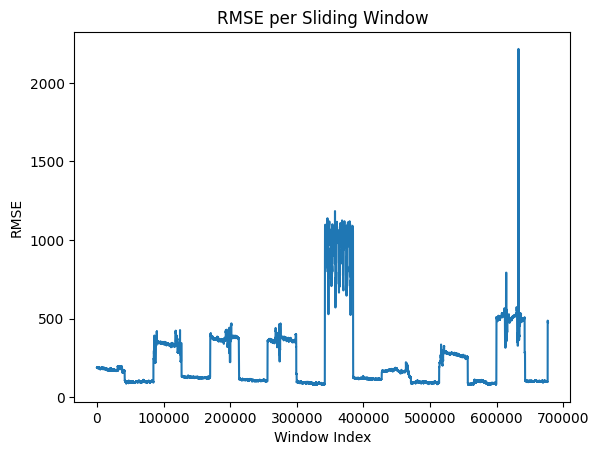

In [29]:
test_loss_lstm, test_rmse_lstm = lstm_model.evaluate(w_lstm.test, verbose=2)
print(f"Test Loss: {test_loss_lstm}, Test RMSE: {test_rmse_lstm}")

# Measure inference time
start_time = time.time()
# Predict anomalous samples
anomalous_predictions = lstm_model.predict(w_lstm.anol)
end_time = time.time()

# Calculate the total inference time
total_inference_time = end_time - start_time

# Number of samples that were actually predicted
# We cannot predict the first 755 = window size
num_predicted_samples = len(nicla_anol) - 755

# Calculate the average inference time per sample
average_inference_time_per_sample = total_inference_time / num_predicted_samples

print(f"Total inference time for all samples: {total_inference_time} seconds")
print(f"Average inference time per sample: {average_inference_time_per_sample} seconds")

# Reshape predictions to 2D so we can scale back.
reshaped_predictions = anomalous_predictions.reshape(-1, 9)

# Inverse transform to original scale
# Assuming scaler_X is your StandardScaler instance
anol_preds = scaler_X.inverse_transform(reshaped_predictions)

# Drop the first 755 rows from nicla_anol to match the shape with anol_preds
adjusted_nicla_anol = nicla_anol[755:]

# Assuming anol_preds and reshaped_predictions are numpy arrays
rmse_per_row = np.sqrt(np.mean(np.square(anol_preds - adjusted_nicla_anol), axis=1))

plt.plot(rmse_per_row)
plt.xlabel('Row Index')
plt.ylabel('RMSE')
plt.title('RMSE per Row')
plt.savefig('/tf/figures/rmse_sliding_windows_lstm.pdf', format='pdf')
plt.show()

window_size = 755
rmse_sliding_sums = np.convolve(rmse_per_row, np.ones(window_size), 'valid')

plt.plot(rmse_sliding_sums)
plt.xlabel('Window Index')
plt.ylabel('RMSE')
plt.title('RMSE per Sliding Window')
plt.savefig('/tf/figures/rmse_final_sliding_windows_lstm.pdf', format='pdf')
plt.show()

In [32]:
# Flatten array to 1D and create binary result
adjusted_labels = nicla_labels_anol[755:].ravel()  
binary_result = np.convolve(adjusted_labels, np.ones(window_size), 'valid') > (755 / 2)
binary_result = binary_result.astype(int)

# Limits to find the threshold
min_rmse = np.min(rmse_sliding_sums)
max_rmse = np.max(rmse_sliding_sums)

# Initialize variables for the best metrics
best_metrics = {'Threshold': None, 'F1': 0, 'Precision': 0, 'Recall': 0, 'Accuracy': 0, 'FPR': 0}
best_predictions = None

# Generate a wide range of thresholds including the initial range and fine-tuning range
for threshold in np.linspace(min_rmse - (max_rmse - min_rmse) / 200, max_rmse + (max_rmse - min_rmse) / 200, 1000):
    predictions = (rmse_sliding_sums > threshold).astype(int)
    f1 = f1_score(binary_result, predictions)
    
    if f1 > best_metrics['F1']:
        tn, fp, fn, tp = confusion_matrix(binary_result, predictions).ravel()
        best_metrics = {
            'Threshold': threshold,
            'F1': f1,
            'Precision': precision_score(binary_result, predictions),
            'Recall': recall_score(binary_result, predictions),
            'Accuracy': accuracy_score(binary_result, predictions),
            'FPR': fp / (fp + tn) if (fp + tn) > 0 else 0
        }
        best_predictions = predictions

# Print the best metrics
print(f"Best Threshold: {best_metrics['Threshold']}")
print(f"Best F1 Score: {best_metrics['F1']}")
print(f"Precision: {best_metrics['Precision']}")
print(f"Recall: {best_metrics['Recall']}")
print(f"Accuracy: {best_metrics['Accuracy']}")
print(f"FPR: {best_metrics['FPR']}")

Best Threshold: 142.65644087228776
Best F1 Score: 0.9888030820110475
Precision: 0.9903477964668296
Recall: 0.9872631788482705
Accuracy: 0.9887146557290335
FPR: 0.009806115173374623


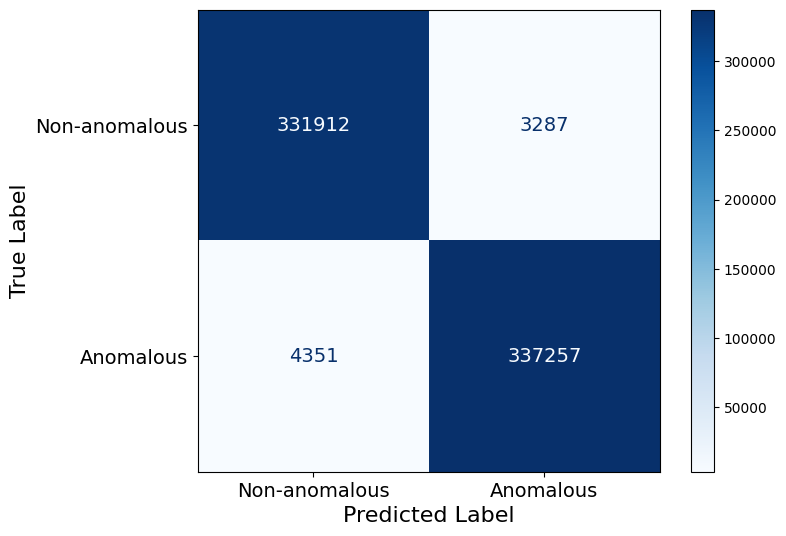

In [33]:
# Plot the confusion matrix for the best threshold
cm = confusion_matrix(binary_result, best_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-anomalous", "Anomalous"])

fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap="Blues", values_format="d")

# Increase font sizes
ax.tick_params(axis='both', labelsize=14)  # For tick labels
for text in disp.text_.ravel():
    text.set_fontsize(14)  # For matrix values
ax.set_xlabel("Predicted Label", fontsize=16)
ax.set_ylabel("True Label", fontsize=16)

# Save the confusion matrix as a PDF
plt.savefig("confusion_matrix_best_threshold_lstm.pdf", format="pdf")
plt.show()

## Dense-AE

In [5]:
# Care for the dropout rate.
@tf.keras.utils.register_keras_serializable()
class AnomalyDetector(Model):
    def __init__(self):
        super(AnomalyDetector, self).__init__()
        # Encoder
        self.encoder = Sequential([
            Flatten(),  # Flatten the input
            Dense(64, activation="relu"),
            Dense(32, activation="relu"),
            Dense(16, activation="relu"),
        ])
        # Decoder
        self.decoder = Sequential([
            Dense(16, activation="relu"),
            Dense(32, activation="relu"),
            Dense(64, activation="relu"),
            Dense(755 * 9, activation="relu"),
            Reshape((755, 9))  # Reshape back to the original shape
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Initialize and compile the model with a lower learning rate
ae_dense = AnomalyDetector()
ae_dense.compile(optimizer=tf.keras.optimizers.Adamax(), loss='mse')

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min', restore_best_weights=True)

# Check if the function is working as expected
first_window_second_timestep = X_train_windows[0][1]  # Second timestep of the first window
second_window_first_timestep = X_train_windows[1][0]  # First timestep of the second window

# Compare these two timesteps
comparison_result = np.array_equal(first_window_second_timestep, second_window_first_timestep)

print("Is the create_windows function working correctly?", comparison_result)

Is the create_windows function working correctly? True


2024-01-20 22:36:08.492238: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46646 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:65:00.0, compute capability: 8.6


In [7]:
# Model training with batch processing
history_dense_ae = ae_dense.fit(
    X_train_windows,
    X_train_target,  # Targets for training data
    epochs=100,
    batch_size=512,  # Adjust batch size as needed
    validation_data=(X_val_windows, X_val_target),
    callbacks=[early_stopping],
    shuffle=False,
    verbose=1
)

Epoch 1/100


2024-01-20 21:28:54.785171: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fec449e4a10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-20 21:28:54.785198: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-01-20 21:28:54.798039: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-01-20 21:28:54.835646: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
I0000 00:00:1705786134.901031 4021707 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1256/1256 [==============================] - 37s 27ms/step - loss: 160.9248 - val_loss: 146.2615
Epoch 2/100
1256/1256 [==============================] - 20s 16ms/step - loss: 145.8614 - val_loss: 145.2051
Epoch 3/100
1256/1256 [==============================] - 20s 16ms/step - loss: 145.0337 - val_loss: 144.4451
Epoch 4/100
1256/1256 [==============================] - 20s 16ms/step - loss: 144.3343 - val_loss: 144.0690
Epoch 5/100
1256/1256 [==============================] - 20s 16ms/step - loss: 144.1857 - val_loss: 143.9584
Epoch 6/100
1256/1256 [==============================] - 20s 16ms/step - loss: 144.0729 - val_loss: 143.5525
Epoch 7/100
1256/1256 [==============================] - 20s 16ms/step - loss: 143.6805 - val_loss: 143.2526
Epoch 8/100
1256/1256 [==============================] - 20s 16ms/step - loss: 143.3983 - val_loss: 143.2039
Epoch 9/100
1256/1256 [==============================] - 20s 16ms/step - loss: 143.3440 - val_loss: 143.1394
Epoch 10/100
1256/1256 [=======

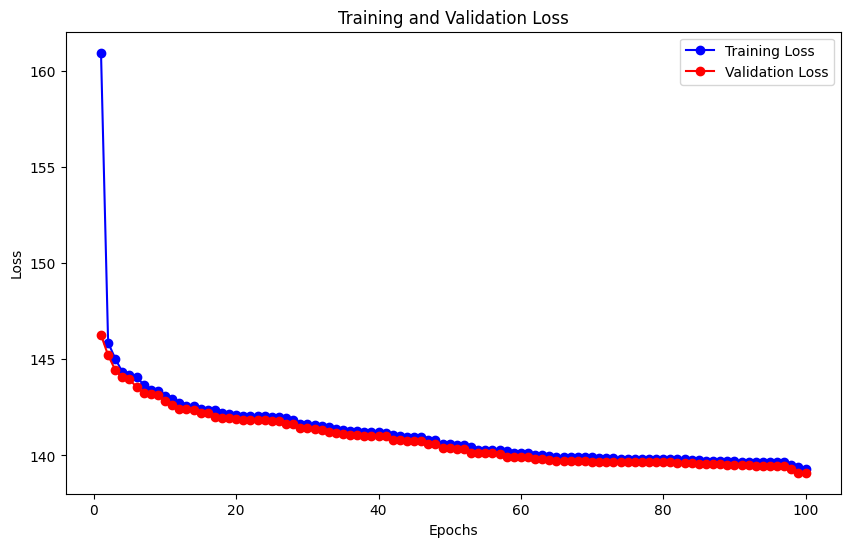

In [8]:
### Extracting loss and validation loss
train_loss_ae_dense = history_dense_ae.history['loss']
val_loss_ae_dense = history_dense_ae.history['val_loss']
epochs = range(1, len(train_loss_ae_dense) + 1)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss_ae_dense, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss_ae_dense, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [6]:
# Save our model just in case.
# ae_dense.save('/tf/models/AE_dense.keras')

# Load from here if kernel died previously
ae_dense = tf.keras.models.load_model('/tf/models/AE_dense.keras', custom_objects={'AnomalyDetector': AnomalyDetector})

In [7]:
def predict_in_chunks(model, data, batch_size):
    reconstructed = []
    inference_times = []
    for i in range(0, len(data), batch_size):
        chunk = data[i:i + batch_size]
        start_time = time.time()  # Start time for the chunk prediction
        reconstructed_chunk = model.predict(chunk, batch_size=batch_size, verbose=0)
        end_time = time.time()  # End time for the chunk prediction
        inference_time = (end_time - start_time) / len(chunk)  # Inference time per sample
        inference_times.append(inference_time)  # Collect per sample inference time for each chunk
        reconstructed.append(reconstructed_chunk)
    average_inference_time_per_sample = np.mean(inference_times)  # Average over all chunks
    return np.concatenate(reconstructed, axis=0), average_inference_time_per_sample

# Use the function to predict and get average inference time per sample
nicla_anol_reconstructed, avg_inf_time_per_sample = predict_in_chunks(ae_dense, X_anol_windows, batch_size=1024)

# Save the nicla_anol_reconstructed array to a file
np.save('/tf/variables/nicla_anol_reconstructed.npy', nicla_anol_reconstructed)

print(f"Average inference time per sample: {avg_inf_time_per_sample} seconds")

# Select half of the samples from the dataset
half_data = X_anol_windows[:len(X_anol_windows) // 2]

# Measure inference time for AE model on half of the samples
start_time = time.time()
# Predict half of the samples
ae_reconstructed_half = ae_dense.predict(half_data)
end_time = time.time()

# Calculate the total inference time
total_inference_time = end_time - start_time

# Calculate the average inference time per sample
average_inference_time_per_sample = total_inference_time / len(half_data)

print(f"Total inference time for half of the AE samples: {total_inference_time} seconds")
print(f"Average inference time per AE sample (half dataset): {average_inference_time_per_sample} seconds")

# Optional: Save the ae_reconstructed_half array to a file
np.save('/tf/variables/ae_reconstructed_half.npy', ae_reconstructed_half)

nicla_anol_reconstructed.shape, nicla_anol_windows.shape, nicla_labels_anol.shape

Average inference time per sample: 0.00011247536119432296 seconds
10587/10587 [==============================] - 38s 4ms/step
Total inference time for half of the AE samples: 59.49341940879822 seconds
Average inference time per AE sample (half dataset): 0.0001756102597512795 seconds


((677562, 755, 9), (677562, 755, 9), (678316, 1))

Length of RMSE array: 677562


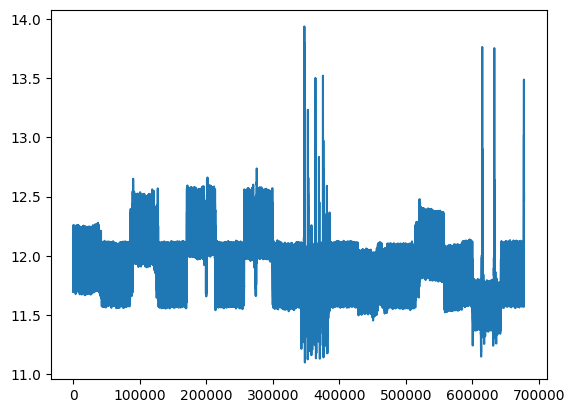

In [8]:
# Calculate MSE for each window
mse_per_window = np.mean((nicla_anol_windows - nicla_anol_reconstructed) ** 2, axis=(1, 2))

# Calculate RMSE for each window
rmse_per_window = np.sqrt(mse_per_window)

# Check the length of the RMSE array to ensure it's 677562
print("Length of RMSE array:", len(rmse_per_window))

plt.plot(rmse_per_window)
plt.show()

In [9]:
# Get labels for windows.
window_size = 755
threshold = window_size / 2
binary_result = np.convolve(nicla_labels_anol.ravel(), np.ones(window_size, dtype=int), 'valid') > threshold
# Convert boolean array to integers (1s and 0s)
binary_result = binary_result.astype(int)

In [16]:
# Limits to find the threshold
min_rmse = np.min(rmse_per_window)
max_rmse = np.max(rmse_per_window)

# Initialize variables for the best metrics
best_metrics = {'Threshold': None, 'F1': 0, 'Precision': 0, 'Recall': 0, 'Accuracy': 0, 'FPR': 0}

# Generate a wide range of thresholds including the initial range and fine-tuning range
for threshold in np.linspace(min_rmse - (max_rmse - min_rmse) / 200, max_rmse + (max_rmse - min_rmse) / 200, 1000):
    predictions = (rmse_per_window > threshold).astype(int)
    f1 = f1_score(binary_result, predictions)
    
    if f1 > best_metrics['F1']:
        tn, fp, fn, tp = confusion_matrix(binary_result, predictions).ravel()
        best_metrics = {
            'Threshold': threshold,
            'F1': f1,
            'Precision': precision_score(binary_result, predictions),
            'Recall': recall_score(binary_result, predictions),
            'Accuracy': accuracy_score(binary_result, predictions),
            'FPR': fp / (fp + tn) if (fp + tn) > 0 else 0
        }

# Print the best metrics
print(f"Best Threshold: {best_metrics['Threshold']}")
print(f"Best F1 Score: {best_metrics['F1']}")
print(f"Precision: {best_metrics['Precision']}")
print(f"Recall: {best_metrics['Recall']}")
print(f"Accuracy: {best_metrics['Accuracy']}")
print(f"FPR: {best_metrics['FPR']}")

Best Threshold: 11.083102240330255
Best F1 Score: 0.6713493639238179
Precision: 0.5052866010785729
Recall: 1.0
Accuracy: 0.5052866010785729
FPR: 1.0


## LSTM - AE

In [8]:
# Set Window_size and features.
WINDOW_SIZE = 755
NUM_FEATURES = 9
NUM_FILTERS = 16

@tf.keras.utils.register_keras_serializable()
class LSTMAutoencoder(Model):
    def __init__(self, timesteps, num_features):
        super(LSTMAutoencoder, self).__init__()
        self.timesteps = timesteps
        self.num_features = num_features

        # Encoder with reduced complexity and added dropout
        self.encoder = Sequential([
            LSTM(NUM_FILTERS, activation='tanh', input_shape=(timesteps, num_features), dropout=0.2)
        ])
        # Decoder with reduced complexity and added dropout
        self.decoder = Sequential([
            RepeatVector(timesteps),
            LSTM(NUM_FILTERS, activation='tanh', return_sequences=True, dropout=0.2),
            Flatten(),  # Flatten the output
            Dense(timesteps * num_features),  # Dense layer to reshape the output
            Reshape((timesteps, num_features))  # Reshape back to the original shape
        ])


    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
# Initialize and compile the LSTM autoencoder
lstm_autoencoder = LSTMAutoencoder(WINDOW_SIZE, NUM_FEATURES)

# Define early stopping and learning rate reduction callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

# lstm_autoencoder.compile(optimizer=RMSprop(learning_rate=0.001), loss='mse')
lstm_autoencoder.compile(optimizer=RMSprop(learning_rate=0.002), loss='mse')

In [5]:
# Train the model and save the history
history_lstm = lstm_autoencoder.fit(
    X_train_windows,
    X_train_target,
    epochs=200,
    batch_size=1024,
    validation_data=(X_val_windows, X_val_target),
    callbacks=[early_stopping, reduce_lr],
    shuffle=False,
    verbose=1
)

Epoch 1/200


2024-01-24 17:22:00.601145: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
2024-01-24 17:22:01.091291: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f2018018480 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-24 17:22:01.091337: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-01-24 17:22:01.102441: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1706116921.185759 2909741 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


628/628 [==============================] - 97s 149ms/step - loss: 69.6720 - val_loss: 46.0939 - lr: 0.0020
Epoch 2/200
628/628 [==============================] - 79s 126ms/step - loss: 43.4427 - val_loss: 29.5426 - lr: 0.0020
Epoch 3/200
628/628 [==============================] - 79s 126ms/step - loss: 28.9902 - val_loss: 20.2941 - lr: 0.0020
Epoch 4/200
628/628 [==============================] - 79s 126ms/step - loss: 19.4305 - val_loss: 12.4986 - lr: 0.0020
Epoch 5/200
628/628 [==============================] - 79s 126ms/step - loss: 13.8893 - val_loss: 12.5522 - lr: 0.0020
Epoch 6/200
628/628 [==============================] - 79s 126ms/step - loss: 21.4630 - val_loss: 15.3939 - lr: 0.0020
Epoch 7/200
628/628 [==============================] - 79s 126ms/step - loss: 11.6504 - val_loss: 11.7478 - lr: 0.0020
Epoch 8/200
628/628 [==============================] - 79s 126ms/step - loss: 9.2997 - val_loss: 11.2213 - lr: 0.0020
Epoch 9/200
628/628 [==============================] - 79s 12

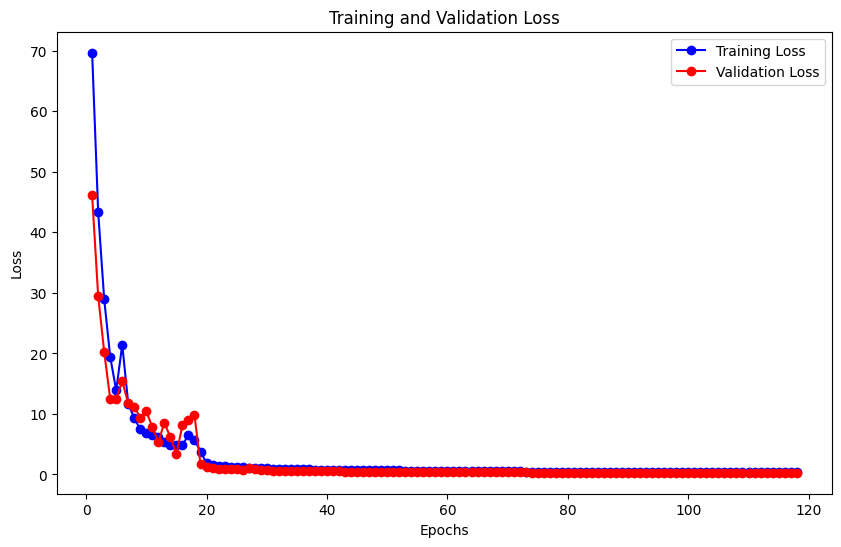

In [6]:
### Extracting loss and validation loss
train_loss_lstm_ae = history_lstm.history['loss']
val_loss_lstm_ae = history_lstm.history['val_loss']
epochs = range(1, len(train_loss_lstm_ae) + 1)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss_lstm_ae, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss_lstm_ae, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/tf/figures/rmse_final_sliding_windows_lstm_ae_model_2.pdf', format='pdf')
plt.show()

Save or load accordingly.

In [12]:
# Save the trained LSTM autoencoder model
# lstm_autoencoder.save('/tf/models/lstm_ae_model_11.keras')
# Load the trained LSTM autoencoder model
# Load the model with a custom object scope
with tf.keras.utils.custom_object_scope({'LSTMAutoencoder': LSTMAutoencoder}):
    lstm_autoencoder = tf.keras.models.load_model('/tf/models/lstm_ae_model_2.keras')

In [10]:
# Calculate the test loss using prepared test data with specified batch size
# test_loss = lstm_autoencoder.evaluate(X_test_windows, X_test_target, batch_size=32, verbose=1)
# print(f"Test Loss: {test_loss}")

In [13]:
def predict_in_chunks(model, data, batch_size):
    reconstructed = []
    inference_times = []
    for i in range(0, len(data), batch_size):
        chunk = data[i:i + batch_size]
        start_time = time.time()  # Start time for the chunk prediction
        reconstructed_chunk = model.predict(chunk, batch_size=batch_size, verbose=0)
        end_time = time.time()  # End time for the chunk prediction
        inference_time = (end_time - start_time) / len(chunk)  # Inference time per sample
        inference_times.append(inference_time)  # Collect per sample inference time for each chunk
        reconstructed.append(reconstructed_chunk)
    average_inference_time_per_sample = np.mean(inference_times)  # Average over all chunks
    return np.concatenate(reconstructed, axis=0), average_inference_time_per_sample

# Use the function to predict and get average inference time per sample
nicla_anol_reconstructed, avg_inf_time_per_sample = predict_in_chunks(lstm_autoencoder, X_anol_windows, batch_size=1024)

print(f"Average inference time per sample: {avg_inf_time_per_sample} seconds")

Average inference time per sample: 0.00014624821455021708 seconds


In [14]:
# # Select half of the samples from the dataset
# half_data = X_anol_windows[:len(X_anol_windows) // 2]

# # Measure inference time for AE model on half of the samples
# start_time = time.time()
# # Predict half of the samples
# ae_lstm_reconstructed_half = lstm_autoencoder.predict(half_data)
# end_time = time.time()

# # Calculate the total inference time
# total_inference_time = end_time - start_time

# # Calculate the average inference time per sample
# average_inference_time_per_sample = total_inference_time / len(half_data)

# print(f"Total inference time for half of the AE samples: {total_inference_time} seconds")
# print(f"Average inference time per AE sample (half dataset): {average_inference_time_per_sample} seconds")

# Calculate MSE for each window
mse_per_window = np.mean((nicla_anol_windows - nicla_anol_reconstructed) ** 2, axis=(1, 2))

# Calculate RMSE for each window
rmse_per_window = np.sqrt(mse_per_window)

# Check the length of the RMSE array to ensure it's 677562
print("Length of RMSE array:", len(rmse_per_window))

# Get labels for windows.
window_size = 755
threshold = window_size / 2
binary_result = np.convolve(nicla_labels_anol.ravel(), np.ones(window_size, dtype=int), 'valid') > threshold
# Convert boolean array to integers (1s and 0s)
binary_result = binary_result.astype(int)

# Limits to find the threshold
min_rmse = np.min(rmse_per_window)
max_rmse = np.max(rmse_per_window)

# Initialize variables for the best metrics
best_metrics = {'Threshold': None, 'F1': 0, 'Precision': 0, 'Recall': 0, 'Accuracy': 0, 'FPR': 0}

# Generate a wide range of thresholds including the initial range and fine-tuning range
for threshold in np.linspace(min_rmse - (max_rmse - min_rmse) / 200, max_rmse + (max_rmse - min_rmse) / 200, 1000):
    predictions = (rmse_per_window > threshold).astype(int)
    f1 = f1_score(binary_result, predictions)
    
    if f1 > best_metrics['F1']:
        tn, fp, fn, tp = confusion_matrix(binary_result, predictions).ravel()
        best_metrics = {
            'Threshold': threshold,
            'F1': f1,
            'Precision': precision_score(binary_result, predictions),
            'Recall': recall_score(binary_result, predictions),
            'Accuracy': accuracy_score(binary_result, predictions),
            'FPR': fp / (fp + tn) if (fp + tn) > 0 else 0
        }

# Print the best metrics
print(f"Best Threshold: {best_metrics['Threshold']}")
print(f"Best F1 Score: {best_metrics['F1']}")
print(f"Precision: {best_metrics['Precision']}")
print(f"Recall: {best_metrics['Recall']}")
print(f"Accuracy: {best_metrics['Accuracy']}")
print(f"FPR: {best_metrics['FPR']}")

Length of RMSE array: 677562
Best Threshold: 1.2483137641371829
Best F1 Score: 0.9300234488802568
Precision: 0.9428844150815401
Recall: 0.9175086092831293
Accuracy: 0.9302351666710943
FPR: 0.05676627913567761


## 1D-CNN AE

In [4]:
@tf.keras.utils.register_keras_serializable()
class CNNAutoencoder(Model):
    def __init__(self, timesteps, num_features, num_filters, conv_width, max_pool_size):
        super(CNNAutoencoder, self).__init__()
        self.timesteps = timesteps
        self.num_features = num_features

        # Encoder
        self.encoder = Sequential([
            Conv1D(num_filters, activation='relu', kernel_size=(conv_width), input_shape=(timesteps, num_features)),
            MaxPooling1D(pool_size=max_pool_size),
            Conv1D(num_filters, activation='relu', kernel_size=(conv_width))
        ])

        # Decoder
        self.decoder = Sequential([
            Conv1D(num_filters, activation='relu', kernel_size=(conv_width)),
            UpSampling1D(size=max_pool_size),
            Conv1D(num_features, activation='relu', kernel_size=(conv_width)),
            Flatten(),
            Dense(timesteps * num_features),
            Reshape((timesteps, num_features))
        ])

    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

def create_windows(data, window_size=755, sliding_number=1):
    num_windows = (data.shape[0] - window_size) // sliding_number + 1
    shape = (num_windows, window_size, data.shape[-1])
    strides = (data.strides[0] * sliding_number, data.strides[0], data.strides[1])
    return np.lib.stride_tricks.as_strided(data, shape=shape, strides=strides)


# Set hyperparameters
window_size = 755
num_features = 9
num_filters = 32
conv_width = 5
max_pool_size = 3

# Initialize and compile the LSTM autoencoder
cnn_autoencoder = CNNAutoencoder(window_size, num_features, num_filters, conv_width,
                                 max_pool_size)

# Define early stopping and learning rate reduction callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

# lstm_autoencoder.compile(optimizer=RMSprop(learning_rate=0.001), loss='mse')
cnn_autoencoder.compile(optimizer=Adamax(learning_rate=0.001), loss='mse')

2024-12-04 20:06:05.434921: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43124 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:65:00.0, compute capability: 8.6


In [5]:
# Train the model and save the history
history_cnn = cnn_autoencoder.fit(
    X_train_windows,
    X_train_target,
    epochs=100,
    batch_size=1024,
    validation_data=(X_val_windows, X_val_target),
    callbacks=[early_stopping, reduce_lr],
    shuffle=False,
    verbose=1
)

Epoch 1/100


2024-01-24 21:08:17.779120: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
2024-01-24 21:08:19.102541: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fd690b84800 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-24 21:08:19.102586: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-01-24 21:08:19.112214: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1706130499.277540 3069002 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


628/628 [==============================] - 54s 78ms/step - loss: 9.5443 - val_loss: 0.3043 - lr: 0.0010
Epoch 2/100
628/628 [==============================] - 33s 52ms/step - loss: 0.2148 - val_loss: 0.1506 - lr: 0.0010
Epoch 3/100
628/628 [==============================] - 33s 52ms/step - loss: 0.1493 - val_loss: 0.1655 - lr: 0.0010
Epoch 4/100
628/628 [==============================] - 33s 53ms/step - loss: 0.1205 - val_loss: 0.1034 - lr: 0.0010
Epoch 5/100
628/628 [==============================] - 33s 52ms/step - loss: 0.1064 - val_loss: 0.0892 - lr: 0.0010
Epoch 6/100
628/628 [==============================] - 33s 52ms/step - loss: 0.0946 - val_loss: 0.0869 - lr: 0.0010
Epoch 7/100
628/628 [==============================] - 33s 52ms/step - loss: 0.0869 - val_loss: 0.0812 - lr: 0.0010
Epoch 8/100
628/628 [==============================] - 33s 53ms/step - loss: 0.0791 - val_loss: 0.0612 - lr: 0.0010
Epoch 9/100
628/628 [==============================] - 33s 53ms/step - loss: 0.0731 

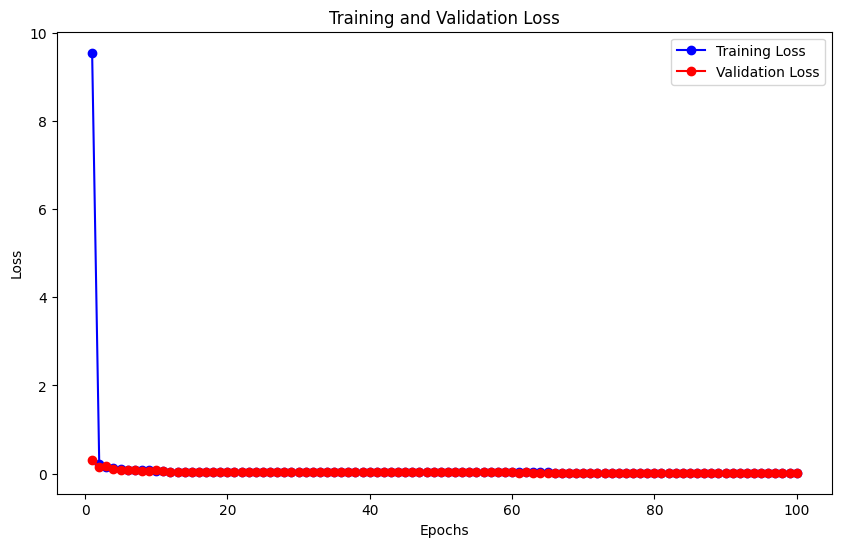

In [6]:
### Extracting loss and validation loss
train_loss_cnn_ae = history_cnn.history['loss']
val_loss_cnn_ae = history_cnn.history['val_loss']
epochs = range(1, len(train_loss_cnn_ae) + 1)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss_cnn_ae, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss_cnn_ae, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/tf/figures/rmse_final_sliding_windows_cnn_Adamax.pdf', format='pdf')
plt.show()

In [5]:
# Save the trained LSTM autoencoder model
# cnn_autoencoder.save('/tf/models/cnn_ae_layers_Adamax.keras')
# Load the trained LSTM autoencoder model
# Load the model with a custom object scope
with tf.keras.utils.custom_object_scope({'CNNAutoencoder': CNNAutoencoder}):
    cnn_autoencoder = tf.keras.models.load_model('/tf/models/cnn_ae_layers_Adamax.keras')

In [6]:
# Calculate the test loss using prepared test data with specified batch size
test_loss = cnn_autoencoder.evaluate(X_test_windows, X_test_target, batch_size=512, verbose=1)
print(f"Test Loss: {test_loss}")

2024-12-04 20:06:39.276787: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906


418/418 [==============================] - 6s 12ms/step - loss: 0.0228
Test Loss: 0.0227653905749321


In [12]:
# Select half of the samples from the dataset
half_data = X_anol_windows[:len(X_anol_windows) // 2]

# Measure inference time for AE model on half of the samples
start_time = time.time()
# Predict half of the samples
ae_cnn_reconstructed_half = cnn_autoencoder.predict(half_data)
end_time = time.time()

# Calculate the total inference time
total_inference_time = end_time - start_time

# Calculate the average inference time per sample
average_inference_time_per_sample = total_inference_time / len(half_data)

print(f"Total inference time for half of the AE samples: {total_inference_time} seconds")
print(f"Average inference time per AE sample (half dataset): {average_inference_time_per_sample} seconds")

10587/10587 [==============================] - 49s 5ms/step
Total inference time for half of the AE samples: 70.87467646598816 seconds
Average inference time per AE sample (half dataset): 0.000209204992210272 seconds


In [7]:
# def predict_in_chunks(model, data, batch_size):
#     reconstructed = []
#     for i in range(0, len(data), batch_size):
#         chunk = data[i:i + batch_size]
#         reconstructed_chunk = model.predict(chunk, batch_size=batch_size, verbose=0)
#         reconstructed.append(reconstructed_chunk)
#     return np.concatenate(reconstructed, axis=0)

# # Use the function to predict
# nicla_anol_reconstructed = predict_in_chunks(cnn_autoencoder, X_anol_windows, batch_size=512)

def predict_in_chunks_safe(model, data, batch_size):
    for i in range(0, len(data), batch_size):
        chunk = data[i:i + batch_size]
        yield model.predict(chunk, batch_size=batch_size, verbose=0)

# Use the function to predict and concatenate lazily
nicla_anol_reconstructed = np.concatenate(
    list(predict_in_chunks_safe(cnn_autoencoder, X_anol_windows, batch_size=128)), axis=0
)

In [8]:
# Function to calculate RMSE in chunks
def calculate_rmse_in_chunks(windows, reconstructed, chunk_size):
    rmse_chunks = []
    for i in range(0, len(windows), chunk_size):
        window_chunk = windows[i:i + chunk_size]
        reconstructed_chunk = reconstructed[i:i + chunk_size]
        mse_chunk = np.mean((window_chunk - reconstructed_chunk) ** 2, axis=(1, 2))
        rmse_chunk = np.sqrt(mse_chunk)
        rmse_chunks.append(rmse_chunk)
    return np.concatenate(rmse_chunks, axis=0)

# Calculate RMSE in chunks
chunk_size = 10000  # Adjust chunk size to fit your RAM capacity
rmse_per_window = calculate_rmse_in_chunks(nicla_anol_windows, nicla_anol_reconstructed, chunk_size)

# Check the length
print("Length of RMSE array:", len(rmse_per_window))

Length of RMSE array: 677562


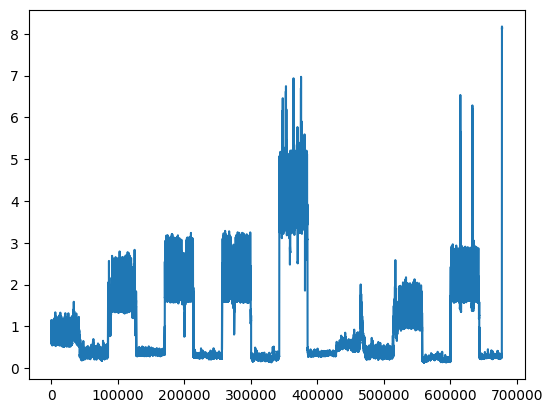

In [9]:
plt.plot(rmse_per_window)
plt.show()

In [13]:
# Get labels for windows.
window_size = 755
threshold = window_size / 2
binary_result = np.convolve(nicla_labels_anol.ravel(), np.ones(window_size, dtype=int), 'valid') > threshold
# Convert boolean array to integers (1s and 0s)
binary_result = binary_result.astype(int)

# Limits to find the threshold
min_rmse = np.min(rmse_per_window)
max_rmse = np.max(rmse_per_window)

# Initialize variables for the best metrics
best_metrics = {'Threshold': None, 'F1': 0, 'Precision': 0, 'Recall': 0, 'Accuracy': 0, 'FPR': 0}
best_predictions = None

# Generate a wide range of thresholds including the initial range and fine-tuning range
for threshold in np.linspace(min_rmse - (max_rmse - min_rmse) / 200, max_rmse + (max_rmse - min_rmse) / 200, 1000):
    predictions = (rmse_per_window > threshold).astype(int)
    f1 = f1_score(binary_result, predictions)
    
    if f1 > best_metrics['F1']:
        tn, fp, fn, tp = confusion_matrix(binary_result, predictions).ravel()
        best_metrics = {
            'Threshold': threshold,
            'F1': f1,
            'Precision': precision_score(binary_result, predictions),
            'Recall': recall_score(binary_result, predictions),
            'Accuracy': accuracy_score(binary_result, predictions),
            'FPR': fp / (fp + tn) if (fp + tn) > 0 else 0
        }
        best_predictions = predictions

# Print the best metrics
print(f"Best Threshold: {best_metrics['Threshold']}")
print(f"Best F1 Score: {best_metrics['F1']}")
print(f"Precision: {best_metrics['Precision']}")
print(f"Recall: {best_metrics['Recall']}")
print(f"Accuracy: {best_metrics['Accuracy']}")
print(f"FPR: {best_metrics['FPR']}")

Best Threshold: 0.46037828576511813
Best F1 Score: 0.9807400317591526
Precision: 0.9739056802668188
Recall: 0.9876709808010795
Accuracy: 0.9803988417296129
FPR: 0.027028720252745383


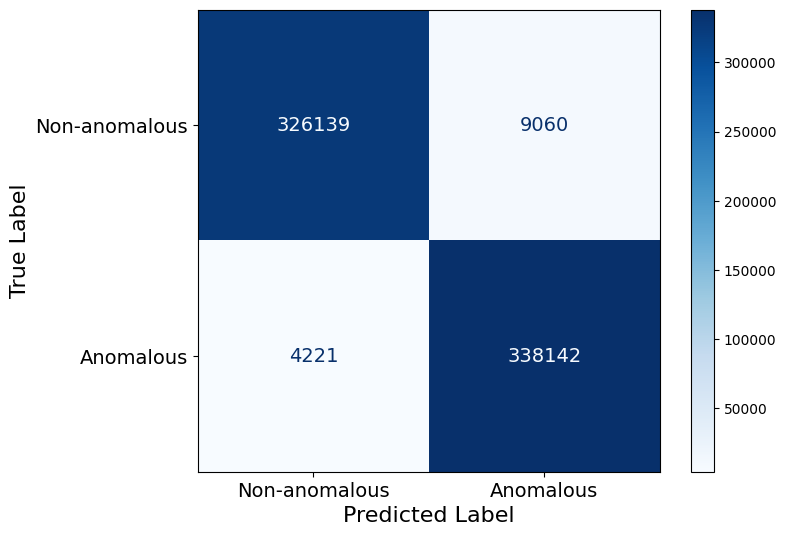

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score, accuracy_score
# Plot the confusion matrix for the best threshold
cm = confusion_matrix(binary_result, best_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-anomalous", "Anomalous"])

fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap="Blues", values_format="d")

# Increase font sizes
ax.tick_params(axis='both', labelsize=14)  # For tick labels
for text in disp.text_.ravel():
    text.set_fontsize(14)  # For matrix values
ax.set_xlabel("Predicted Label", fontsize=16)
ax.set_ylabel("True Label", fontsize=16)

# Save the confusion matrix as a PDF
plt.savefig("confusion_matrix_rmse_windows_1D_CNN_AE.pdf", format="pdf")
plt.show()

## XGBoost

In [4]:
# Define a function to create a dataset with rolling windows
def create_dataset(data, window_size, step=1):
    X, y = [], []
    for i in range(0, len(data) - window_size - step + 1, step):
        X.append(data[i:(i + window_size)])  # Window of observations
        y.append(data[i + window_size])      # Next observation as target
    return np.array(X), np.array(y)

# Load the arrays: normal, and anomalous data, and labels.
nicla_nor = np.load('/tf/variables/nicla_nor.npy')
nicla_anol = np.load('/tf/variables/nicla_anol.npy')
nicla_labels_anol = np.load('/tf/variables/nicla_labels_anol.npy')

# Reduce the size of normal data to 10%.
# As we confirmed it generates the same results.
total_length = int(nicla_nor.shape[0] * 0.1)
train_end = int(total_length * 0.6)
val_end = train_end + int(total_length * 0.2)

# Split the reduced data (10% of original)
reduced_nor_data = nicla_nor[:total_length]
train_data = reduced_nor_data[:train_end]
validation_data = reduced_nor_data[train_end:val_end]
test_data = reduced_nor_data[val_end:]

# Scaling.
scaler_X = StandardScaler().fit(train_data)
X_train = scaler_X.transform(train_data)
X_val = scaler_X.transform(validation_data)
X_test = scaler_X.transform(test_data)
X_anol = scaler_X.transform(nicla_anol)

# Split the data into input and target using the window size of 755.
window_size = 755
X_train, y_train = create_dataset(X_train, window_size=window_size)
X_val, y_val = create_dataset(X_val, window_size=window_size)
X_test, y_test = create_dataset(X_test, window_size=window_size)
X_anol, y_anol = create_dataset(X_anol, window_size=window_size)

In [5]:
# Flatten the input data
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Initialize XGBoost regressor and fit.
xgb_model = xgb.XGBRegressor(objective ='reg:squarederror', n_estimators=100, 
                             max_depth=3, seed=42).fit(X_train_flat, y_train)

# Predict on validation set
y_val_pred = xgb_model.predict(X_val_flat)

# Calculate RMSE
rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred))
print(f"Validation RMSE: {rmse_val}")

Validation RMSE: 0.0615445415588842


We save the model, just in case. Save or load the model, depends on your needs.

In [6]:
# Save the model
xgb_model.save_model('/tf/variables/xgb_model.json')
# Load the model
# loaded_model = xgb.XGBRegressor()
# loaded_model.load_model('xgb_model.json')

In [7]:
# Assuming X_anol is already loaded and preprocessed
X_anol_flat = X_anol.reshape(X_anol.shape[0], -1)

# Start the timer
start_time = time.time()

# Predict on the anomalous dataset
y_anol_pred_inv = scaler_X.inverse_transform(xgb_model.predict(X_anol_flat))

# Stop the timer
end_time = time.time()

# Calculate the total inference time
total_inference_time = end_time - start_time

# Calculate the average inference time per sample
average_inference_time_per_sample = total_inference_time / len(X_anol_flat)
print(f"Total inference time: {total_inference_time} seconds")
print(f"Average inference time per sample: {average_inference_time_per_sample} seconds")

Total inference time: 3.5758216381073 seconds
Average inference time per sample: 5.277490348628831e-06 seconds


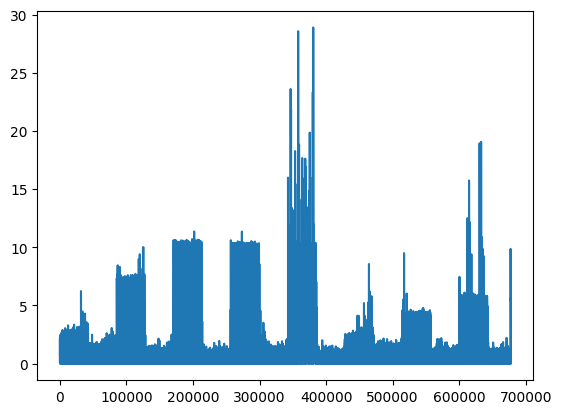

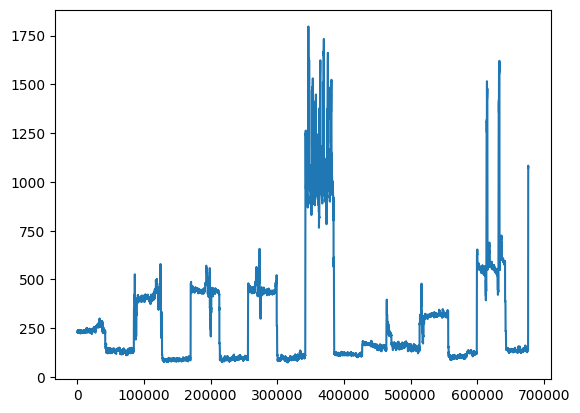

In [9]:
rmse_per_timestep = np.sqrt(np.mean((nicla_anol[window_size:] - y_anol_pred_inv) ** 2, axis=1))
plt.plot(rmse_per_timestep)
plt.show()

window_size = 755
rmse_sliding_sums = np.convolve(rmse_per_timestep, np.ones(window_size), 'valid')
plt.plot(rmse_sliding_sums)
plt.show()

In [13]:
# Flatten array to 1D and create binary result
adjusted_labels = nicla_labels_anol[755:].ravel()  
binary_result = np.convolve(adjusted_labels, np.ones(window_size), 'valid') > (755 / 2)
binary_result = binary_result.astype(int)

print(f"The length of the labels: {len(binary_result)}")
print(f"The length of the windows: {len(rmse_sliding_sums)}")

# Limits to find the threshold
min_rmse = np.min(rmse_sliding_sums)
max_rmse = np.max(rmse_sliding_sums)

print(f"The min_rmse: {min_rmse}")
print(f"The max_rmse: {max_rmse}")

The length of the labels: 676807
The length of the windows: 676807
The min_rmse: 74.396654311271
The max_rmse: 1796.8232060089258


In [15]:
# Initialize variables for the best metrics
best_metrics = {'Threshold': None, 'F1': 0, 'Precision': 0, 'Recall': 0, 'Accuracy': 0, 'FPR': 0}

# Generate a wide range of thresholds including the initial range and fine-tuning range
for threshold in np.linspace(min_rmse - (max_rmse - min_rmse) / 200, max_rmse + (max_rmse - min_rmse) / 200, 2000):
    predictions = (rmse_sliding_sums > threshold).astype(int)
    f1 = f1_score(binary_result, predictions)
    
    if f1 > best_metrics['F1']:
        tn, fp, fn, tp = confusion_matrix(binary_result, predictions).ravel()
        best_metrics = {
            'Threshold': threshold,
            'F1': f1,
            'Precision': precision_score(binary_result, predictions),
            'Recall': recall_score(binary_result, predictions),
            'Accuracy': accuracy_score(binary_result, predictions),
            'FPR': fp / (fp + tn) if (fp + tn) > 0 else 0
        }

# Print the best metrics
print(f"Best Threshold: {best_metrics['Threshold']}")
print(f"Best F1 Score: {best_metrics['F1']}")
print(f"Precision: {best_metrics['Precision']}")
print(f"Recall: {best_metrics['Recall']}")
print(f"Accuracy: {best_metrics['Accuracy']}")
print(f"FPR: {best_metrics['FPR']}")

Best Threshold: 164.12396244585594
Best F1 Score: 0.9432027234693352
Precision: 0.9476636121593229
Recall: 0.9387836350436758
Accuracy: 0.9429335098484501
FPR: 0.05283726980092423


# USE CASE 2

## Quaternion Analysis

In [20]:
# Generate quaternion dataframe, perform initial checks.
# If local the path:
data_path = "/tf/datasets/quaternions_20Hz.csv"

# Generate the dataframe
dataset = pd.read_csv(data_path, on_bad_lines='warn', skiprows=0)

# Check if there are any empty/Nan variables. 
if dataset.isnull().values.any():
    raise ValueError("Nan variable is present.")
    
# Explore the dataframe.
print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1798266 entries, 0 to 1798265
Data columns (total 6 columns):
 #   Column  Dtype  
---  ------  -----  
 0   name    object 
 1   time    int64  
 2   qW      float64
 3   qX      float64
 4   qY      float64
 5   qZ      float64
dtypes: float64(4), int64(1), object(1)
memory usage: 82.3+ MB
None


We visualize the **first 1000 points**.

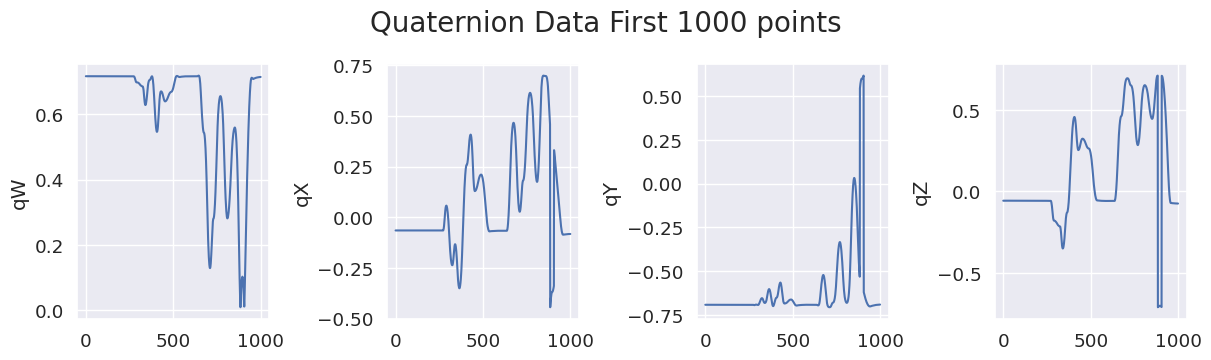

In [21]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharex = True, figsize=(12, 3), constrained_layout=True)

start_index = 0
end_index = 1000

ax1.plot(dataset.index[start_index:end_index], dataset['qW'][start_index:end_index])
ax1.set_ylabel('qW')

ax2.plot(dataset.index[start_index:end_index], dataset['qX'][start_index:end_index])
ax2.set_ylabel('qX')

ax3.plot(dataset.index[start_index:end_index], dataset['qY'][start_index:end_index])
ax3.set_ylabel('qY')

ax4.plot(dataset.index[start_index:end_index], dataset['qZ'][start_index:end_index])
ax4.set_ylabel('qZ')

fig.align_labels()
plt.suptitle("Quaternion Data First 1000 points", x = 0.5, y = 1.15, fontsize = 20)
plt.show()

The Nicla starts generating quaternion data just **before** the arm operates. Thus, we remove the some of the **idle** bit that occcurs.

So, we remove the first **100** data points.

In [22]:
# Drop the first 131 points.
dataset_dropped = dataset.iloc[100:]
# Reset the index.
dataset_dropped.index = pd.RangeIndex(len(dataset_dropped.index))

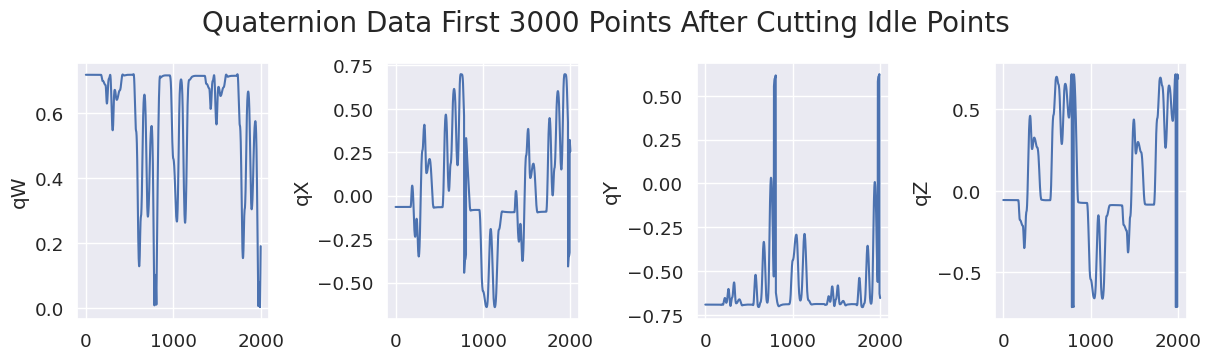

In [23]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharex = True, figsize=(12, 3), constrained_layout=True)

start_index = 0
end_index = 2000

ax1.plot(dataset_dropped.index[start_index:end_index], dataset_dropped['qW'][start_index:end_index])
ax1.set_ylabel('qW')

ax2.plot(dataset_dropped.index[start_index:end_index], dataset_dropped['qX'][start_index:end_index])
ax2.set_ylabel('qX')

ax3.plot(dataset_dropped.index[start_index:end_index], dataset_dropped['qY'][start_index:end_index])
ax3.set_ylabel('qY')

ax4.plot(dataset_dropped.index[start_index:end_index], dataset_dropped['qZ'][start_index:end_index])
ax4.set_ylabel('qZ')

fig.align_labels()
plt.suptitle("Quaternion Data First 3000 Points After Cutting Idle Points", x = 0.5, y = 1.15, fontsize = 20)
plt.show()

### Quaternion-Correlation Analysis

First, we analyze how features correlate with each other.

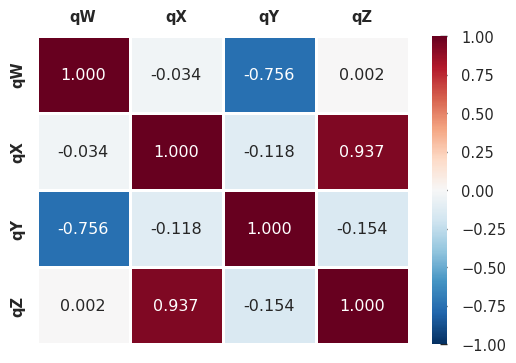

In [24]:
# Split the features to single arrays.
qW = dataset_dropped['qW'].values
qX = dataset_dropped['qX'].values
qY = dataset_dropped['qY'].values
qZ = dataset_dropped['qZ'].values

## Correlation Analysis
def cal_corr(arr):
    """
    Calculates the pearson correlation coefficient of given numpy arrays.
    Args:
        arr (list): A list containing numpy arrays.
    Returns:
        numpy_ndarray: A matrix that contains correlation coefficients.
    """
    corr_matrix = np.corrcoef(arr)
    return corr_matrix

# Set tick labels.
tick_labels = ["qW", "qX", "qY", "qZ"]

# Check how input features correlate with each other.
corr_mat = cal_corr([qW, qX, qY, qZ])

plt.figure(figsize=(6, 4))
# with sns.plotting_context(rc={font_scale=1.2}):
with sns.plotting_context("paper", font_scale=1.2):
    ax = sns.heatmap(corr_mat, cmap='RdBu_r', annot=True, linewidths=1, vmin=-1, 
                     square=False, cbar=True, fmt='.3f', annot_kws={"fontweight": "light"},
                     xticklabels=tick_labels, yticklabels=tick_labels)

    # Get the colorbar object.
    cbar = ax.collections[0].colorbar
    # Set the location of the colorbar ticks to the right.
    cbar.ax.yaxis.set_tick_params(pad=10, direction='in', labelright=True, labelleft=False)

    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False, labeltop=True)
    ax.set_xticklabels(ax.get_xticklabels(), fontweight='bold')
    ax.set_yticklabels(ax.get_yticklabels(), fontweight='bold')
    plt.savefig('/tf/figures/corr_heatmap_IMU_useCase2.pdf', dpi=300, bbox_inches='tight', transparent=True)
    plt.show()

Based on the above matrix, **qY** and **qW** highly correlate. Correlated features are undesired as the neural network wastes resources trying to learn redundant information overfitting due to possibility of favouring one feauture over the another.

### Quaternion - Autocorrelation Analysis

In [25]:
%%time
# Find autocorrelation example.
def df_autocorr(df, lag=1, axis=0):
    """
    Compute the full-sample column-wise autocorrelation for a DataFrame.

    Parameters:
    -----------
    df : pandas.DataFrame
        The input DataFrame.
    lag : int, optional (default=1)
        The lag at which to compute the autocorrelation.
    axis : int, optional (default=0)
        The axis along which to compute the autocorrelation.

    Returns:
    --------
    pandas.Series
        A Series containing the autocorrelation coefficients for each column of the input DataFrame.
    """
    return df.apply(lambda col: col.autocorr(lag), axis=axis)

def df_rolling_autocorr(df, window, lag=1):
    """
    Compute the rolling column-wise autocorrelation for a DataFrame.

    Parameters:
    -----------
    df : pandas.DataFrame
        The input DataFrame.
    window : int
        The size of the rolling window.
    lag : int, optional (default=1)
        The lag at which to compute the autocorrelation.

    Returns:
    --------
    pandas.DataFrame
        A DataFrame containing the rolling autocorrelation coefficients for each column of the input DataFrame.
    """

    return (df.rolling(window=window)
        .corr(df.shift(lag)))

def df_autocorr_highest(df, window_min, window_max, lag_f):
    """
    Compute the highest mean correlation with respect to window length for each column of a DataFrame.

    Parameters:
    -----------
    df : pandas.DataFrame
        The input DataFrame.
    window_min : int
        The minimum window size to consider.
    window_max : int
        The maximum window size to consider.
    lag_f : int
        The lag at which to compute the autocorrelation.

    Returns:
    --------
    pandas.DataFrame
        A DataFrame containing the highest mean correlation and corresponding window size for each column of the input DataFrame.
    """
    df_corrs = pd.DataFrame()
    df_corr_dict = {}
    for i in range(len(df.columns)):
        corr_init = 0
        corr_index = 0
        for j in range(window_min, window_max): 
            corr = df_rolling_autocorr(df.iloc[:,i], window=j, lag=lag_f).dropna().mean()
            if corr > corr_init:
                corr_init = corr
                corr_index = j
        corr_label = df.columns[i] + "_corr"    
        df_corrs[corr_label] = [corr_init, corr_index]
        df_corr_dict[corr_label] = [corr_init, corr_index]
    return df_corr_dict

# Find the index where data autocorrelate.
# We use just a bit of the dataset to save computing time.
# dataset_dropped.iloc[:20000, 2:] -> we do not include the timestamp and measurement name.
# We've found the best point (954) via grid search.
dataset_corr = dataset_dropped.iloc[20000:40000, 2:6]
corr = df_autocorr_highest(dataset_corr, 1200, 1201, 1)
pprint(corr)

{'qW_corr': [0.9990662630885013, 1200],
 'qX_corr': [0.9756370948608882, 1200],
 'qY_corr': [0.9991081216930066, 1200],
 'qZ_corr': [0.9801827433795577, 1200]}
CPU times: user 13.3 ms, sys: 151 ms, total: 165 ms
Wall time: 177 ms


In [26]:
# Find the freq. via analyzing the timestamp column.
avg_time_diff = dataset_dropped['time'].diff().mean()
print(f"The time diff between two consecutive points {avg_time_diff/1000000} miliseconds.")

The time diff between two consecutive points 50.07493250063259 miliseconds.


So, we've confirmed that the the freq. of data is **20Hz**. We see that features correlate around **1200 datapoints**. This means that our period is **1200/20 = 60 seconds.**

We remove the **timestamp** and name **columns** as they are not needed.

In [27]:
# Remove columns by their names
drops = ['name', 'time']
df = dataset_dropped.drop(columns=drops)

We also remove the data after **24 hours** which corresponds to **1728000** data points.

In [28]:
# Find the data length.
df = df[:1728000]
print(f"The dataframe length is {len(df)}")

The dataframe length is 1728000


1728000 corresponds to a 24 hour data gathered at 20 Hz. We visualize to see **periodicity**.

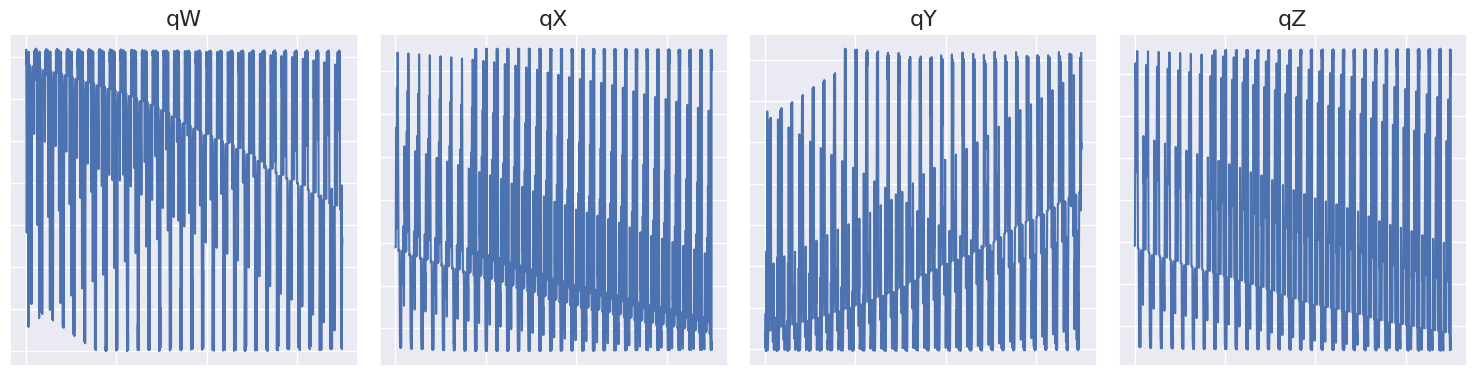

In [29]:
# Plotted subset.
start_index = 10000
end_index = 45000
subset = df[start_index:end_index]

# Create a figure with subplots.
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15, 4))

# Plot each column in a separate subplot.
columns = ['qW', 'qX', 'qY', 'qZ']  # Replace with the actual column names
for i, column in enumerate(columns):
    ax = axes[i]
    ax.plot(subset.index, subset[column])
    # ax.set_xlabel(columns[i])
    # ax.set_ylabel(column)
    ax.set_title(column, fontsize=16)
    ax.tick_params(labelleft=False, labelbottom=False)

# Adjust spacing between subplots.
plt.tight_layout()

# Save the figure.
fig.savefig("/tf/figures/quaternionDrift.pdf", dpi=300, bbox_inches='tight', transparent=True)

# Show the plot
plt.show()

Here we identify **two key** things:
- The quaternion data generated from Nicla are subjected to initial drift.
- The quaternion features do not show the periodicity.

One reason for this might be the noise or more deep analysis required to identify the reasoning. 

Now we will have a look at the **IMU data** generated from the same edge device (Nicla).

In [30]:
# Generate quaternion dataframe, perform initial checks.
# If local the path:
# data_path_IMU = "./datasets/IMU_20Hz_freq_drop_2.csv" # Freq Drop 2.
data_path_IMU = "/tf/datasets/IMU_20Hz_freq_drop.csv" # Freq Drop.

# Generate the dataframe
dataset_IMU = pd.read_csv(data_path_IMU, on_bad_lines='warn', skiprows=range(1, 100))

# Check if there are any empty/Nan variables. 
if dataset_IMU.isnull().values.any():
    raise ValueError("Nan variable is present.")
    
# Explore the dataframe.
print(dataset_IMU.info())

# Calculate the frequency of data.
avg_time_diff_imu = dataset_IMU['time'].diff().mean()
print(f"The time diff between two consecutive points {avg_time_diff_imu/1000000} miliseconds.")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1076923 entries, 0 to 1076922
Data columns (total 11 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   name    1076923 non-null  object 
 1   time    1076923 non-null  int64  
 2   accX    1076923 non-null  float64
 3   accY    1076923 non-null  float64
 4   accZ    1076923 non-null  float64
 5   gyroX   1076923 non-null  float64
 6   gyroY   1076923 non-null  float64
 7   gyroZ   1076923 non-null  float64
 8   magX    1076923 non-null  float64
 9   magY    1076923 non-null  float64
 10  magZ    1076923 non-null  float64
dtypes: float64(9), int64(1), object(1)
memory usage: 90.4+ MB
None
The time diff between two consecutive points 82.39863332720475 miliseconds.


Now, we know that data are gathered at **12.13Hz** which means around **12.13 data points in 1 second** which is unexpected as we set the sampling rate to **20Hz**.

Let's visualize to see **if drift exists in IMU** data as well.

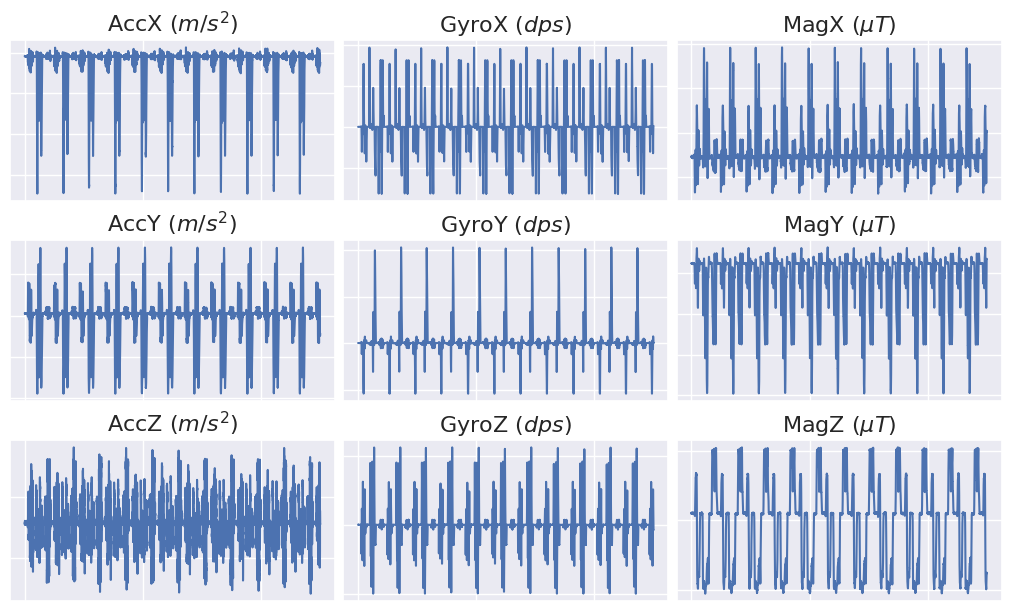

In [31]:
# Here we drop name and time columns.
df_IMU = dataset_IMU.drop(columns=drops)

# Visualize the first 2500 point
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, sharex = True, figsize=(10, 6), constrained_layout=True)

start_index = 10000
end_index = 22500

ax1.plot(df_IMU.index[start_index:end_index], df_IMU['accX'][start_index:end_index])
ax1.set_title(r'AccX $(m/s^2)$', fontsize=16)
ax1.tick_params(labelleft=False, labelbottom=False)

ax2.plot(df_IMU.index[start_index:end_index], df_IMU['gyroX'][start_index:end_index])
ax2.set_title(r'GyroX $(dps)$', fontsize=16)
ax2.tick_params(labelleft=False, labelbottom=False)

ax3.plot(df_IMU.index[start_index:end_index], df_IMU['magX'][start_index:end_index])
ax3.set_title(r'MagX (${\mu}T$)', fontsize=16)
ax3.tick_params(labelleft=False, labelbottom=False)

ax4.plot(df_IMU.index[start_index:end_index], df_IMU['accY'][start_index:end_index])
ax4.set_title(r'AccY $(m/s^2)$', fontsize=16)
ax4.tick_params(labelleft=False, labelbottom=False)

ax5.plot(df_IMU.index[start_index:end_index], df_IMU['gyroY'][start_index:end_index])
ax5.set_title(r'GyroY $(dps)$', fontsize=16)
ax5.tick_params(labelleft=False, labelbottom=False)

ax6.plot(df_IMU.index[start_index:end_index], df_IMU['magY'][start_index:end_index])
ax6.set_title(r'MagY (${\mu}T$)', fontsize=16)
ax6.tick_params(labelleft=False, labelbottom=False)

ax7.plot(df_IMU.index[start_index:end_index], df_IMU['accZ'][start_index:end_index])
ax7.set_title(r'AccZ $(m/s^2)$', fontsize=16)
ax7.tick_params(labelleft=False, labelbottom=False)

ax8.plot(df_IMU.index[start_index:end_index], df_IMU['gyroZ'][start_index:end_index])
ax8.set_title(r'GyroZ $(dps)$', fontsize=16)
ax8.tick_params(labelleft=False, labelbottom=False)

ax9.plot(df_IMU.index[start_index:end_index], df_IMU['magZ'][start_index:end_index])
ax9.set_title(r'MagZ (${\mu}T$)', fontsize=16)
ax9.tick_params(labelleft=False, labelbottom=False)

fig.align_labels()
# plt.suptitle("Nicla IMU Data First 10000 points", x = 0.5, y = 1.05, fontsize = 20)

# Save the figure.
fig.savefig("/tf/figures/IMU_Data_no_drift.pdf", dpi=300, bbox_inches='tight', transparent=True)

plt.show()

In [32]:
# Split the features to single arrays.
np_accX = df_IMU.iloc[:, 0]
np_accY = df_IMU.iloc[:, 1]
np_accZ = df_IMU.iloc[:, 2]
np_gyroX = df_IMU.iloc[:, 3]
np_gyroY = df_IMU.iloc[:, 4]
np_gyroZ = df_IMU.iloc[:, 5]
np_magX = df_IMU.iloc[:, 6]
np_magY = df_IMU.iloc[:, 7]
np_magZ = df_IMU.iloc[:, 8]

# Combine the features per modality.
np_acc = np.stack([np_accX, np_accY, np_accZ], axis=1)
np_gyro = np.stack([np_gyroX, np_gyroY, np_gyroZ], axis=1)
np_mag = np.stack([np_magX, np_magY, np_magZ], axis=1)

In [33]:
%%time
# We know our data at roughly 2Hz.
s_period = 1 / 2
mad_fil = Madgwick(sample_period=s_period)
mah_fil = Mahony(sample_period=s_period)

# Set the identity quaternion, so we accept as zero rotation.
q_madgwick = np.empty((len(np_acc), 4))
q_mahony = np.empty((len(np_acc), 4))
q_madgwick[0] = np.array([1.0, 0.0, 0.0, 0.0])
q_mahony[0] = np.array([1.0, 0.0, 0.0, 0.0])

# Calculate quaternions.
for i in range(1, len(np_acc)):
    q_madgwick[i] = mad_fil.updateMARG(q_madgwick[i-1], acc=np_acc[i-1], gyr=np_gyro[i-1], mag=np_mag[i-1])
    q_mahony[i] = mah_fil.updateMARG(q_mahony[i-1], acc=np_acc[i-1], gyr=np_gyro[i-1], mag=np_mag[i-1])
    
print(f"The length of Madgwick quaternions: {len(q_madgwick)}")
print(f"The length of Mahony quaternions: {len(q_mahony)}")

The length of Madgwick quaternions: 1076923
The length of Mahony quaternions: 1076923
CPU times: user 2min 16s, sys: 14 ms, total: 2min 16s
Wall time: 2min 16s


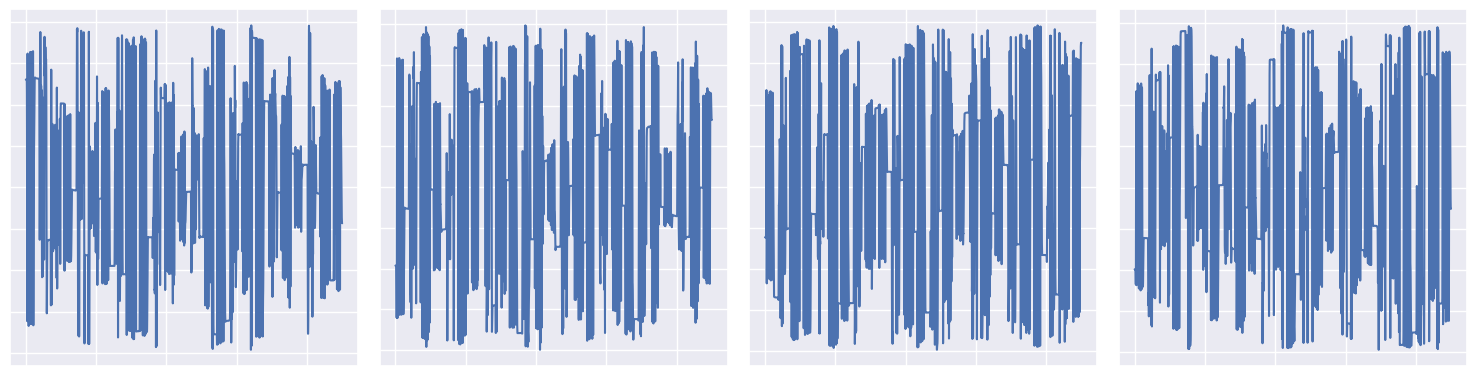

In [34]:
# Plotted subset.
start_index = 1000
end_index = 10000
subset = q_madgwick[start_index:end_index, :]

# Create a figure with subplots.
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15, 4))

# Plot each column in a separate subplot.
columns = ['qW', 'qX', 'qY', 'qZ']  # Replace with the actual column names
for i, column in enumerate(columns):
    ax = axes[i]
    ax.plot(subset[:, i])
    # ax.set_xlabel(columns[i])
    # ax.set_ylabel(column)
    ax.tick_params(labelleft=False, labelbottom=False)

# Adjust spacing between subplots.
plt.tight_layout()

# Save the figure.
# fig.savefig("figures/quaternionDrift.pdf", dpi=300, bbox_inches='tight', transparent=True)

# Show the plot
plt.show()

Now, the Mahony.

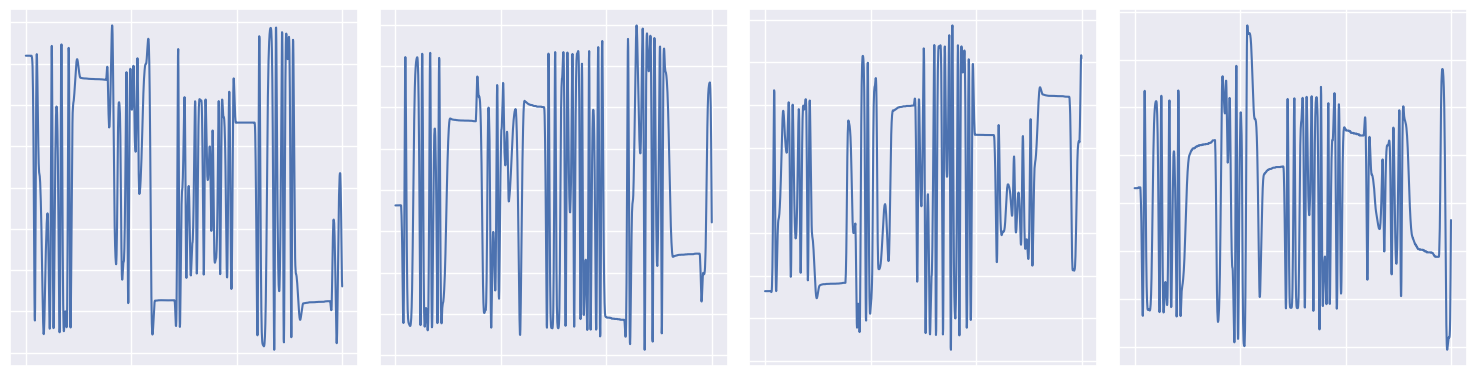

In [35]:
# Plotted subset.
start_index = 1000
end_index = 2500
subset = q_mahony[start_index:end_index, :]

# Create a figure with subplots.
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15, 4))

# Plot each column in a separate subplot.
columns = ['qW', 'qX', 'qY', 'qZ']  # Replace with the actual column names
for i, column in enumerate(columns):
    ax = axes[i]
    ax.plot(subset[:, i])
    # ax.set_xlabel(columns[i])
    # ax.set_ylabel(column)
    ax.tick_params(labelleft=False, labelbottom=False)

# Adjust spacing between subplots.
plt.tight_layout()

# Save the figure.
# fig.savefig("figures/quaternionDrift.pdf", dpi=300, bbox_inches='tight', transparent=True)

# Show the plot
plt.show()

We see that the quaternions generated via Python library does not show the oscillatory behavior. This confirms the problem of generating quaternions via proprietary library of Nicla.

Hence, we will be using IMU data only from now on.

Now we analyze **how IMU data correlates**.

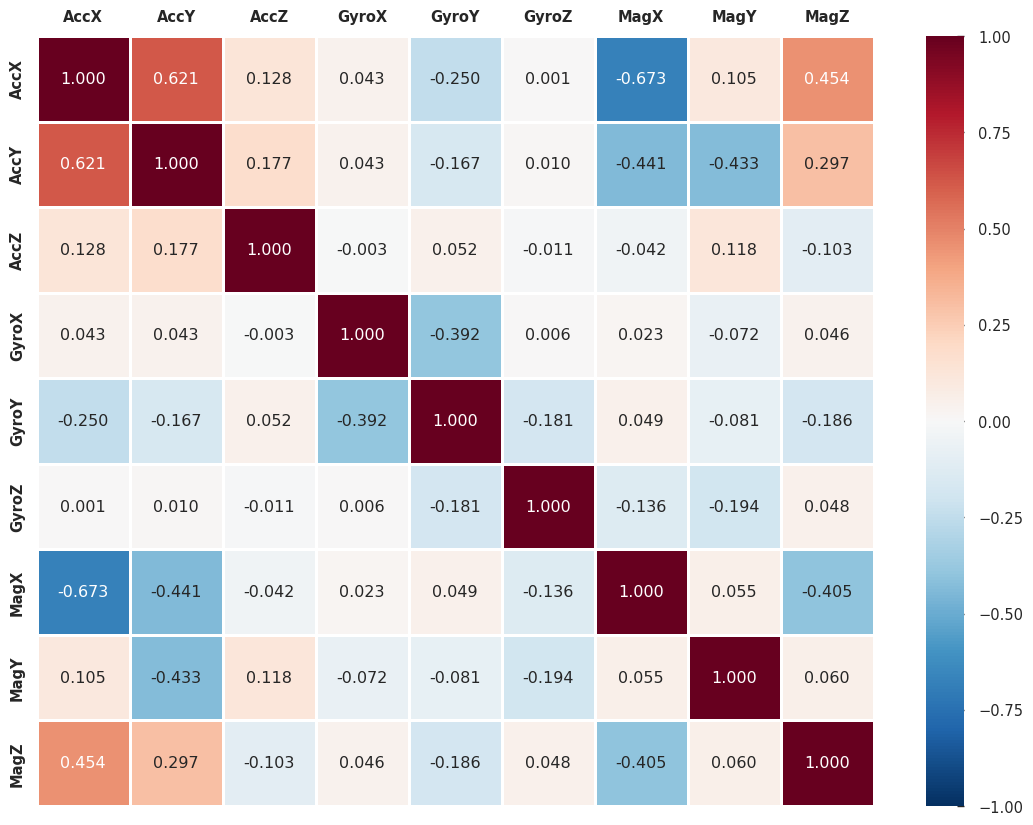

In [36]:
# Set tick labels.
tick_labels = ["AccX", "AccY", "AccZ",
               "GyroX", "GyroY", "GyroZ",
               "MagX", "MagY", "MagZ"]
# Check how input features correlate with each other.
corr_mat = cal_corr([np_accX, np_accY, np_accZ, 
                     np_gyroX, np_gyroY, np_gyroZ, 
                     np_magX, np_magY, np_magZ])

plt.figure(figsize=(13.5, 10))
with sns.plotting_context("paper", font_scale=1.2):
    ax = sns.heatmap(corr_mat, cmap='RdBu_r', annot=True, linewidths=1, vmin=-1, 
                     square=False, cbar=True, fmt='.3f', annot_kws={"fontweight": "light"},
                     xticklabels=tick_labels, yticklabels=tick_labels)

    # Get the colorbar object.
    cbar = ax.collections[0].colorbar
    # Set the location of the colorbar ticks to the right.
    cbar.ax.yaxis.set_tick_params(pad=10, direction='in', labelright=True, labelleft=False)

    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False, labeltop=True)
    ax.set_xticklabels(ax.get_xticklabels(), fontweight='bold')
    ax.set_yticklabels(ax.get_yticklabels(), fontweight='bold')
    plt.savefig('/tf/figures/corr_heatmap_IMU_use_case_2.pdf', dpi=300, bbox_inches='tight', transparent=True)
    plt.show()

The correlation heatmap of IMU data. The highest correlated feature pairs are $accX-accY$, and $accX-MagY$. The map confirms that the features do not highly correlate as all Pearson correlation coefficients are between **0.7 and -0.7**.

## Classification of arm tasks. 

As we simulate an **smart factory** environment, the arm does **3** different tasks rather than focusing only **1** task as seen in traditional manufacturing sites. 

These tasks are in order: **screwdriving**, **painting**, and **pick-and-place**. The arm starts at **home position** and stays **idle for 5 seconds** between each operations.

We need to **identify the windows** accordingly per task. We utilize the **gyroX feature** as it seems like the least noisy feature, where each task can be easily spotted.

In [37]:
def find_idle(array, upper_threshold, lower_threshold, min_length):
    """
    Find consecutive sequences within the given thresholds in a NumPy array.

    Args:
        array (numpy.ndarray): Input array containing numeric values.
        upper_threshold (float): Upper threshold for the sequence values (exclusive).
        lower_threshold (float): Lower threshold for the sequence values (exclusive).
        min_length (int): Minimum length requirement for the sequences to be included.

    Returns:
        list: List of tuples representing consecutive sequences within the thresholds and above the minimum length, where each tuple contains the length and starting index.

    Example:
        >>> a = np.array([-0.1, 0.02, -0.05, 0.01, 0.3, -0.2, 0.01, -0.04, 0.05, -0.01])
        >>> find_idle(a, 0.1, -0.1, 3)
        [(3, 1), (6, 4)]
    """
    count = 0
    result = []
    start_index = None

    for i in range(len(array)):
        if lower_threshold < array[i] < upper_threshold:
            if count == 0:
                start_index = i
            count += 1
        elif count >= min_length:
            result.append((count, start_index))
            count = 0
            start_index = None
        else:
            count = 0
            start_index = None

    if count >= min_length:
        result.append((count, start_index))

    return result


# Uncomment/comment accordingly to plot graphs that display freq. drop.
# print(find_idle(np_accY, 0.30, -0.30, 50))
# plt.plot(np_gyroY[373000:389000])
# plt.plot(np_gyroY[117500:137500])
# plt.axvline(x=381500, color='red')
# plt.axvline(x=127500, color='red')
# plt.xticks([])
# plt.savefig('figures/freqDrop1.pdf', dpi=300, bbox_inches='tight', transparent=True)
# plt.savefig('figures/freqDrop2.pdf', dpi=300, bbox_inches='tight', transparent=True)
# plt.show()

Here, we have discovered something very interesting. The **data frequence drops** after certain point due to some unknown reason.

We can confirm this via looking at **timestamps written by InfluxDB**.

In [38]:
print(len(dataset_IMU))
avg_time_diff_imu = dataset_IMU['time'][0:381000].diff().mean()
avg_time_diff_imu_2 = dataset_IMU['time'][382000:1076923].diff().mean()
print(f"The time diff between two consecutive points {avg_time_diff_imu/1000000} miliseconds.")
print(f"The time diff between two consecutive points {avg_time_diff_imu_2/1000000} miliseconds.")

1076923
The time diff between two consecutive points 53.59193593683973 miliseconds.
The time diff between two consecutive points 98.21236340193576 miliseconds.


The above values **confirms the frequency drop**.

Now let's check if we see and freq. drops when we **only generate Accelerometer and Gyroscope**.

In [37]:
# If local the path:
data_path_IMU_no_mag = "/tf/datasets/IMU_Acc_Gyro_20Hz.csv" # Freq Drop.

# Generate the dataframe
dataset_IMU_no_mag = pd.read_csv(data_path_IMU_no_mag, on_bad_lines='warn', skiprows=range(1, 100))

# Here we drop name and time columns.
df_IMU_no_mag = dataset_IMU.drop(columns=drops)

# Check if there are any empty/Nan variables. 
if dataset_IMU_no_mag.isnull().values.any():
    raise ValueError("Nan variable is present.")
    
# Explore the dataframe.
print(dataset_IMU_no_mag.info())

# Calculate the frequency of data.
avg_time_diff_imu_no_mag = dataset_IMU_no_mag['time'].diff().mean()
print(f"The time diff between two consecutive points {avg_time_diff_imu_no_mag/1000000} miliseconds.")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 930948 entries, 0 to 930947
Data columns (total 11 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   name    930948 non-null  object 
 1   time    930948 non-null  int64  
 2   accX    930948 non-null  float64
 3   accY    930948 non-null  float64
 4   accZ    930948 non-null  float64
 5   gyroX   930948 non-null  float64
 6   gyroY   930948 non-null  float64
 7   gyroZ   930948 non-null  float64
 8   magX    930948 non-null  int64  
 9   magY    930948 non-null  int64  
 10  magZ    930948 non-null  int64  
dtypes: float64(6), int64(4), object(1)
memory usage: 78.1+ MB
None
The time diff between two consecutive points 94.257211205364 miliseconds.


We still see a datadrop, so the main reason is highly likely due to **sending data over BLE**.

### Classification with no freq. drop.
Now we load a new dataset where we **generate data at 10Hz** and do not observe any freq. drops. For the rest of the work, we will be using **that IMU data**.

In [38]:
# Remove columns by their names
drops = ['name', 'time']

# Generate quaternion dataframe, perform initial checks.
# If local the path:
data_path_IMU = "/tf/datasets/IMU_10Hz.csv"

# Generate the dataframe
dataset_IMU = pd.read_csv(data_path_IMU, on_bad_lines='warn', skiprows=range(1, 100))

# Here we drop name and time columns.
df_IMU = dataset_IMU.drop(columns=drops)

# Check if there are any empty/Nan variables. 
if dataset_IMU.isnull().values.any():
    raise ValueError("Nan variable is present.")
    
# Explore the dataframe.
print(dataset_IMU.info())

# Calculate the frequency of data.
avg_time_diff_imu = dataset_IMU['time'].diff().mean()
print(f"The time diff between two consecutive points {avg_time_diff_imu/1000000} miliseconds.")

# Split the features to single arrays.
# We dropped name and time above, so accX starts from 0.
# Also we cut the first 120 points as Nicla starts before arm.
delay = 120
columns = df_IMU.columns[:9] 
data_arrays = [df_IMU.iloc[delay:, i].reset_index(drop=True) for i in range(9)]
np_accX, np_accY, np_accZ, np_gyroX, np_gyroY, np_gyroZ, np_magX, np_magY, np_magZ = data_arrays

# Combine the features per modality.
np_acc = np.stack([np_accX, np_accY, np_accZ], axis=1)
np_gyro = np.stack([np_gyroX, np_gyroY, np_gyroZ], axis=1)
np_mag = np.stack([np_magX, np_magY, np_magZ], axis=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 874838 entries, 0 to 874837
Data columns (total 11 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   name    874838 non-null  object 
 1   time    874838 non-null  int64  
 2   accX    874838 non-null  float64
 3   accY    874838 non-null  float64
 4   accZ    874838 non-null  float64
 5   gyroX   874838 non-null  float64
 6   gyroY   874838 non-null  float64
 7   gyroZ   874838 non-null  float64
 8   magX    874838 non-null  float64
 9   magY    874838 non-null  float64
 10  magZ    874838 non-null  float64
dtypes: float64(9), int64(1), object(1)
memory usage: 73.4+ MB
None
The time diff between two consecutive points 100.16107914960158 miliseconds.


We see that when we generate data at **10Hz** there are **no drops** at all.

Now, we find the **idle** points, as we know the arm goes back to home position and stays there for **5 seconds**. 

We utilize the **Z-axis of gyroscope** as it is one of the **least noisy** ones.

In [39]:
# We find those points with their indexes.
idle_points = find_idle(np_gyroZ, 0.51, -0.51, 45)
min_tuple = min(idle_points, key=lambda x: x[0])
max_tuple = max(idle_points, key=lambda x: x[0])
mean_x = sum(point[0] for point in idle_points) / len(idle_points)

# Find the max difference of idle starting indexes.
differences = [idle_points[i+1][1] - idle_points[i][1] for i in range(len(idle_points) - 1)]
min_difference = min(differences)
min_difference_index = differences.index(min_difference)
max_difference = max(differences)
max_difference_index = differences.index(max_difference)

print(f"Max diff. at {idle_points[max_difference_index]}")
print(f"Next max diff. at {idle_points[max_difference_index + 1]}")
print(f"Max diff. of idle starting points is {max_difference}.")
print(f"Min diff. at {idle_points[min_difference_index]}")
print(f"Minimun idle duration are {min_tuple} points.")
print(f"Maximum idle duration are {max_tuple} points.")
print(f"Mean of number of idle points: {mean_x}")
# print(idle_points) # Uncomment to understand where below values come from.

Max diff. at (55, 122976)
Next max diff. at (52, 123190)
Max diff. of idle starting points is 214.
Min diff. at (53, 9306)
Minimun idle duration are (48, 77322) points.
Maximum idle duration are (73, 56943) points.
Mean of number of idle points: 56.28012661089758


In the above graph, we see that we successfully separate each task. Now, we generate our **input windows**.

In [40]:
def merge_windows(windows):
    """
    Convert a list of window tuples into a new format where adjacent tuples are combined.

    Args:
        windows (list): List of tuples representing windows.

    Returns:
        list: List of converted window tuples.

    Example:
        >>> windows = [(100, 0), (91, 347), (96, 718)]
        >>> convert_windows(windows)
        [(100, 0, 91, 347), (91, 347, 96, 718)]
    """
    converted_windows = []
    for i in range(len(windows) - 1):
        window1 = windows[i]
        window2 = windows[i + 1]
        converted_window = (*window1, *window2)
        converted_windows.append(converted_window)
    return converted_windows

merged_idle_points = merge_windows(idle_points)

sample_windows = []
for window in merged_idle_points:
    start_index = window[1] + int(window[0] / 2)
    end_index = window[3] + int(window[2] / 2)
    sample_windows.append(np_gyroZ[start_index:end_index])

We **plot** to visualize and save as figures, **comment/uncomment** accordingly.

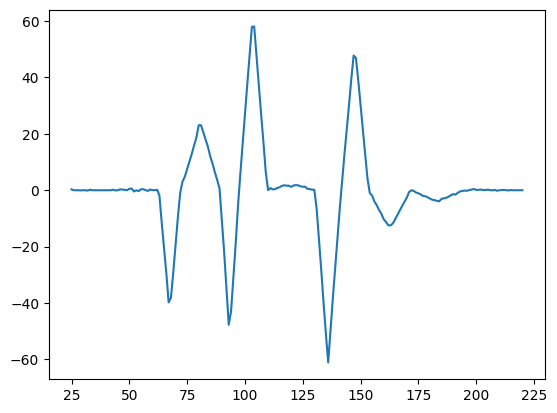

In [41]:
# Plot several windows to visualize.
# plt.plot(np_gyroZ[0:625])
# plt.savefig("figures/all_tasks_plot.pdf", format="pdf", dpi=300)
plt.plot(sample_windows[0])
plt.savefig("/tf/figures/screw_driving_plot.pdf", format="pdf", dpi=300)
# plt.plot(sample_windows[1])
# plt.savefig("figures/painting_plot.pdf", format="pdf", dpi=300)
# plt.plot(sample_windows[2])
# plt.savefig("figures/pick_and_place_plot.pdf", format="pdf", dpi=300)
# plt.plot(sample_windows[-1])
plt.show()

We create **sample windows for each task** now.

In [42]:
# Create list per task.
screw_driving_samples = []
painting_samples = []
pick_and_place_samples = []

# We have 3 tasks in total.
num_lists = 3

# Append samples based on task.
for i, series in enumerate(sample_windows):
    target_list = i % num_lists
    if target_list == 0:
        screw_driving_samples.append(series)
    elif target_list == 1:
        painting_samples.append(series)
    elif target_list == 2:
        pick_and_place_samples.append(series)
        
print(f"The number of screwdriving samples= {len(screw_driving_samples)}")
print(f"The number of painting samples= {len(painting_samples)}")
print(f"The number of pick and place samples= {len(pick_and_place_samples)}")

The number of screwdriving samples= 1474
The number of painting samples= 1474
The number of pick and place samples= 1474


There are total of **4422 windows** shared **equally** by each task.

Now, we **verify** that **the sampling process** are done correctly by checking the **mean** of each sample window. 
One other option would be using the median, but in our case, **medians are zero** due to high number of zeros.

In [43]:
# Get the means.
sd_means = [series.mean() for series in screw_driving_samples]
p_means = [series.mean() for series in painting_samples]
pp_means = [series.mean() for series in pick_and_place_samples]

# Find the min, max, mean of means with their indexes.
# For screwdriving.
max_sd, max_sd_idx = max((mean, idx) for idx, mean in enumerate(sd_means))
min_sd, min_sd_idx = min((mean, idx) for idx, mean in enumerate(sd_means))
mean_sd = sum(sd_means) / len(sd_means)

# For painting.
max_p, max_p_idx = max((mean, idx) for idx, mean in enumerate(p_means))
min_p, min_p_idx = min((mean, idx) for idx, mean in enumerate(p_means))
mean_p = sum(p_means) / len(p_means)

# For pick-and-place.
max_pp, max_pp_idx = max((mean, idx) for idx, mean in enumerate(pp_means))
min_pp, min_pp_idx = min((mean, idx) for idx, mean in enumerate(pp_means))
mean_pp = sum(pp_means) / len(pp_means)

# Analyze window lengths.
# For screwdriving.
window_lengths_sd = [(i, len(series)) for i, series in enumerate(screw_driving_samples)]
max_len_sd, min_len_sd = max(window_lengths_sd, key=lambda x: x[1]), min(window_lengths_sd, key=lambda x: x[1])
mean_length_sd = sum(length for _, length in window_lengths_sd) / len(window_lengths_sd)

# For painting.
window_lengths_p = [(i, len(series)) for i, series in enumerate(painting_samples)]
max_len_p, min_len_p = max(window_lengths_p, key=lambda x: x[1]), min(window_lengths_p, key=lambda x: x[1])
mean_length_p = sum(length for _, length in window_lengths_p) / len(window_lengths_p)

# For pick-and-place.
window_lengths_pp = [(i, len(series)) for i, series in enumerate(pick_and_place_samples)]
max_len_pp, min_len_pp = max(window_lengths_pp, key=lambda x: x[1]), min(window_lengths_pp, key=lambda x: x[1])
mean_length_pp = sum(length for _, length in window_lengths_pp) / len(window_lengths_pp)

print(f"Max SD mean: {max_sd}, Index: {max_sd_idx}")
print(f"Min SD mean: {min_sd}, Index: {min_sd_idx}")
print(f"Mean SD: {mean_sd}")
print(f"Max P mean: {max_p}, Index: {max_p_idx}")
print(f"Min P mean: {min_p}, Index: {min_p_idx}")
print(f"Mean P: {mean_p}")
print(f"Max PP mean: {max_pp}, Index: {max_pp_idx}")
print(f"Min PP mean: {min_pp}, Index: {min_pp_idx}")
print(f"Mean PP: {mean_pp}")
print(f"Screwdriving max-min-mean window length {max_len_sd}-{min_len_sd}-{mean_length_sd}")
print(f"Painting max-min-mean window length {max_len_p}-{min_len_p}-{mean_length_p}")
print(f"Pick-and-place max-min-mean window length {max_len_pp}-{min_len_pp}-{mean_length_pp}")

Max SD mean: 0.08238636363636363, Index: 556
Min SD mean: -0.25615284974093266, Index: 161
Mean SD: -0.04329015091153742
Max P mean: 0.5891587677725119, Index: 1161
Min P mean: -0.4401785714285714, Index: 326
Mean P: 0.07074503524497575
Max PP mean: 0.12051104972375691, Index: 346
Min PP mean: -0.04802631578947368, Index: 1040
Mean PP: 0.02435833782605387
Screwdriving max-min-mean window length (1201, 205)-(102, 191)-197.94436906377206
Painting max-min-mean window length (1215, 214)-(44, 207)-210.72523744911805
Pick-and-place max-min-mean window length (1273, 192)-(317, 179)-184.62279511533242


Now, we visualize each to verify window sampling process, gain more insight. Comment and uncomment accordingly. Indexes are taken from above.

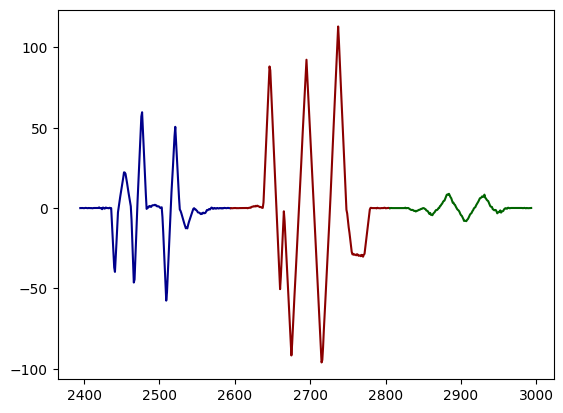

In [46]:
# Coloring each task.
plt.plot(screw_driving_samples[4], color='darkblue')
plt.plot(painting_samples[4], color='#8B0000')
plt.plot(pick_and_place_samples[4], color='darkgreen')
plt.savefig("/tf/figures/colouredTasks.pdf", format="pdf", dpi=300)
plt.show()

# Indexes are given in above cell.
plot_info = [
    (screw_driving_samples[556], "/tf/figures/highestMeanSD.pdf"),
    (screw_driving_samples[161], "/tf/figures/lowestMeanSD.pdf"),
    (painting_samples[1161], "/tf/figures/highestMeanP.pdf"),
    (painting_samples[326], "/tf/figures/lowestMeanP.pdf"),
    (pick_and_place_samples[346], "/tf/figures/highestMeanPP.pdf"),
    (pick_and_place_samples[1040], "/tf/figures/lowestMeanPP.pdf"),
    (screw_driving_samples[1201], "/tf/figures/longestSD.pdf"),
    (screw_driving_samples[102], "/tf/figures/shortestSD.pdf"),
    (painting_samples[1215], "/tf/figures/longestP.pdf"),
    (painting_samples[44], "/tf/figures/shortestP.pdf"),
    (pick_and_place_samples[1273], "/tf/figures/longestPP.pdf"),
    (pick_and_place_samples[317], "/tf/figures/shortestPP.pdf"),
]

# Uncomment for once to save the plots.
# Add delay if you would like to see plots.
# for data, filename in plot_info:
#     x_values = range(len(data))
#     plt.plot(x_values, data)
#     plt.savefig(filename, format="pdf", dpi=300)
#     plt.show()

If we check above figures, we will see that, all samples **are extracted** in a correct manner. 

Now, we will implement a **real-time classification** method. 

First, we split the dataset into **60% training, 20% validation, and 20% test.**

In [47]:
# Combine samples.
samples = screw_driving_samples + painting_samples + pick_and_place_samples

# We split the dataset.
num_samples = len(samples)
num_training_samples = int(0.6 * num_samples)
num_validation_samples = int(0.2 * num_samples)
train_indices = list(range(num_training_samples))
validation_indices = list(range(num_training_samples, num_training_samples + num_validation_samples))
test_indices = list(range(num_training_samples + num_validation_samples, num_samples - 1))

# We want to keep the temporal order.
X_train = [samples[i] for i in train_indices]
y_train = [samples[i + 1] for i in train_indices]
print(f"X_train length: {len(X_train)}, y_train length: {len(y_train)}")

X_val = [samples[i] for i in validation_indices]
y_val = [samples[i + 1] for i in validation_indices]
print(f"X_val length: {len(X_val)}, y_val length: {len(y_val)}")

X_test = [samples[i] for i in test_indices]
y_test = [samples[i + 1] for i in test_indices]
print(f"X_test length: {len(X_test)}, y_test length: {len(y_test)}")

# Check if X_train matches with y_train.
if str(X_train[1]) == str(y_train[0]) and str(X_val[1]) == str(y_val[0]) and str(X_test[1]) == str(y_test[0]):
    print("All samples are shifted by 1.")
else:
    print("Shifting error exists.")

X_train length: 2653, y_train length: 2653
X_val length: 884, y_val length: 884
X_test length: 884, y_test length: 884
All samples are shifted by 1.


### Rolling Mean Analysis

In [48]:
# We flatten our samples.
sd_series = pd.concat(screw_driving_samples, axis=0)
p_series = pd.concat(painting_samples, axis=0)
pp_series = pd.concat(pick_and_place_samples, axis=0)

# Add labels, 0 for screwdriving, 1 for painting, 2 for pick-and-place.
df_sd = pd.DataFrame(sd_series)
df_sd['labels'] = 0
df_p = pd.DataFrame(p_series)
df_p['labels'] = 1
df_pp = pd.DataFrame(pp_series)
df_pp['labels'] = 2

# Merge the all samples.
# df = pd.concat([df_sd, df_p, df_pp], axis=0)
df = df_sd.combine_first(df_p).combine_first(df_pp)

# Reset the index as there are duplicate indexes.
df.reset_index(drop=True, inplace=True)

# Confirm no duplicate indexes.
if df.index.duplicated().any():
    print("Duplicate indexes found.")
else:
    print("No duplicate indexes.")

No duplicate indexes.


Now we have the labeled dataframe. Hence, we can start the **moving window analysis**. Let's remind ourselves the window lengths:

- **Screwdriving** max-min-mean window length **205-191-197.94**
- **Painting** max-min-mean window length **214-207-210.72**
- **Pick-and-place** max-min-mean window length **192-179-184.62**

The idling duration between tasks around **50 data points**. We want to detect the new task as soon as possible. This depends on the moving window size. If the window size is 25, we can detect new task around **13 data points** so around **1.3 seconds**.

In [49]:
# Rolling mean function.
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

# Get each feature.
# Get first 100000 points only.
gyroZ = df['gyroZ'][0:100000]
labels = df['labels'][0:100000]

# Set the window size.
window_size = 5

# Label sliding windows based on the most label occurrences.
rolling_labels = labels.rolling(window=window_size).apply(lambda x: x.mode()[0])
rolling_labels = rolling_labels.dropna().reset_index(drop=True)

# Get moving average with a window size 5.
gyroZ_filtered = moving_average(gyroZ, window_size)

# Merge the new labels and rolling window.
df_rolled = np.column_stack((gyroZ_filtered, rolling_labels))

# Check the lengths
print(f"Data length: {len(gyroZ_filtered)}, label length: {len(rolling_labels)}")

Data length: 99996, label length: 99996


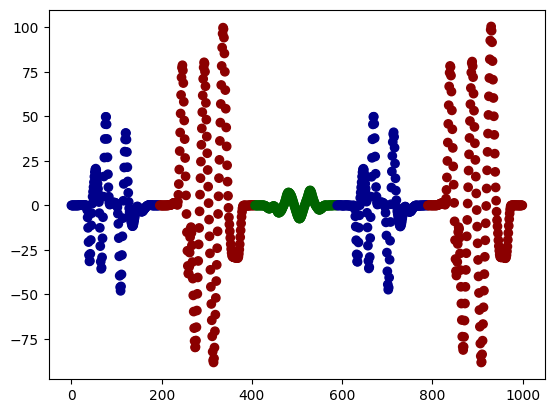

In [50]:
# Plot the first 10 points with different colors based on labels
plot_range = 1000
plt.scatter(range(plot_range), gyroZ_filtered[:plot_range], 
            c=['darkblue' if sliding_labels == 0 else 'darkred' 
               if sliding_labels == 1 else 'darkgreen' 
               for sliding_labels in labels[:plot_range]])
plt.show()

**Rolling mean analysis** is inadequate to classify the signals. Now we try **peak analysis**.

To do the peak analysis, we need to filter the noise first. We apply peak analysis to filtered (via rolling mean) signal.

### Peak Analysis

First, we create new samples from the **filtered signal**.

In [51]:
# We find those points with their indexes.
# _f for "filtered".
idle_points_f = find_idle(gyroZ_filtered, 0.51, -0.51, 20)
min_tuple_f = min(idle_points_f, key=lambda x: x[0])

# Find the max difference of idle starting indexes.
differences_f = [idle_points_f[i+1][1] - idle_points_f[i][1] 
               for i in range(len(idle_points_f) - 1)]
min_difference_f = min(differences_f)
min_difference_index_f = differences_f.index(min_difference_f)
max_difference_f = max(differences_f)
max_difference_index_f = differences_f.index(max_difference_f)

# Verify if we can identify idle points.
print(f"Max diff. at {idle_points_f[max_difference_index_f]}")
print(f"Next max diff. at {idle_points_f[max_difference_index_f + 1]}")
print(f"Max diff. of idle starting points is {max_difference_f}.")
print(f"Min diff. at {idle_points_f[min_difference_index_f]}")
print(f"Minimun idle duration are {min_tuple_f} points.")

merged_idle_points_f = merge_windows(idle_points_f)

sample_windows_f = []
for window in merged_idle_points_f:
    start_index = window[1] + int(window[0] / 2)
    end_index = window[3] + int(window[2] / 2)
    sample_windows_f.append(gyroZ_filtered[start_index:end_index])
    
# Create list per task.
screw_driving_samples_f = []
painting_samples_f = []
pick_and_place_samples_f = []

# We have 3 tasks in total.
num_lists = 3

# Append samples based on task.
for i, series in enumerate(sample_windows_f):
    target_list = i % num_lists
    if target_list == 0:
        screw_driving_samples_f.append(series)
    elif target_list == 1:
        painting_samples_f.append(series)
    elif target_list == 2:
        pick_and_place_samples_f.append(series)
        
print(f"The number of screwdriving samples= {len(screw_driving_samples_f)}")
print(f"The number of painting samples= {len(painting_samples_f)}")
print(f"The number of pick and place samples= {len(pick_and_place_samples_f)}")

Max diff. at (56, 15592)
Next max diff. at (51, 15807)
Max diff. of idle starting points is 215.
Min diff. at (35, 0)
Minimun idle duration are (35, 0) points.
The number of screwdriving samples= 169
The number of painting samples= 168
The number of pick and place samples= 168


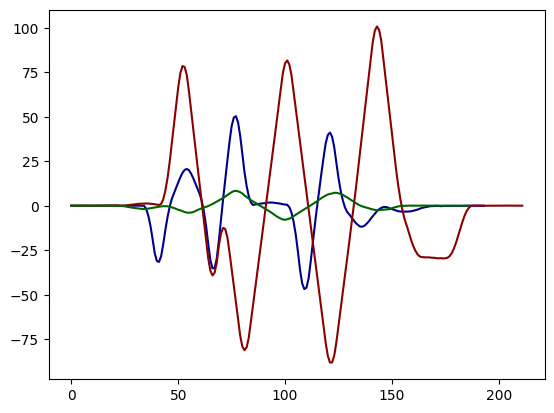

In [52]:
# We visually check to see if sampled correctly.
# Coloring each task.
plt.plot(screw_driving_samples_f[4], color='darkblue')
plt.plot(painting_samples_f[4], color='#8B0000') # darkred
plt.plot(pick_and_place_samples_f[4], color='darkgreen')
plt.savefig("/tf/figures/colouredTasks_filtered.pdf", format="pdf", dpi=300)
plt.show()

Now we **find the peaks**.

In [55]:
def find_min_max_mean(series_list):
    """
    Calculates the maximum, minimum, and mean values for each index in a list of pandas.Series objects.

    Args:
        series_list (list): A list of pandas.Series objects.

    Returns:
        list: A list of lists containing the maximum, minimum, and mean values for each index.
    """
    # Transpose the series list into a DataFrame
    df = pd.DataFrame(series_list).T

    # Initialize an empty list to store the results
    results = []

    # Calculate max, min, and mean values for each index and store in the results list
    for index in df.index:
        max_val = df.loc[index].max()
        min_val = df.loc[index].min()
        mean_val = round(df.loc[index].mean(), 4)
        results.append([max_val, min_val, mean_val])

    return results

def find_peaks_in_samples(samples, peak_count):
    """
    Finds the positive and negative peaks in a list of samples.

    Args:
        samples (list): A list of pandas.Series objects representing the samples.
        peak_count (int): The number of peaks to be returned for each sample.

    Returns:
        tuple: A tuple of lists containing the positive and negative peaks for each sample.
    """
    positive_peaks = []
    negative_peaks = []

    for sample in samples:
        # Reset the index of the sample series
        sample = sample
        # Negate the array to detect negative peaks
        negated_sample = -sample

        # Find peaks
        peak_indices, _ = find_peaks(sample, distance=15)
        peak_indices_n, _ = find_peaks(negated_sample, distance=10)

        # Sort peak indices by corresponding peak values in descending order
        sorted_peak_indices = sorted(peak_indices, key=lambda i: sample[i], reverse=True)
        sorted_peak_indices_n = sorted(peak_indices_n, key=lambda i: negated_sample[i], reverse=True)

        # Get specified number of peaks for each sample
        peak_values = sample[sorted_peak_indices[:peak_count]]
        peak_values_n = sample[sorted_peak_indices_n[:peak_count]]
        positive_peaks.append(peak_values)
        negative_peaks.append(peak_values_n)

    return positive_peaks, negative_peaks

# Find the peaks per task.
sd_peaks_positive, sd_peaks_negative = find_peaks_in_samples(screw_driving_samples_f, 3)
p_peaks_positive, p_peaks_negative = find_peaks_in_samples(painting_samples_f, 3)
pp_peaks_positive, pp_peaks_negative = find_peaks_in_samples(pick_and_place_samples_f, 4)

sd_peaks_p = find_min_max_mean(sd_peaks_positive)
sd_peaks_n = find_min_max_mean(sd_peaks_negative)
p_peaks_p = find_min_max_mean(p_peaks_positive)
p_peaks_n = find_min_max_mean(p_peaks_negative)
pp_peaks_p = find_min_max_mean(pp_peaks_positive)
pp_peaks_n = find_min_max_mean(pp_peaks_negative)

# Order is max, min, and mean.
# Ranking is from highest to lowest.
screwdriving_peaks = {
    "1st Positive": sd_peaks_p[0],
    "2nd Positive": sd_peaks_p[1],
    "3th Positive": sd_peaks_p[2],
    "1st Negative": sd_peaks_n[0],
    "2nd Negative": sd_peaks_n[1],
    "3th Negative": sd_peaks_n[2]
}
painting_peaks = {
    "1st Positive": p_peaks_p[0],
    "2nd Positive": p_peaks_p[1],
    "3th Positive": p_peaks_p[2],
    "1st Negative": p_peaks_n[0],
    "2nd Negative": p_peaks_n[1],
    "3th Negative": p_peaks_n[2]
}
pick_and_place_peaks = {
    "1st Positive": pp_peaks_p[0],
    "2nd Positive": pp_peaks_p[1],
    "3th Positive": pp_peaks_p[2],
    "4th Positive": pp_peaks_p[3],
    "1st Negative": pp_peaks_n[0],
    "2nd Negative": pp_peaks_n[1],
    "3th Negative": pp_peaks_n[2],
    "4th Negative": pp_peaks_n[3]
}

print("Screwdriving peaks:")
pprint(screwdriving_peaks)
print("Painting peaks:")
pprint(painting_peaks)
print("Pick-and-place peaks:")
pprint(pick_and_place_peaks)

Screwdriving peaks:
{'1st Negative': [-46.1875, -48.0375, -47.193],
 '1st Positive': [50.8625, 49.2625, 50.2125],
 '2nd Negative': [-35.05, -37.0125, -36.0195],
 '2nd Positive': [41.6375, 38.725, 41.0958],
 '3th Negative': [-29.95, -32.9375, -31.9582],
 '3th Positive': [20.9125, 20.175, 20.5947]}
Painting peaks:
{'1st Negative': [-86.7625, -89.3, -88.3968],
 '1st Positive': [100.9, 95.7625, 100.0269],
 '2nd Negative': [-79.65, -81.7625, -80.7272],
 '2nd Positive': [81.775, 79.7625, 80.756],
 '3th Negative': [-35.9, -40.1125, -38.9612],
 '3th Positive': [79.575, 76.0, 78.3001]}
Pick-and-place peaks:
{'1st Negative': [-7.2875, -8.1125, -7.7028],
 '1st Positive': [8.5375, 7.2, 8.0426],
 '2nd Negative': [-3.5125, -4.65, -4.0706],
 '2nd Positive': [8.175, 6.725, 7.2717],
 '3th Negative': [-2.3, -3.3125, -2.7819],
 '3th Positive': [0.2125, 0.025, 0.0903],
 '4th Negative': [-1.55, -1.95, -1.7782],
 '4th Positive': [0.1125, 0.0, 0.0375]}


These findings show that peaks are discriminative features. As we want to classify asap, we check the **first peaks**.

The first peak of screwdriving has the following **max-min-mean** values:[-29.95, -32.9375, -31.9582]

The first peak of painting has the following **max-min-mean** values:[79.575, 76.0, 78.3001]

The first peak of pick-and-place has the following **max-min-mean** values:[-1.55, -1.95, -1.7782]

We see that **peaks are discriminative** features in our case. Now we find when peaks occur.

In [56]:
def find_index_above_threshold(data, threshold, positive=True):
    """
    Find the index of the first element in the data array that exceeds the given threshold.

    Args:
        data (ndarray): The array of data values.
        threshold (float): The threshold value.
        positive (bool): Determines whether to consider positive values (default: True).

    Returns:
        int: The index of the first element that exceeds the threshold, or None if no element is found.
    """
    if positive:
        above_threshold = data >= threshold
    else:
        above_threshold = data <= threshold

    indices = np.where(above_threshold)[0]
    if len(indices) > 0:
        return indices[0]
    else:
        return None


def average_threshold_indexes(sample_list, threshold, positive=True):
    """
    Calculate the average index, maximum index, and minimum index of the first element in each ndarray sample that exceeds the given threshold.

    Args:
        sample_list (list): A list of ndarrays containing the samples.
        threshold (float): The threshold value.
        positive (bool): Determines whether to consider positive values (default: True).

    Returns:
        tuple: A tuple containing the average index, (maximum index, sample index for maximum index),
               (minimum index, sample index for minimum index) of the threshold across all samples.
    """
    total_indexes = 0
    num_samples = len(sample_list)
    max_index = float('-inf')
    min_index = float('inf')
    max_sample_index = -1
    min_sample_index = -1

    for i, sample in enumerate(sample_list):
        indexes = find_index_above_threshold(sample, threshold, positive=positive)
        if indexes is not None:
            total_indexes += indexes
            if indexes > max_index:
                max_index = indexes
                max_sample_index = i
            if indexes < min_index:
                min_index = indexes
                min_sample_index = i

    if total_indexes > 0:
        average_index = total_indexes / num_samples
        return average_index, (max_index, max_sample_index), (min_index, min_sample_index)
    else:
        return None, None, None

sd_index_peak_mean, sd_index_peak_max, sd_index_peak_min = average_threshold_indexes(screw_driving_samples_f, -29, positive=False)
p_index_peak_mean, p_index_peak_max, p_index_peak_min = average_threshold_indexes(painting_samples_f, 75, positive=True)
pp_index_peak_mean, pp_index_peak_max, pp_index_peak_min = average_threshold_indexes(pick_and_place_samples_f, -1.53,positive=False)

print(f"Screwdriving peak indexes mean-max-min: {sd_index_peak_mean}-{sd_index_peak_max}-{sd_index_peak_min}")
print(f"Painting peak indexes mean-max-min: {p_index_peak_mean}-{p_index_peak_max}-{p_index_peak_min}")
print(f"Pick-and-place peak indexes mean-max-min: {pp_index_peak_mean}-{pp_index_peak_max}-{pp_index_peak_min}")

Screwdriving peak indexes mean-max-min: 39.89940828402367-(41, 26)-(23, 0)
Painting peak indexes mean-max-min: 50.916666666666664-(52, 1)-(50, 0)
Pick-and-place peak indexes mean-max-min: 31.25-(33, 9)-(30, 8)


At least the first **25 points** are **idle**. This means:
- for screwdriving after **15** (40-25) data points -> 1.5 seconds,
- for painting after **25** (50-25) data points -> 2.5 seconds,
- for pick-and-place after **6** (31-6) data points -> 0.6 seconds.

### Slope Analysis

First, we apply slope analysis to **non-filtered data**.

In [57]:
def compute_derivatives(sample_list):
    """
    Compute the first derivative for each sample in a list of Pandas Series or NumPy arrays.

    Args:
        sample_list (list): A list of Pandas Series or NumPy arrays containing the samples.

    Returns:
        list: A new list containing the derivative series for each sample.
    """
    derivatives_list = []
    
    for sample in sample_list:
        if isinstance(sample, pd.Series):
            derivative = sample.diff().reset_index(drop=True)
        elif isinstance(sample, np.ndarray):
            derivative = np.diff(sample)
        else:
            raise ValueError("Invalid sample type. Expected Pandas Series or NumPy array.")
        
        derivatives_list.append(derivative)
    
    return derivatives_list


# Get the derivatives (der). 
sd_der = compute_derivatives(screw_driving_samples) # -3.5 is the treshold
p_der = compute_derivatives(painting_samples) # +3.5 is the treshold
pp_der = compute_derivatives(pick_and_place_samples) # if neither it is a pick-and-place.

sd_der_starting_index = average_threshold_indexes(sd_der, -3.5, positive=False)
p_der_starting_index = average_threshold_indexes(p_der, 3.5, positive=True)
pp_der_starting_index = average_threshold_indexes(pp_der, -0.51, positive=False)

print(f"Screwdriving start indexes mean-max-min: {sd_der_starting_index}")
print(f"Painting start indexes mean-max-min: {p_der_starting_index}")
print(f"Pick-and-place start indexes mean-max-min: {pp_der_starting_index}")

Screwdriving start indexes mean-max-min: (39.933514246947084, (45, 318), (31, 583))
Painting start indexes mean-max-min: (43.63161465400271, (46, 202), (40, 982))
Pick-and-place start indexes mean-max-min: (37.58819538670285, (53, 995), (23, 76))


Now, we visualize to see if taking **first derivatives** provides an **sooner** classification than peak analysis.

**Uncomment/comment** accordingly to see the plots.

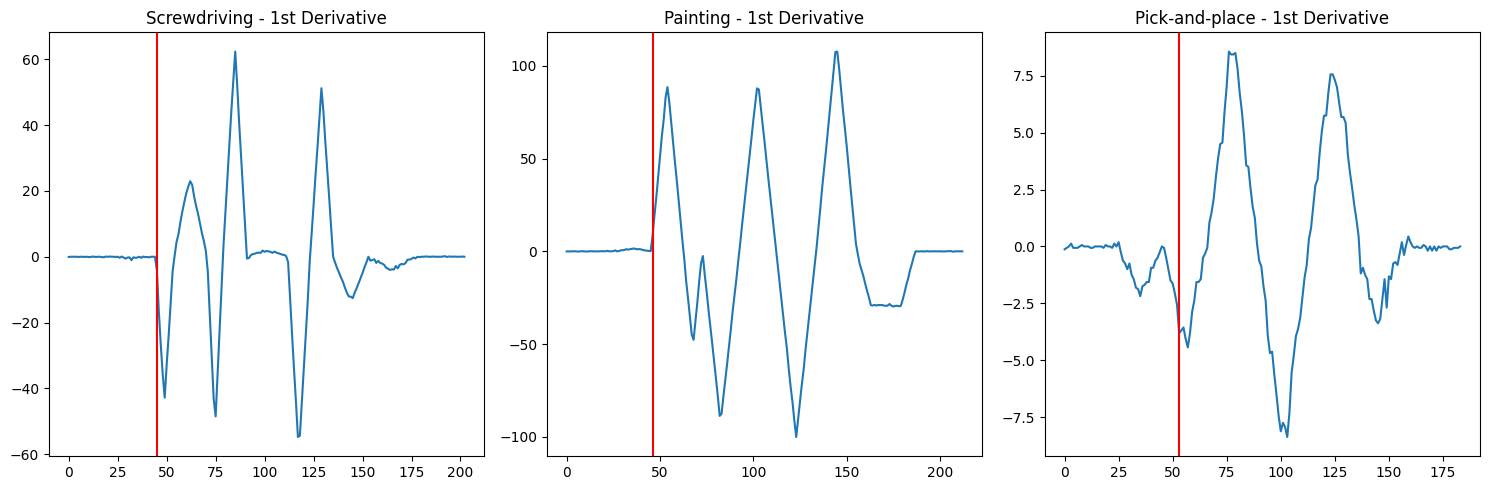

In [58]:
# Screwdriving starting index via first derivative analysis.
# plt.plot(screw_driving_samples[318].reset_index(drop=True))
# plt.axvline(x=45, color='red')
# plt.savefig("figures/sd_1st_derivative_index.pdf", format="pdf", dpi=300)
# plt.show()

# Painting starting index via first derivative analysis.
# plt.plot(painting_samples[202].reset_index(drop=True))
# plt.axvline(x=46, color='red')
# plt.savefig("figures/p_1st_derivative_index.pdf", format="pdf", dpi=300)
# plt.show()

# Pick-and-place starting index via first derivative analysis.
# plt.plot(pick_and_place_samples[76].reset_index(drop=True))
# plt.axvline(x=23, color='red')
# plt.savefig("figures/pp_1st_derivative_index.pdf", format="pdf", dpi=300)
# plt.show()

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Screwdriving starting index via first derivative analysis.
axs[0].plot(screw_driving_samples[318].reset_index(drop=True))
axs[0].axvline(x=45, color='red')
axs[0].set_title('Screwdriving - 1st Derivative')

# Painting starting index via first derivative analysis.
axs[1].plot(painting_samples[202].reset_index(drop=True))
axs[1].axvline(x=46, color='red')
axs[1].set_title('Painting - 1st Derivative')

# Pick-and-place starting index via first derivative analysis.
axs[2].plot(pick_and_place_samples[995].reset_index(drop=True))
axs[2].axvline(x=53, color='red')
axs[2].set_title('Pick-and-place - 1st Derivative')

plt.tight_layout()
plt.show()

From the visuals, we see that the method might fail for **pick-and-place samples**. So, we try with the **filtered samples**.

In [59]:
# Get the derivatives (der). 
sd_der_f = compute_derivatives(screw_driving_samples_f) # -2 is the treshold.
p_der_f = compute_derivatives(painting_samples_f) # +1.5 is the treshold.
pp_der_f = compute_derivatives(pick_and_place_samples_f) # -0.2 is the treshold.

sd_der_starting_index_f = average_threshold_indexes(sd_der_f, -2, positive=False)
p_der_starting_index_f = average_threshold_indexes(p_der_f, 1.5, positive=True)
pp_der_starting_index_f = average_threshold_indexes(pp_der_f, -0.185, positive=False)

print(f"Screwdriving_filtered start indexes mean-max-min: {sd_der_starting_index_f}")
print(f"Painting_filtered start indexes mean-max-min: {p_der_starting_index_f}")
print(f"Pick-and-place_filtered start indexes mean-max-min: {pp_der_starting_index_f}")

Screwdriving_filtered start indexes mean-max-min: (34.562130177514796, (35, 2), (17, 0))
Painting_filtered start indexes mean-max-min: (41.291666666666664, (42, 1), (40, 0))
Pick-and-place_filtered start indexes mean-max-min: (25.053571428571427, (28, 0), (23, 5))


Now, we visually analyze to see if filtering provides better results at finding movement starting index via checking first derivatives.

First 3 are slope, and last 3 are peak analysis plots. **Individual plots are commented** as they are used in article.

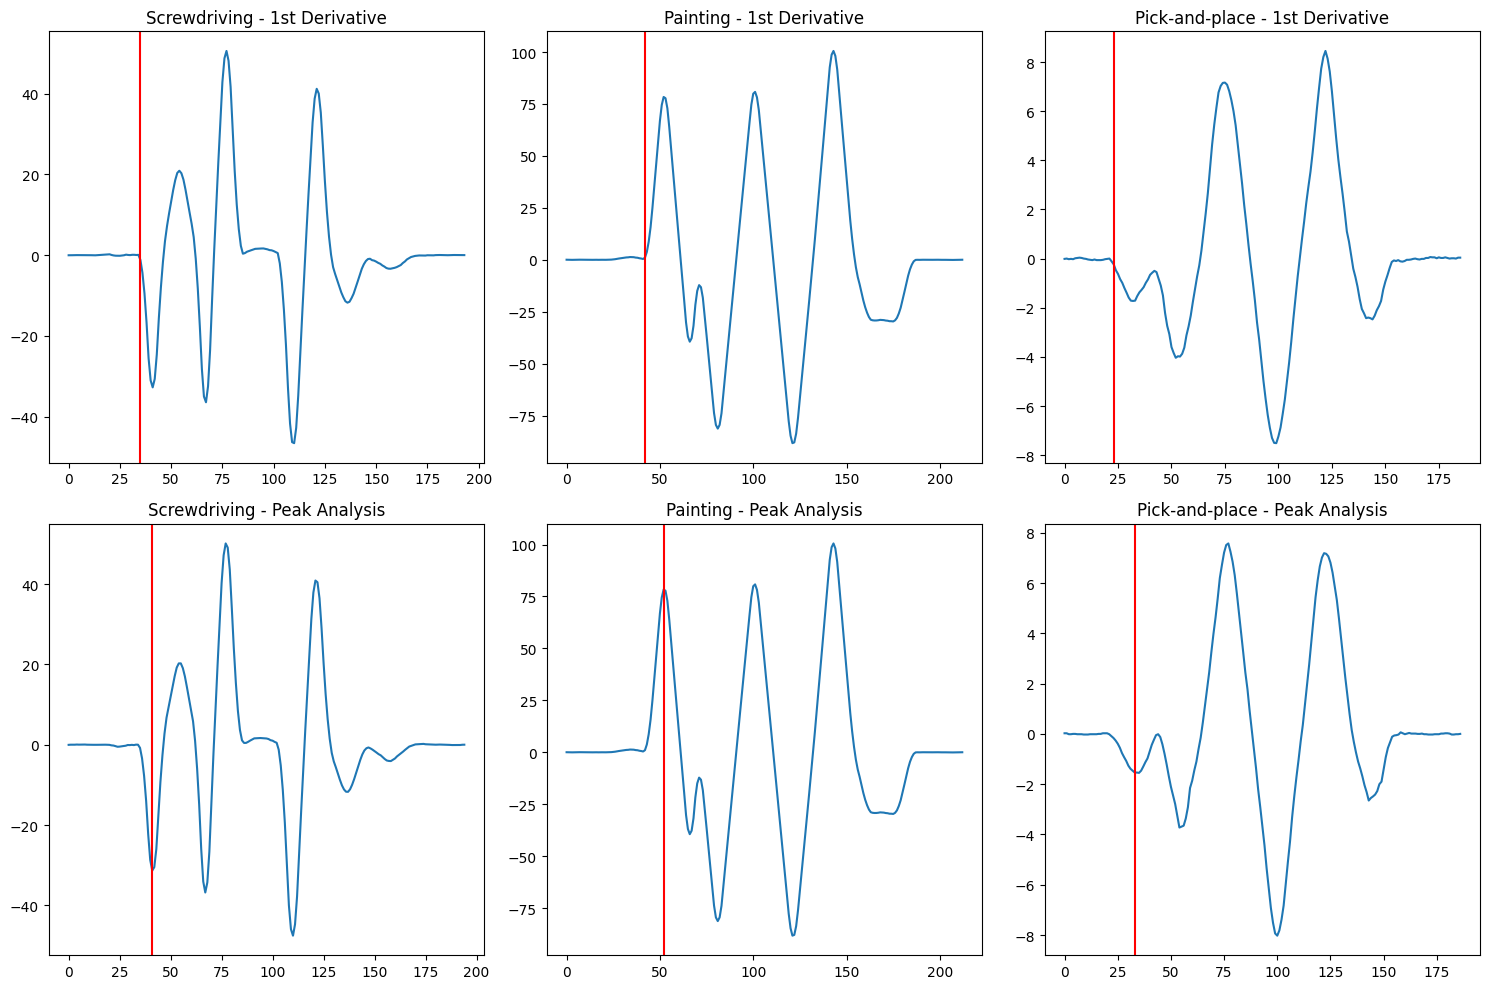

In [60]:
# Screwdriving starting index via first derivative analysis.
# plt.plot(screw_driving_samples_f[2])
# plt.axvline(x=35, color='red')
# plt.savefig("figures/sd_1st_derivative_index.pdf", format="pdf", dpi=300)
# plt.show()

# Painting starting index via first derivative analysis.
# plt.plot(painting_samples_f[1])
# plt.axvline(x=42, color='red')
# plt.savefig("figures/p_1st_derivative_index.pdf", format="pdf", dpi=300)
# plt.show()

# Pick-and-place starting index via first derivative analysis.
# plt.plot(pick_and_place_samples_f[163])
# plt.axvline(x=23, color='red')
# plt.savefig("figures/pp_1st_derivative_index.pdf", format="pdf", dpi=300)
# plt.show()

# Screwdriving starting index via peak analysis.
# plt.plot(screw_driving_samples_f[26])
# plt.axvline(x=41, color='red')
# plt.savefig("figures/sd_peak_index.pdf", format="pdf", dpi=300)
# plt.show()

# Painting starting index via peak analysis.
# plt.plot(painting_samples_f[1])
# plt.axvline(x=52, color='red')
# plt.savefig("figures/p_peak_index.pdf", format="pdf", dpi=300)
# plt.show()

# Pick-and-place starting index via first derivative analysis.
# plt.plot(pick_and_place_samples_f[9])
# plt.axvline(x=33, color='red')
# plt.savefig("figures/pp_peak_derivative_index.pdf", format="pdf", dpi=300)
# plt.show()

fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Screwdriving starting index via first derivative analysis.
axs[0, 0].plot(screw_driving_samples_f[2])
axs[0, 0].axvline(x=35, color='red')
axs[0, 0].set_title('Screwdriving - 1st Derivative')

# Painting starting index via first derivative analysis.
axs[0, 1].plot(painting_samples_f[1])
axs[0, 1].axvline(x=42, color='red')
axs[0, 1].set_title('Painting - 1st Derivative')

# Pick-and-place starting index via first derivative analysis.
axs[0, 2].plot(pick_and_place_samples_f[163])
axs[0, 2].axvline(x=23, color='red')
axs[0, 2].set_title('Pick-and-place - 1st Derivative')

# Screwdriving starting index via peak analysis.
axs[1, 0].plot(screw_driving_samples_f[26])
axs[1, 0].axvline(x=41, color='red')
axs[1, 0].set_title('Screwdriving - Peak Analysis')

# Painting starting index via peak analysis.
axs[1, 1].plot(painting_samples_f[1])
axs[1, 1].axvline(x=52, color='red')
axs[1, 1].set_title('Painting - Peak Analysis')

# Pick-and-place starting index via peak analysis.
axs[1, 2].plot(pick_and_place_samples_f[9])
axs[1, 2].axvline(x=33, color='red')
axs[1, 2].set_title('Pick-and-place - Peak Analysis')

plt.tight_layout()
plt.savefig("/tf/figures/analysis_plots.pdf", format="pdf", dpi=300)
plt.show()

We see that we do require **filtered samples** for 1st-derivative analysis to work. 

Now, that we have completed the task classification, we will move into anomaly detection bit.

## Anomaly Detection

We see that the filtered data offer much better results, so we will be using them for anomaly detection.

We implement all from the beginning, so we can **start running cells directly from here.**

### Preprocessing/Analyzing Data

In [5]:
# Remove columns by their names
drops = ['name', 'time']

# Generate quaternion dataframe, perform initial checks.
# If local the path:
data_path_IMU = "/tf/datasets/IMU_10Hz.csv" # Freq Drop.

# Generate the dataframe
dataset_IMU = pd.read_csv(data_path_IMU, on_bad_lines='warn', skiprows=range(1, 100))

# Check if there are any empty/Nan variables. 
if dataset_IMU.isnull().values.any():
    raise ValueError("Nan variable is present.")
    
# Explore the dataframe.
print(dataset_IMU.info())

# Calculate the frequency of data.
avg_time_diff_imu = dataset_IMU['time'].diff().mean()
print(f"The time diff between two consecutive points {avg_time_diff_imu/1000000} miliseconds.")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 874838 entries, 0 to 874837
Data columns (total 11 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   name    874838 non-null  object 
 1   time    874838 non-null  int64  
 2   accX    874838 non-null  float64
 3   accY    874838 non-null  float64
 4   accZ    874838 non-null  float64
 5   gyroX   874838 non-null  float64
 6   gyroY   874838 non-null  float64
 7   gyroZ   874838 non-null  float64
 8   magX    874838 non-null  float64
 9   magY    874838 non-null  float64
 10  magZ    874838 non-null  float64
dtypes: float64(9), int64(1), object(1)
memory usage: 73.4+ MB
None
The time diff between two consecutive points 100.16107914960158 miliseconds.


Now, we have confirmed that this data are gathered at **10Hz** exactly.

In [6]:
hours = len(dataset_IMU) / (60*60*10)
print(f"The dataset length corresponds to {hours} hours.")

The dataset length corresponds to 24.301055555555557 hours.


As we see the non-anomalous data a bit longer than 24 hours.

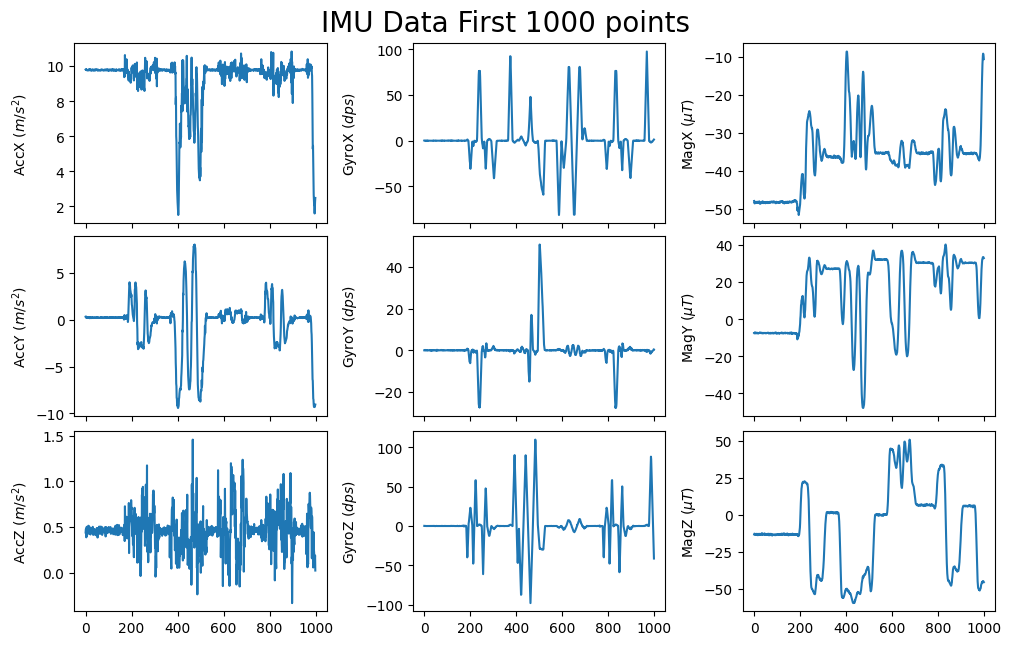

In [7]:
# Visualize the first 1000 point
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, sharex = True, figsize=(10, 6), constrained_layout=True)

start_index = 0
end_index = 1000

ax1.plot(dataset_IMU.index[start_index:end_index], dataset_IMU['accX'][start_index:end_index])
ax1.set_ylabel(r'AccX $(m/s^2)$')

ax2.plot(dataset_IMU.index[start_index:end_index], dataset_IMU['gyroX'][start_index:end_index])
ax2.set_ylabel(r'GyroX $(dps)$')

ax3.plot(dataset_IMU.index[start_index:end_index], dataset_IMU['magX'][start_index:end_index])
ax3.set_ylabel(r'MagX (${\mu}T$)')

ax4.plot(dataset_IMU.index[start_index:end_index], dataset_IMU['accY'][start_index:end_index])
ax4.set_ylabel(r'AccY $(m/s^2)$')

ax5.plot(dataset_IMU.index[start_index:end_index], dataset_IMU['gyroY'][start_index:end_index])
ax5.set_ylabel(r'GyroY $(dps)$')

ax6.plot(dataset_IMU.index[start_index:end_index], dataset_IMU['magY'][start_index:end_index])
ax6.set_ylabel(r'MagY (${\mu}T$)')

ax7.plot(dataset_IMU.index[start_index:end_index], dataset_IMU['accZ'][start_index:end_index])
ax7.set_ylabel(r'AccZ $(m/s^2)$')

ax8.plot(dataset_IMU.index[start_index:end_index], dataset_IMU['gyroZ'][start_index:end_index])
ax8.set_ylabel(r'GyroZ $(dps)$')

ax9.plot(dataset_IMU.index[start_index:end_index], dataset_IMU['magZ'][start_index:end_index])
ax9.set_ylabel(r'MagZ (${\mu}T$)')

fig.align_labels()
plt.suptitle("IMU Data First 1000 points", x = 0.5, y = 1.05, fontsize = 20)
plt.show()

Similar to first use case, we drop the idle few data point, we also drop the **time** and **label** columns.

In [8]:
# Dropping the 'name' and 'time' columns
dataset_IMU.drop(columns=['name', 'time'], inplace=True)

# Dropping the first 120 rows
dataset_IMU = dataset_IMU.iloc[120:]

# Resetting the index
dataset_IMU.reset_index(drop=True, inplace=True)

# print head
dataset_IMU.head()

accX      accY      accZ   gyroX   gyroY   gyroZ       magX  magY  \
0  9.753978  0.246603  0.421380  0.0000  0.0000  0.0625 -48.240002 -7.40   
1  9.782708  0.227449  0.426168 -0.1875  0.1250  0.1875 -48.160000 -7.48   
2  9.753978  0.222661  0.469264  0.0625  0.0000  0.0625 -48.000000 -7.24   
3  9.775525  0.232238  0.450110  0.0000  0.0625 -0.0625 -48.279999 -7.44   
4  9.770737  0.217872  0.464475  0.0000 -0.0625  0.0625 -48.080002 -7.52   

        magZ  
0 -12.923077  
1 -12.538462  
2 -12.923077  
3 -13.461538  
4 -13.307693

### Correlation Analysis

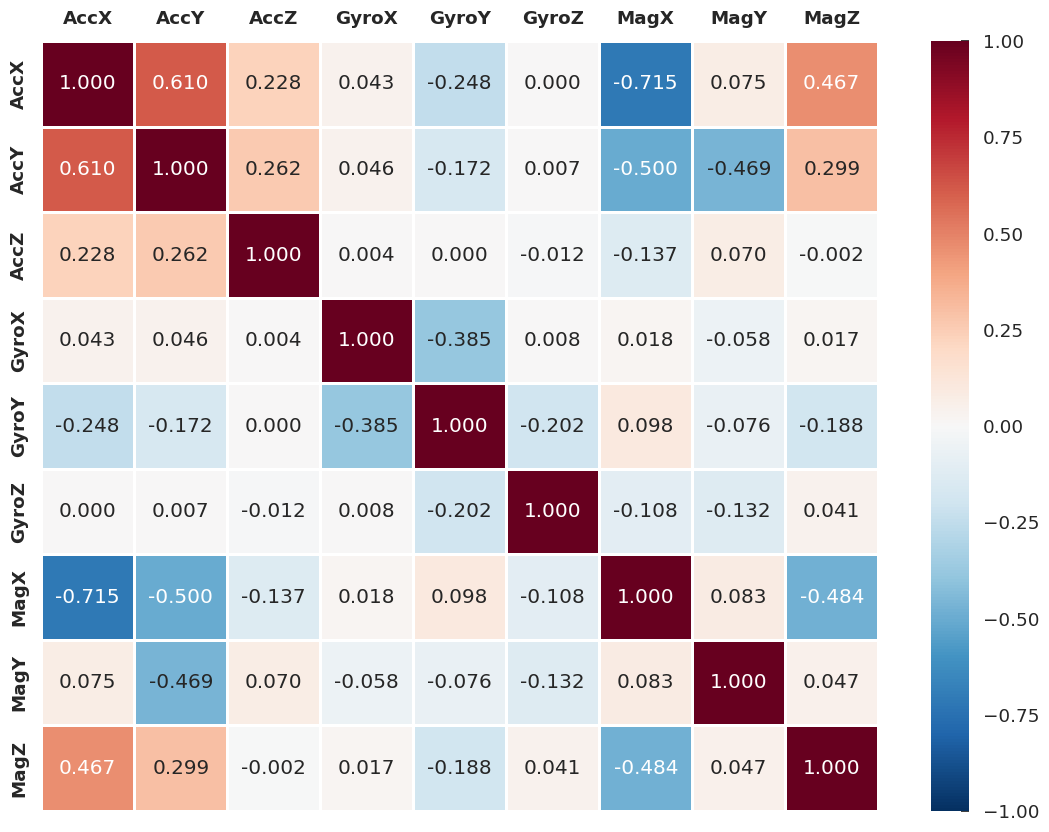

In [9]:
## Correlation Analysis
def cal_corr(arr):
    """
    Calculates the pearson correlation coefficient of given numpy arrays.
    Args:
        arr (list): A list containing numpy arrays.
    Returns:
        numpy_ndarray: A matrix that contains correlation coefficients.
    """
    corr_matrix = np.corrcoef(arr)
    return corr_matrix

# Extracting the columns as numpy arrays
np_accX = dataset_IMU['accX'].to_numpy()
np_accY = dataset_IMU['accY'].to_numpy()
np_accZ = dataset_IMU['accZ'].to_numpy()
np_gyroX = dataset_IMU['gyroX'].to_numpy()
np_gyroY = dataset_IMU['gyroY'].to_numpy()
np_gyroZ = dataset_IMU['gyroZ'].to_numpy()
np_magX = dataset_IMU['magX'].to_numpy()
np_magY = dataset_IMU['magY'].to_numpy()
np_magZ = dataset_IMU['magZ'].to_numpy()

# Set tick labels.
tick_labels = ["AccX", "AccY", "AccZ",
               "GyroX", "GyroY", "GyroZ",
               "MagX", "MagY", "MagZ"]
# Check how input features correlate with each other.
corr_mat = cal_corr([np_accX, np_accY, np_accZ, 
                     np_gyroX, np_gyroY, np_gyroZ, 
                     np_magX, np_magY, np_magZ])

plt.figure(figsize=(13.5, 10))
sns.set(font_scale=1.2)
ax = sns.heatmap(corr_mat, cmap='RdBu_r', annot=True, linewidths=1, vmin=-1, 
                 square=False, cbar=True, fmt='.3f', annot_kws={"fontweight": "light"},
                 xticklabels=tick_labels, yticklabels=tick_labels)

# Get the colorbar object.
cbar = ax.collections[0].colorbar
# Set the location of the colorbar ticks to the right.
cbar.ax.yaxis.set_tick_params(pad=10, direction='in', labelright=True, labelleft=False)

ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False, labeltop=True)
ax.set_xticklabels(ax.get_xticklabels(), fontweight='bold')
ax.set_yticklabels(ax.get_yticklabels(), fontweight='bold')
plt.savefig('/tf/figures/corr_heatmap_IMU_use_case_2.pdf', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

### Anomalous Data Preparation

We split data into 60%, 20% and 20%, and then normalize.

In [96]:
df_hitting_arm = pd.read_csv('/tf/datasets/IMU20.csv', header=None).drop(columns=[0, 1]).iloc[1:].reset_index(drop=True)
df_hitting_platform = pd.read_csv('/tf/datasets/IMU21.csv', header=None).drop(columns=[0, 1]).iloc[1:].reset_index(drop=True)
df_earthquake = pd.read_csv('/tf/datasets/IMU22.csv', header=None).drop(columns=[0, 1]).iloc[1:].reset_index(drop=True)
df_extra_weight = pd.read_csv('/tf/datasets/IMU23.csv', header=None).drop(columns=[0, 1]).iloc[1:].reset_index(drop=True)
df_magnet = pd.read_csv('/tf/datasets/IMU24.csv', header=None).drop(columns=[0, 1]).iloc[1:].reset_index(drop=True)

df_hitting_arm.columns = range(df_hitting_arm.shape[1])
df_hitting_platform.columns = range(df_hitting_platform.shape[1])
df_earthquake.columns = range(df_earthquake.shape[1])
df_extra_weight.columns = range(df_extra_weight.shape[1])
df_magnet.columns = range(df_magnet.shape[1])

df_hitting_arm = df_hitting_arm.apply(pd.to_numeric, errors='coerce')
df_hitting_platform = df_hitting_platform.apply(pd.to_numeric, errors='coerce')
df_earthquake = df_earthquake.apply(pd.to_numeric, errors='coerce')
df_extra_weight = df_extra_weight.apply(pd.to_numeric, errors='coerce')
df_magnet = df_magnet.apply(pd.to_numeric, errors='coerce')

print(f"Hitting Arm Length: {len(df_hitting_arm)}")
print(f"Hitting Platform Length: {len(df_hitting_platform)}")
print(f"Earthquake Length: {len(df_earthquake)}")
print(f"Extra Weigth Length: {len(df_extra_weight)}")
print(f"Magnet Length: {len(df_magnet)}")

# Define the feature names
feature_names = ["accX", "accY", "accZ", "gyroX", "gyroY", "gyroZ", "magX", "magY", "magZ"]

# Assign feature names to columns for each DataFrame
df_hitting_arm.columns = feature_names
df_hitting_platform.columns = feature_names
df_earthquake.columns = feature_names
df_extra_weight.columns = feature_names
df_magnet.columns = feature_names

# Calculate the indices for the train, validation, and test split
total_length = len(dataset_IMU)
train_end = int(total_length * 0.6)
val_end = train_end + int(total_length * 0.2)

# Split the dataset into train, validation, and test sets
train_data = dataset_IMU[:train_end]
validation_data = dataset_IMU[train_end:val_end]
test_data = dataset_IMU[val_end:]

# Initialize the scaler with the train data
scaler_X = StandardScaler().fit(train_data)

# List of datasets to transform
datasets = [
    train_data, 
    validation_data, 
    test_data, 
    df_hitting_arm, 
    df_hitting_platform, 
    df_earthquake, 
    df_extra_weight, 
    df_magnet
]

# Transform datasets and assign to corresponding variables
X_train, X_val, X_test, anol_ha, anol_hp, anol_eq, anol_ew, anol_mf = [
    pd.DataFrame(scaler_X.transform(data), 
                 columns=[
                     "accX", "accY", "accZ", 
                     "gyroX", "gyroY", "gyroZ", 
                     "magX", "magY", "magZ"
                 ]) for data in datasets
]

Hitting Arm Length: 11924
Hitting Platform Length: 14967
Earthquake Length: 11409
Extra Weigth Length: 10885
Magnet Length: 15118


We see that not all anomalous runs have the same length, as we created them separately.

### 1D-CNN - 2nd Use Case

In [49]:
patience = 3
batch_size = 1024
sequence_stride = 1
window_size_conv = 30
CONV_WIDTH = 3
MAX_EPOCHS = 10
NUM_FILTERS = 8
MAX_POOL_SIZE = 3
NUM_FEATURES = 9
OUT_SIZE = 1

def compile_and_fit(model, window, patience=patience):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min')

    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                  optimizer=tf.keras.optimizers.Adamax(),
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                        validation_data=window.val,
                        callbacks=[early_stopping])
    return history

def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
                 [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                  axis=-1)

    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
             data=data,
             targets=None,
             sequence_length=self.total_window_size,
             sequence_stride=sequence_stride,
             shuffle=False,
             batch_size=batch_size,)

    ds = ds.map(self.split_window)

    return ds

@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def anol_hitting_arm(self):
    return self.make_dataset(self.anol_hitting_arm_df)

@property
def anol_hitting_platform(self):
    return self.make_dataset(self.anol_hitting_platform_df)

@property
def anol_earthquake(self):
    return self.make_dataset(self.anol_earthquake_df)

@property
def anol_extra_weigth(self):
    return self.make_dataset(self.anol_extra_weigth_df)

@property
def anol_magnetic_field(self):
    return self.make_dataset(self.anol_magnetic_field_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result

class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df, val_df, test_df, anol_hitting_arm_df,
            anol_hitting_platform_df, anol_earthquake_df, anol_extra_weigth_df,
            anol_magnetic_field_df, label_columns=None):
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        self.anol_hitting_arm_df = anol_hitting_arm_df
        self.anol_hitting_platform_df = anol_hitting_platform_df
        self.anol_earthquake_df = anol_earthquake_df
        self.anol_extra_weigth_df = anol_extra_weigth_df
        self.anol_magnetic_field_df = anol_magnetic_field_df

        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

WindowGenerator.split_window = split_window
WindowGenerator.make_dataset = make_dataset
WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.anol_hitting_arm = anol_hitting_arm
WindowGenerator.anol_hitting_platform = anol_hitting_platform
WindowGenerator.anol_earthquake = anol_earthquake
WindowGenerator.anol_extra_weigth = anol_extra_weigth
WindowGenerator.anol_magnetic_field = anol_magnetic_field
WindowGenerator.example = example

# Set neural network model/parameters.
cnn_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(NUM_FILTERS, activation='relu', kernel_size=(CONV_WIDTH)),
    tf.keras.layers.Conv1D(NUM_FILTERS, activation='relu', kernel_size=(CONV_WIDTH)),
    tf.keras.layers.MaxPooling1D(pool_size=MAX_POOL_SIZE),
    # tf.keras.layers.Conv1D(NUM_FILTERS, activation='relu', kernel_size=(CONV_WIDTH)),
    # tf.keras.layers.Conv1D(NUM_FILTERS, activation='relu', kernel_size=(CONV_WIDTH)),
    # tf.keras.layers.MaxPooling1D(pool_size=MAX_POOL_SIZE),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(OUT_SIZE*NUM_FEATURES, kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_SIZE, NUM_FEATURES])
])

val_performance = {}
loss = {}
val_loss = {}

cnn_model.build(input_shape=(None, window_size_conv, 9))
cnn_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_18 (Conv1D)          (None, 28, 8)             224       
                                                                 
 conv1d_19 (Conv1D)          (None, 26, 8)             200       
                                                                 
 max_pooling1d_9 (MaxPoolin  (None, 8, 8)              0         
 g1D)                                                            
                                                                 
 flatten_9 (Flatten)         (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 9)                 585       
                                                                 
 reshape_9 (Reshape)         (None, 1, 9)              0         
                                                      

In [50]:
# Set window.
w1 = WindowGenerator(input_width=window_size_conv, label_width=OUT_SIZE, shift=OUT_SIZE,
                     train_df=X_train, val_df=X_val, test_df=X_test, 
                     anol_hitting_arm_df=anol_ha, anol_hitting_platform_df=anol_hp,
                     anol_earthquake_df=anol_eq, anol_extra_weigth_df=anol_ew, anol_magnetic_field_df=anol_mf)

# Verify the model input/output shape.
print('Input shape:', w1.example[0].shape)
print('Output shape:', cnn_model(w1.example[0]).shape)

Input shape: (1024, 30, 9)
Output shape: (1024, 1, 9)


In [51]:
# Train the model.
# Compile and evaluate.
history = compile_and_fit(cnn_model, w1)

Epoch 1/10
513/513 [==============================] - 29s 53ms/step - loss: 0.3549 - root_mean_squared_error: 0.5957 - val_loss: 0.1825 - val_root_mean_squared_error: 0.4272
Epoch 2/10
513/513 [==============================] - 25s 48ms/step - loss: 0.1574 - root_mean_squared_error: 0.3967 - val_loss: 0.1420 - val_root_mean_squared_error: 0.3768
Epoch 3/10
513/513 [==============================] - 22s 43ms/step - loss: 0.1331 - root_mean_squared_error: 0.3648 - val_loss: 0.1278 - val_root_mean_squared_error: 0.3574
Epoch 4/10
513/513 [==============================] - 22s 42ms/step - loss: 0.1220 - root_mean_squared_error: 0.3492 - val_loss: 0.1192 - val_root_mean_squared_error: 0.3452
Epoch 5/10
513/513 [==============================] - 21s 40ms/step - loss: 0.1145 - root_mean_squared_error: 0.3384 - val_loss: 0.1129 - val_root_mean_squared_error: 0.3361
Epoch 6/10
513/513 [==============================] - 20s 39ms/step - loss: 0.1090 - root_mean_squared_error: 0.3302 - val_loss: 0

Edit accordingly, to save or load. Conversion can be done **on purpose** here.

In [52]:
# # Adjust the input shape for 1D-CNN: batch size, window size for convolution, number of features
# BATCH_SIZE = 1
# STEPS = window_size_conv  # Using your variable for window size
# INPUT_SIZE = NUM_FEATURES

# # Wrap the model call with tf.function for optimization
# run_model = tf.function(lambda x: cnn_model(x))

# # Create a concrete function from the model to fix the input size
# concrete_func = run_model.get_concrete_function(
#     tf.TensorSpec([BATCH_SIZE, STEPS, INPUT_SIZE], cnn_model.inputs[0].dtype))

# # Model directory to save the TensorFlow SavedModel
# MODEL_DIR = "/tf/models/1d_cnn_v10"
# cnn_model.save(MODEL_DIR, save_format="tf", signatures=concrete_func)

# # Convert the SavedModel to a TensorFlow Lite model
# converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_DIR)
# tflite_model = converter.convert()

# # Path to save the TFLite model
# tflite_model_path = "/tf/models/1d_cnn_v10/1d_cnn_v10.tflite"

# # Save the TFLite model to the file
# with open(tflite_model_path, 'wb') as f:
#     f.write(tflite_model)

# # Get the size of the TFLite model file
# tflite_file_size = os.path.getsize(tflite_model_path)

# print(f"Model saved to: {tflite_model_path}")
# print(f"Size of the TFLite model: {tflite_file_size} bytes")

# !xxd -i /tf/models/1d_cnn_v10/1d_cnn_v10.tflite > /tf/models/1d_cnn_v10/1d_cnn_v10.cc

# Comment or uncomment accordingly.
# Path to save the model.
# Edit accordingly.
# model_path = "/tf/models/u2_model_1"
# cnn_model.save(model_path + ".keras")

INFO:tensorflow:Assets written to: /tf/models/1d_cnn_v10/assets


INFO:tensorflow:Assets written to: /tf/models/1d_cnn_v10/assets
2024-03-01 16:57:34.877451: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-03-01 16:57:34.877514: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-03-01 16:57:34.880606: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tf/models/1d_cnn_v10
2024-03-01 16:57:34.881871: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-03-01 16:57:34.881899: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tf/models/1d_cnn_v10
2024-03-01 16:57:34.886490: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-03-01 16:57:34.955018: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tf/models/1d_cnn_v10
2024-03-01 16:57:34.968844: I tensorflow/cc/saved_model/loade

Model saved to: /tf/models/1d_cnn_v10/1d_cnn_v10.tflite
Size of the TFLite model: 7444 bytes


171/171 [==============================] - 6s 35ms/step - loss: 0.0664 - root_mean_squared_error: 0.2577
{'1D-CNN': [0.06638843566179276, 0.25765955448150635]}


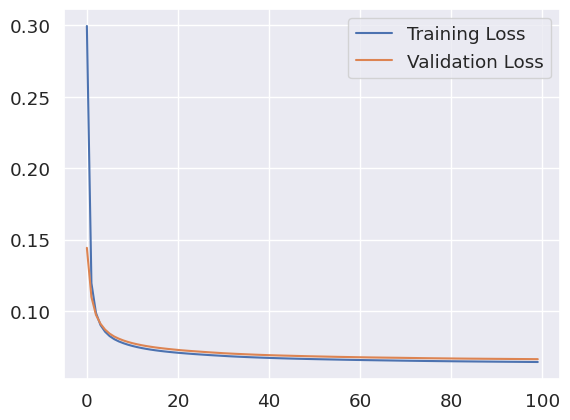

In [25]:
val_performance["1D-CNN"] = cnn_model.evaluate(w1.val, verbose=1, return_dict=False)
loss["1D-CNN"] = history.history["loss"]
val_loss["1D-CNN"] = history.history["val_loss"]
pprint(val_performance)

# Plot the loss graph.
plt.plot(loss["1D-CNN"], label='Training Loss')
plt.plot(val_loss["1D-CNN"], label='Validation Loss')
plt.legend()
plt.savefig("/tf/figures/u2_model_1.pdf", facecolor='white')
plt.show()

### Predictions
We need to **predict the test** data to decide on the RMSE value.

In [63]:
# RMSE window size.
window_size = 45

# Predict test data.
test_pred = cnn_model.predict(w1.test, batch_size=1024)
reshaped_test = test_pred.reshape(-1, 9)
rescaled_test = scaler_X.inverse_transform(reshaped_test)
adjusted_test = test_data.to_numpy()[window_size:]
rmse_per_row_test = np.sqrt(np.mean(np.square(rescaled_test - adjusted_test), axis=1))

# Predict hitting arm.
anomalous_preds_hitting_arm = cnn_model.predict(w1.anol_hitting_arm, batch_size=1024)
reshaped_ha = anomalous_preds_hitting_arm.reshape(-1, 9)
rescaled_ha = scaler_X.inverse_transform(reshaped_ha)
adjusted_ha = df_hitting_arm.to_numpy()[window_size:]
rmse_per_row_ha = np.sqrt(np.mean(np.square(rescaled_ha - adjusted_ha), axis=1))

# Predict hitting platform.
anomalous_preds_hitting_platform = cnn_model.predict(w1.anol_hitting_platform, batch_size=1024)
reshaped_hp = anomalous_preds_hitting_platform.reshape(-1, 9)
rescaled_hp = scaler_X.inverse_transform(reshaped_hp)
adjusted_hp = df_hitting_platform.to_numpy()[window_size:]
rmse_per_row_hp = np.sqrt(np.mean(np.square(rescaled_hp - adjusted_hp), axis=1))

# Predict earthquake.
anomalous_preds_earthquake = cnn_model.predict(w1.anol_earthquake, batch_size=1024)
reshaped_eq = anomalous_preds_earthquake.reshape(-1, 9)
rescaled_eq = scaler_X.inverse_transform(reshaped_eq)
adjusted_eq = df_earthquake.to_numpy()[window_size:]
rmse_per_row_eq = np.sqrt(np.mean(np.square(rescaled_eq - adjusted_eq), axis=1))

# Predict extra weight.
anomalous_preds_extra_weigth = cnn_model.predict(w1.anol_extra_weigth, batch_size=1024)
reshaped_ew = anomalous_preds_extra_weigth.reshape(-1, 9)
rescaled_ew = scaler_X.inverse_transform(reshaped_ew)
adjusted_ew = df_extra_weight.to_numpy()[window_size:]
rmse_per_row_ew = np.sqrt(np.mean(np.square(rescaled_ew - adjusted_ew), axis=1))

# Predict magnetic field.
anomalous_preds_magnetic_field = cnn_model.predict(w1.anol_magnetic_field, batch_size=1024)
reshaped_mf = anomalous_preds_magnetic_field.reshape(-1, 9)
rescaled_mf = scaler_X.inverse_transform(reshaped_mf)
adjusted_mf = df_magnet.to_numpy()[window_size:]
rmse_per_row_mf = np.sqrt(np.mean(np.square(rescaled_mf - adjusted_mf), axis=1))

15/15 [==============================] - 1s 27ms/step


### Setting a same threshold for all.

In [64]:
rmse_slider_size = [45, 50, 100, 150, 200, 265]
final_metrics = {}

for size in rmse_slider_size:
    # Calculate RMSE sliding sums for each anomaly type
    rmse_sliding_sums_test = np.convolve(rmse_per_row_test, np.ones(size), 'valid')
    rmse_sliding_sums_ha = np.convolve(rmse_per_row_ha, np.ones(size), 'valid')
    rmse_sliding_sums_hp = np.convolve(rmse_per_row_hp, np.ones(size), 'valid')
    rmse_sliding_sums_eq = np.convolve(rmse_per_row_eq, np.ones(size), 'valid')
    rmse_sliding_sums_ew = np.convolve(rmse_per_row_ew, np.ones(size), 'valid')
    rmse_sliding_sums_mf = np.convolve(rmse_per_row_mf, np.ones(size), 'valid')

    # Concatenate RMSE arrays
    combined_rmse = np.concatenate((
        rmse_sliding_sums_test, 
        rmse_sliding_sums_ha,
        rmse_sliding_sums_hp, 
        rmse_sliding_sums_eq,
        rmse_sliding_sums_ew, 
        rmse_sliding_sums_mf
    ))

    # Create labels
    labels = np.concatenate((
        np.zeros(len(rmse_sliding_sums_test)), 
        np.ones(len(rmse_sliding_sums_ha)),
        np.ones(len(rmse_sliding_sums_hp)), 
        np.ones(len(rmse_sliding_sums_eq)),
        np.ones(len(rmse_sliding_sums_ew)), 
        np.ones(len(rmse_sliding_sums_mf))
    ))

    # Limits to find the threshold
    min_rmse = np.min(combined_rmse)
    max_rmse = np.max(combined_rmse)

    # Initialize variables for the best metrics
    best_metrics = {'F1': 0}
    best_predictions = None

    for threshold in np.linspace(min_rmse - (max_rmse - min_rmse) / 200, max_rmse + (max_rmse - min_rmse) / 200, 1000):
        predictions = (combined_rmse > threshold).astype(int)
        f1 = f1_score(labels, predictions)

        if f1 > best_metrics['F1']:
            tn, fp, fn, tp = confusion_matrix(labels, predictions).ravel()
            best_metrics = {
                'Threshold': threshold,
                'F1': f1,
                'Precision': precision_score(labels, predictions),
                'Recall': recall_score(labels, predictions),
                'Accuracy': accuracy_score(labels, predictions),
                'FPR': fp / (fp + tn) if (fp + tn) > 0 else 0
            }
            best_predictions = predictions

    # Store the best metrics for the current slider size
    final_metrics[size] = best_metrics

# Print final metrics for each slider size
for size, metrics in final_metrics.items():
    print(f"Metrics for slider size {size}:")
    for key, value in metrics.items():
        print(f"    {key}: {value}")
    print()


Metrics for slider size 45:
    Threshold: 124.85332638154381
    F1: 0.6754977785091328
    Precision: 0.9839995205848865
    Recall: 0.5142660277490683
    Accuracy: 0.867825096140151
    FPR: 0.0030539415290296015

Metrics for slider size 50:
    Threshold: 141.82768912689613
    F1: 0.6449066824664607
    Precision: 0.9932861845321513
    Recall: 0.47744896840192375
    Accuracy: 0.8593873070670845
    FPR: 0.001178145964278157

Metrics for slider size 100:
    Threshold: 243.04735252593287
    F1: 0.8079844939877457
    Precision: 0.9713105702548699
    Recall: 0.6916785933346964
    Accuracy: 0.9123137458889858
    FPR: 0.007431307601215096

Metrics for slider size 150:
    Threshold: 340.83366108139546
    F1: 0.9121202662459822
    Precision: 0.9792768639953626
    Recall: 0.8535834399128417
    Accuracy: 0.9562465348364443
    FPR: 0.006546457531001253

Metrics for slider size 200:
    Threshold: 465.2150866788286
    F1: 0.9243976879401183
    Precision: 1.0
    Recall: 0.859

### Setting a threshold per pair.

In [67]:
rmse_slider_size = [45, 50, 100, 150, 200, 265]
anomaly_types = ["HA", "HP", "EQ", "EW", "MF"]  # Excluding "Non-Anomalous" as it's used in every pair

final_metrics = {}

for size in rmse_slider_size:
    # Calculate RMSE sliding sum for non-anomalous data
    rmse_sliding_sums_test = np.convolve(rmse_per_row_test, np.ones(size), 'valid')
    test_labels = np.zeros(len(rmse_sliding_sums_test))

    for anomaly_type in anomaly_types:
        # Calculate RMSE sliding sums for each anomaly type
        anomaly_rmse = {
            "HA": np.convolve(rmse_per_row_ha, np.ones(size), 'valid'),
            "HP": np.convolve(rmse_per_row_hp, np.ones(size), 'valid'),
            "EQ": np.convolve(rmse_per_row_eq, np.ones(size), 'valid'),
            "EW": np.convolve(rmse_per_row_ew, np.ones(size), 'valid'),
            "MF": np.convolve(rmse_per_row_mf, np.ones(size), 'valid')
        }[anomaly_type]

        # Concatenate RMSE arrays for non-anomalous and current anomaly
        combined_rmse = np.concatenate((rmse_sliding_sums_test, anomaly_rmse))

        # Create labels for non-anomalous and current anomaly
        labels = np.concatenate((test_labels, np.ones(len(anomaly_rmse))))

        # Initialize variables for the best metrics for the current size and anomaly type
        best_metrics = {'F1': 0}

        # Find the best threshold for the current size and anomaly type
        min_rmse = np.min(combined_rmse)
        max_rmse = np.max(combined_rmse)

        for threshold in np.linspace(min_rmse - (max_rmse - min_rmse) / 200, max_rmse + (max_rmse - min_rmse) / 200, 1000):
            predictions = (combined_rmse > threshold).astype(int)

            f1 = f1_score(labels, predictions, zero_division=0)

            if f1 > best_metrics['F1']:
                tn, fp, fn, tp = confusion_matrix(labels, predictions).ravel()
                best_metrics = {
                    'Threshold': threshold,
                    'F1': f1,
                    'Precision': precision_score(labels, predictions, zero_division=0),
                    'Recall': recall_score(labels, predictions, zero_division=0),
                    'Accuracy': accuracy_score(labels, predictions),
                    'FPR': fp / (fp + tn) if (fp + tn) > 0 else 0
                }

        # Store the best metrics for the current slider size and anomaly type
        final_metrics[(size, anomaly_type)] = best_metrics

# Print final metrics for each slider size and anomaly type
for (size, anomaly_type), metrics in final_metrics.items():
    print(f"Metrics for slider size {size} and anomaly type {anomaly_type}:")
    for key, value in metrics.items():
        print(f"    {key}: {value}")
    print()

Metrics for slider size 45 and anomaly type HA:
    Threshold: 119.98861794468264
    F1: 0.6461347021309691
    Precision: 0.8361513687600645
    Recall: 0.526489226869455
    Accuracy: 0.9634422655618107
    FPR: 0.00698288877705083

Metrics for slider size 45 and anomaly type HP:
    Threshold: 109.71295676891737
    F1: 0.5488375340361656
    Precision: 0.5709616502033701
    Recall: 0.5283640274230408
    Accuracy: 0.9318835843865623
    FPR: 0.033782083543029695

Metrics for slider size 45 and anomaly type EQ:
    Threshold: 115.68750793809697
    F1: 0.7458673932788373
    Precision: 0.7674766355140187
    Recall: 0.7254416961130742
    Accuracy: 0.9699424200756274
    FPR: 0.014228851168961889

Metrics for slider size 45 and anomaly type EW:
    Threshold: 107.6419873121544
    F1: 0.41815053763440857
    Precision: 0.39031636422033084
    Recall: 0.450259355316784
    Accuracy: 0.9271324844332407
    FPR: 0.043424303426819785

Metrics for slider size 45 and anomaly type MF:
  

### TinyML Implementation of 1D-CNN

First we apply all three offered quantization models to compare them.

In [262]:
import logging

# Enable verbose logging
tf.get_logger().setLevel(logging.DEBUG)

# Convert X_train to float32
X_train = tf.cast(X_train, tf.float32)

# Reshape X_train into sequences of 45 timesteps
window_size_conv = 45
num_features = 9  # Number of features in X_train
num_sequences = len(X_train) // window_size_conv

reshaped_X_train = tf.reshape(X_train[:num_sequences * window_size_conv], [-1, window_size_conv, num_features])

def representative_data_gen():
    for input_value in tf.data.Dataset.from_tensor_slices(reshaped_X_train).batch(1).take(100):
        # Yield the reshaped tensor without adding extra dimensions
        yield [input_value]

# Testing the function to see the output shapes
for data in representative_data_gen():
    print("Data shape:", data[0].shape)
    break  # Breaking after the first print to check the shape of the first batch

converter = tf.lite.TFLiteConverter.from_keras_model(cnn_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_model_full_int = converter.convert()
tflite_path_full_int_quantized = '/tf/models/tinyML_models/model_v1_quantized_full_int.tflite'

# Save the full-int-quantized TFLite model
with open(tflite_path_full_int_quantized, 'wb') as f:
    f.write(tflite_model_full_int)

# Dynamic Range Quantization
converter_dynamic_range = tf.lite.TFLiteConverter.from_keras_model(cnn_model)
converter_dynamic_range.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model_dynamic_range = converter_dynamic_range.convert()
tflite_path_dynamic_range_quantized = '/tf/models/tinyML_models/model_v1_quantized_dynamic_range.tflite'

# Save the dynamic range quantized TFLite model
with open(tflite_path_dynamic_range_quantized, 'wb') as f:
    f.write(tflite_model_dynamic_range)

# Float16 Quantization
converter_float16 = tf.lite.TFLiteConverter.from_keras_model(cnn_model)
converter_float16.optimizations = [tf.lite.Optimize.DEFAULT]
converter_float16.target_spec.supported_types = [tf.float16]

tflite_model_float16 = converter_float16.convert()
tflite_path_float16_quantized = '/tf/models/tinyML_models/model_v1_quantized_float16.tflite'

# Save the float16 quantized TFLite model
with open(tflite_path_float16_quantized, 'wb') as f:
    f.write(tflite_model_float16)

# The one where no quantization is applied.
converter_nq = tf.lite.TFLiteConverter.from_keras_model(cnn_model)

tflite_model_nq = converter_nq.convert()
tflite_path_non_quantized = '/tf/models/tinyML_models/model_v1_non_quantized.tflite'

# Save the no quantized TFLite model
with open(tflite_path_non_quantized, 'wb') as f:
    f.write(tflite_model_nq)

Data shape: (1, 45, 9)
INFO:tensorflow:Assets written to: /tmp/tmpl2680aot/assets


INFO:tensorflow:Assets written to: /tmp/tmpl2680aot/assets
/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
2024-01-30 19:11:00.766239: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-01-30 19:11:00.766275: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-01-30 19:11:00.768746: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpl2680aot
2024-01-30 19:11:00.769902: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-01-30 19:11:00.769922: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpl2680aot
2024-01-30 19:11:00.773047: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-01-30 19:11:00.822639: I t

INFO:tensorflow:Assets written to: /tmp/tmp3f4wneu6/assets


INFO:tensorflow:Assets written to: /tmp/tmp3f4wneu6/assets
2024-01-30 19:11:01.629654: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-01-30 19:11:01.629680: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-01-30 19:11:01.629839: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp3f4wneu6
2024-01-30 19:11:01.630713: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-01-30 19:11:01.630728: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp3f4wneu6
2024-01-30 19:11:01.633036: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-01-30 19:11:01.664308: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp3f4wneu6
2024-01-30 19:11:01.674028: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpfn2e7gqq/assets


INFO:tensorflow:Assets written to: /tmp/tmpfn2e7gqq/assets
2024-01-30 19:11:02.518536: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-01-30 19:11:02.518563: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-01-30 19:11:02.518728: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpfn2e7gqq
2024-01-30 19:11:02.519587: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-01-30 19:11:02.519608: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpfn2e7gqq
2024-01-30 19:11:02.521805: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-01-30 19:11:02.553359: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpfn2e7gqq
2024-01-30 19:11:02.563179: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpowkonksf/assets


INFO:tensorflow:Assets written to: /tmp/tmpowkonksf/assets
2024-01-30 19:11:03.990806: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-01-30 19:11:03.990835: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-01-30 19:11:03.991012: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpowkonksf
2024-01-30 19:11:03.993112: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-01-30 19:11:03.993129: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpowkonksf
2024-01-30 19:11:03.998592: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-01-30 19:11:04.037847: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpowkonksf
2024-01-30 19:11:04.051764: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Now we compare the **sizes** of these three models.

In [263]:
# Paths for the TFLite models
tflite_path_full_int_quantized = '/tf/models/tinyML_models/model_v1_quantized_full_int.tflite'
tflite_path_dynamic_range_quantized = '/tf/models/tinyML_models/model_v1_quantized_dynamic_range.tflite'
tflite_path_float16_quantized = '/tf/models/tinyML_models/model_v1_quantized_float16.tflite'
tflite_path_non_quantized = '/tf/models/tinyML_models/model_v1_non_quantized.tflite'

# Get the size of the full integer quantized model
size_full_int_quantized = os.path.getsize(tflite_path_full_int_quantized)
print(f"The size of the full integer quantized TFLite model is {size_full_int_quantized} bytes")

# Get the size of the dynamic range quantized model
size_dynamic_range_quantized = os.path.getsize(tflite_path_dynamic_range_quantized)
print(f"The size of the dynamic range quantized TFLite model is {size_dynamic_range_quantized} bytes")

# Get the size of the float16 quantized model
size_float16_quantized = os.path.getsize(tflite_path_float16_quantized)
print(f"The size of the float16 quantized TFLite model is {size_float16_quantized} bytes")

# Get the size of the non-quantized model
size_non_quantized = os.path.getsize(tflite_path_non_quantized)
print(f"The size of the non-quantized TFLite model is {size_non_quantized} bytes")

The size of the full integer quantized TFLite model is 8384 bytes
The size of the dynamic range quantized TFLite model is 11696 bytes
The size of the float16 quantized TFLite model is 9472 bytes
The size of the non-quantized TFLite model is 11692 bytes


#### Model Creating & RMSE Calculation
Here we compare the performance of generated **TFLite models.**

In [253]:
# Load the TFLite model
interpreter_full_int = tf.lite.Interpreter(model_path=tflite_path_full_int_quantized)
interpreter_dynamic_range = tf.lite.Interpreter(model_path=tflite_path_dynamic_range_quantized)
interpreter_float_16 = tf.lite.Interpreter(model_path=tflite_path_float16_quantized)
interpreter_nq = tf.lite.Interpreter(model_path=tflite_path_non_quantized)

interpreter_full_int.allocate_tensors()
interpreter_dynamic_range.allocate_tensors()
interpreter_float_16.allocate_tensors()
interpreter_nq.allocate_tensors()

# Get input and output tensors.
input_details_full_int = interpreter_full_int.get_input_details()
output_details_full_int = interpreter_full_int.get_output_details()

input_details_dynamic_range = interpreter_dynamic_range.get_input_details()
output_details_dynamic_range = interpreter_dynamic_range.get_output_details()

input_details_float_16 = interpreter_float_16.get_input_details()
output_details_float_16 = interpreter_float_16.get_output_details()

input_details_nq = interpreter_nq.get_input_details()
output_details_nq = interpreter_nq.get_output_details()

In [254]:
# Prepare the anomaly data for TFLite
anol_hitting_arm_data = w1.anol_hitting_arm.unbatch().batch(1)
anol_hitting_platform_data = w1.anol_hitting_platform.unbatch().batch(1)
anol_eq = w1.anol_earthquake.unbatch().batch(1)
anol_ew = w1.anol_extra_weigth.unbatch().batch(1)
anol_mag = w1.anol_magnetic_field.unbatch().batch(1)

# Run inference for each model and collect predictions
tflite_predictions_full_int = []
tflite_predictions_dynamic_range = []
tflite_predictions_float_16 = []
tflite_predictions_nq = []

for x, _ in anol_hitting_arm_data:
    
    input_data = x.numpy()  # Original float32 data
    
    # Preprocess and infer for full integer quantized model
    input_data_uint8 = (input_data * 255).astype(np.uint8)  # Convert to UINT8 for full int model
    interpreter_full_int.set_tensor(input_details_full_int[0]['index'], input_data_uint8)
    interpreter_full_int.invoke()
    tflite_predictions_full_int.append(interpreter_full_int.get_tensor(output_details_full_int[0]['index'])[0])

    # Preprocess and infer for dynamic range quantized model
    interpreter_dynamic_range.set_tensor(input_details_dynamic_range[0]['index'], input_data)
    interpreter_dynamic_range.invoke()
    tflite_predictions_dynamic_range.append(interpreter_dynamic_range.get_tensor(output_details_dynamic_range[0]['index'])[0])

    # Preprocess and infer for float16 quantized model
    interpreter_float_16.set_tensor(input_details_float_16[0]['index'], input_data)
    interpreter_float_16.invoke()
    tflite_predictions_float_16.append(interpreter_float_16.get_tensor(output_details_float_16[0]['index'])[0])

    # Preprocess and infer for non-quantized model
    interpreter_nq.set_tensor(input_details_nq[0]['index'], input_data)
    interpreter_nq.invoke()
    tflite_predictions_nq.append(interpreter_nq.get_tensor(output_details_nq[0]['index'])[0])

# Convert predictions to a numpy array for further analysis or comparison
tf_pred_full_int = np.array(tflite_predictions_full_int)
tf_pred_full_int_normalized = tf_pred_full_int.astype(np.float32) / 255.0

# Check if shapes are compatible
if tf_pred_full_int_normalized.shape == anomalous_preds_hitting_arm.shape:
    
    mse_full_int = np.mean((tf_pred_full_int_normalized - anomalous_preds_hitting_arm)**2)
    mse_dynamic_range = np.mean((tflite_predictions_dynamic_range - anomalous_preds_hitting_arm)**2)
    mse_float_16 = np.mean((tflite_predictions_float_16 - anomalous_preds_hitting_arm)**2)
    mse_nq = np.mean((tflite_predictions_nq - anomalous_preds_hitting_arm)**2)

    print(f"MSE Full Int: {mse_full_int}")
    print(f"MSE Dynamic Range: {mse_dynamic_range}")
    print(f"MSE Float 16: {mse_float_16}")
    print(f"MSE nq: {mse_nq}")

else:
    print("Error: The shapes of the predictions do not match.")

MSE Full Int: 1.1691678762435913
MSE Dynamic Range: 7.861295165181859e-14
MSE Float 16: 4.182405461961025e-07
MSE nq: 7.861295165181859e-14


It seems like on full-int quantization suffer from model accuracy. We now do anomaly detection for each.

In [255]:
# Prepare the anomaly data for TFLite
test_data_tflite = w1.test.unbatch().batch(1)
anol_hitting_arm_data = w1.anol_hitting_arm.unbatch().batch(1)
anol_hitting_platform_data = w1.anol_hitting_platform.unbatch().batch(1)
anol_eq = w1.anol_earthquake.unbatch().batch(1)
anol_ew = w1.anol_extra_weigth.unbatch().batch(1)
anol_mag = w1.anol_magnetic_field.unbatch().batch(1)

# Function to run inference for a given anomaly dataset
def run_inference(anomaly_data, interpreter, input_details, output_details, is_full_int=False):
    predictions = []
    for x, _ in anomaly_data:
        input_data = x.numpy()

        if is_full_int:
            # Convert to UINT8 for full integer quantized model
            input_data = (input_data * 255).astype(np.uint8)

        interpreter.set_tensor(input_details[0]['index'], input_data)
        interpreter.invoke()
        predictions.append(interpreter.get_tensor(output_details[0]['index'])[0])
    
    return np.array(predictions)

# Collect predictions for each anomaly type and model
all_predictions = {
    "hitting_arm": {},
    "hitting_platform": {},
    "earthquake": {},
    "extra_weight": {},
    "magnetic_field": {}
}

for anomaly_name, anomaly_data in [
    ("hitting_arm", anol_hitting_arm_data),
    ("hitting_platform", anol_hitting_platform_data),
    ("earthquake", anol_eq),
    ("extra_weight", anol_ew),
    ("magnetic_field", anol_mag)]:

    all_predictions[anomaly_name]["full_int"] = run_inference(anomaly_data, interpreter_full_int, input_details_full_int, output_details_full_int, is_full_int=True)
    all_predictions[anomaly_name]["dynamic_range"] = run_inference(anomaly_data, interpreter_dynamic_range, input_details_dynamic_range, output_details_dynamic_range)
    all_predictions[anomaly_name]["float_16"] = run_inference(anomaly_data, interpreter_float_16, input_details_float_16, output_details_float_16)
    all_predictions[anomaly_name]["non_quantized"] = run_inference(anomaly_data, interpreter_nq, input_details_nq, output_details_nq)


# Run inference for the test data using the full integer quantized model
test_predictions_full_int = run_inference(test_data_tflite, interpreter_full_int, input_details_full_int, output_details_full_int, is_full_int=True)
test_predictions_dr = run_inference(test_data_tflite, interpreter_dynamic_range, input_details_dynamic_range, output_details_dynamic_range, is_full_int=False)
test_predictions_f16 = run_inference(test_data_tflite, interpreter_float_16, input_details_float_16, output_details_float_16, is_full_int=False)
test_predictions_nq = run_inference(test_data_tflite, interpreter_nq, input_details_nq, output_details_nq, is_full_int=False)

# Add test predictions to all_predictions dictionary
all_predictions["test_data"] = {
    "full_int": test_predictions_full_int,
    "dynamic_range": test_predictions_dr,
    "float_16": test_predictions_f16,
    "non_quantized": test_predictions_nq
}

In [256]:
def calculate_rmse(tflite_predictions, df_actual, scaler, window_size, is_normalized=False, is_float16=False):
    if is_normalized:
        if is_float16:
            # Adjust for float16 (if necessary, depending on how the data was scaled)
            normalized_predictions = tflite_predictions.astype(np.float32)
        else:
            # Normalize for full integer quantized models
            normalized_predictions = tflite_predictions.astype(np.float32) / 255.0
    else:
        normalized_predictions = tflite_predictions

    reshaped_predictions = normalized_predictions.reshape(-1, 9)
    rescaled_predictions = scaler.inverse_transform(reshaped_predictions)
    adjusted_actual = df_actual.to_numpy()[window_size:]
    rmse_per_row = np.sqrt(np.mean(np.square(rescaled_predictions - adjusted_actual), axis=1))
    return rmse_per_row

# Calculate RMSEs for full int
rmse_per_row_test_fi = calculate_rmse(all_predictions["test_data"]["full_int"], test_data, scaler_X, window_size, is_normalized=True)
rmse_per_row_fi_ha = calculate_rmse(all_predictions["hitting_arm"]["full_int"], df_hitting_arm, scaler_X, window_size, is_normalized=True)
rmse_per_row_fi_hp = calculate_rmse(all_predictions["hitting_platform"]["full_int"], df_hitting_platform, scaler_X, window_size, is_normalized=True)
rmse_per_row_fi_eq = calculate_rmse(all_predictions["earthquake"]["full_int"], df_earthquake, scaler_X, window_size, is_normalized=True)
rmse_per_row_fi_ew = calculate_rmse(all_predictions["extra_weight"]["full_int"], df_extra_weight, scaler_X, window_size, is_normalized=True)
rmse_per_row_fi_mf = calculate_rmse(all_predictions["magnetic_field"]["full_int"], df_magnet, scaler_X, window_size, is_normalized=True)

# Calculate RMSE for nq
rmse_per_row_test_nq = calculate_rmse(all_predictions["test_data"]["non_quantized"], test_data, scaler_X, window_size)
rmse_per_row_nq_ha = calculate_rmse(all_predictions["hitting_arm"]["non_quantized"], df_hitting_arm, scaler_X, window_size)
rmse_per_row_nq_hp = calculate_rmse(all_predictions["hitting_platform"]["non_quantized"], df_hitting_platform, scaler_X, window_size)
rmse_per_row_nq_eq = calculate_rmse(all_predictions["earthquake"]["non_quantized"], df_earthquake, scaler_X, window_size)
rmse_per_row_nq_ew = calculate_rmse(all_predictions["extra_weight"]["non_quantized"], df_extra_weight, scaler_X, window_size)
rmse_per_row_nq_mf = calculate_rmse(all_predictions["magnetic_field"]["non_quantized"], df_magnet, scaler_X, window_size)

# Calculate RMSE for float16
rmse_per_row_test_f16 = calculate_rmse(all_predictions["test_data"]["float_16"], test_data, scaler_X, window_size)
rmse_per_row_f16_ha = calculate_rmse(all_predictions["hitting_arm"]["float_16"], df_hitting_arm, scaler_X, window_size)
rmse_per_row_f16_hp = calculate_rmse(all_predictions["hitting_platform"]["float_16"], df_hitting_platform, scaler_X, window_size)
rmse_per_row_f16_eq = calculate_rmse(all_predictions["earthquake"]["float_16"], df_earthquake, scaler_X, window_size)
rmse_per_row_f16_ew = calculate_rmse(all_predictions["extra_weight"]["float_16"], df_extra_weight, scaler_X, window_size)
rmse_per_row_f16_mf = calculate_rmse(all_predictions["magnetic_field"]["float_16"], df_magnet, scaler_X, window_size)

# Calculate RMSE for Dynamic Range
rmse_per_row_test_dr = calculate_rmse(all_predictions["test_data"]["dynamic_range"], test_data, scaler_X, window_size)
rmse_per_row_dr_ha = calculate_rmse(all_predictions["hitting_arm"]["dynamic_range"], df_hitting_arm, scaler_X, window_size)
rmse_per_row_dr_hp = calculate_rmse(all_predictions["hitting_platform"]["dynamic_range"], df_hitting_platform, scaler_X, window_size)
rmse_per_row_dr_eq = calculate_rmse(all_predictions["earthquake"]["dynamic_range"], df_earthquake, scaler_X, window_size)
rmse_per_row_dr_ew = calculate_rmse(all_predictions["extra_weight"]["dynamic_range"], df_extra_weight, scaler_X, window_size)
rmse_per_row_dr_mf = calculate_rmse(all_predictions["magnetic_field"]["dynamic_range"], df_magnet, scaler_X, window_size)

#### Anomaly Detection on Full Int

In [228]:
rmse_slider_size = [45, 50, 100, 150, 200, 265]
final_metrics = {}

for size in rmse_slider_size:
    # Calculate RMSE sliding sums for each anomaly type
    rmse_sliding_sums_test_fi = np.convolve(rmse_per_row_test_fi, np.ones(size), 'valid')
    rmse_sliding_sums_fi_ha = np.convolve(rmse_per_row_fi_ha, np.ones(size), 'valid')
    rmse_sliding_sums_fi_hp = np.convolve(rmse_per_row_fi_hp, np.ones(size), 'valid')
    rmse_sliding_sums_fi_eq = np.convolve(rmse_per_row_fi_eq, np.ones(size), 'valid')
    rmse_sliding_sums_fi_ew = np.convolve(rmse_per_row_fi_ew, np.ones(size), 'valid')
    rmse_sliding_sums_fi_mf = np.convolve(rmse_per_row_fi_mf, np.ones(size), 'valid')

    # Concatenate RMSE arrays
    combined_rmse = np.concatenate((
        rmse_sliding_sums_test_fi, 
        rmse_sliding_sums_fi_ha,
        rmse_sliding_sums_fi_hp, 
        rmse_sliding_sums_fi_eq,
        rmse_sliding_sums_fi_ew, 
        rmse_sliding_sums_fi_mf
    ))

    # Create labels
    labels = np.concatenate((
        np.zeros(len(rmse_sliding_sums_test_fi)), 
        np.ones(len(rmse_sliding_sums_fi_ha)),
        np.ones(len(rmse_sliding_sums_fi_hp)), 
        np.ones(len(rmse_sliding_sums_fi_eq)),
        np.ones(len(rmse_sliding_sums_fi_ew)), 
        np.ones(len(rmse_sliding_sums_fi_mf))
    ))

    # Limits to find the threshold
    min_rmse = np.min(combined_rmse)
    max_rmse = np.max(combined_rmse)

    # Initialize variables for the best metrics
    best_metrics = {'F1': 0}
    best_predictions = None

    for threshold in np.linspace(min_rmse - (max_rmse - min_rmse) / 200, max_rmse + (max_rmse - min_rmse) / 200, 1000):
        predictions = (combined_rmse > threshold).astype(int)
        f1 = f1_score(labels, predictions)

        if f1 > best_metrics['F1']:
            tn, fp, fn, tp = confusion_matrix(labels, predictions).ravel()
            best_metrics = {
                'Threshold': threshold,
                'F1': f1,
                'Precision': precision_score(labels, predictions),
                'Recall': recall_score(labels, predictions),
                'Accuracy': accuracy_score(labels, predictions),
                'FPR': fp / (fp + tn) if (fp + tn) > 0 else 0
            }
            best_predictions = predictions

    # Store the best metrics for the current slider size
    final_metrics[size] = best_metrics

# Print final metrics for each slider size
for size, metrics in final_metrics.items():
    print(f"Metrics for slider size {size}:")
    for key, value in metrics.items():
        print(f"    {key}: {value}")
    print()

Metrics for slider size 45:
    Threshold: 393.6680197213897
    F1: 0.42219264323664957
    Precision: 0.2765808610999111
    Recall: 0.8915875849541169
    Accuracy: 0.347164389185385
    FPR: 0.8516607951685958

Metrics for slider size 50:
    Threshold: 227.33950383788263
    F1: 0.4220126472231312
    Precision: 0.26743728109131737
    Recall: 1.0
    Accuracy: 0.26743728109131737
    FPR: 1.0

Metrics for slider size 100:
    Threshold: 909.0374152898135
    F1: 0.42198027951525297
    Precision: 0.26921007178009426
    Recall: 0.9756224147964079
    Accuracy: 0.2871040002684744
    FPR: 0.9633411708171006

Metrics for slider size 150:
    Threshold: 2662.4326920932735
    F1: 0.44064265536723163
    Precision: 0.35123420304539954
    Recall: 0.5911136374401971
    Accuracy: 0.6007879571915794
    FPR: 0.39570589009504953

Metrics for slider size 200:
    Threshold: 3109.399021976009
    F1: 0.43784442033140164
    Precision: 0.3122600702892674
    Recall: 0.7324001712030183
    

#### Anomaly Detection on No-Quantized

In [248]:
rmse_slider_size = [45, 50, 100, 150, 200, 265]
final_metrics_nq = {}  # To store metrics for non-quantized model

for size in rmse_slider_size:
    # Calculate RMSE sliding sums for each anomaly type - Non Quantized
    rmse_sliding_sums_test_nq = np.convolve(rmse_per_row_test_nq, np.ones(size), 'valid')
    rmse_sliding_sums_nq_ha = np.convolve(rmse_per_row_nq_ha, np.ones(size), 'valid')
    rmse_sliding_sums_nq_hp = np.convolve(rmse_per_row_nq_hp, np.ones(size), 'valid')
    rmse_sliding_sums_nq_eq = np.convolve(rmse_per_row_nq_eq, np.ones(size), 'valid')
    rmse_sliding_sums_nq_ew = np.convolve(rmse_per_row_nq_ew, np.ones(size), 'valid')
    rmse_sliding_sums_nq_mf = np.convolve(rmse_per_row_nq_mf, np.ones(size), 'valid')

    # Concatenate RMSE arrays - Non Quantized
    combined_rmse_nq = np.concatenate((
        rmse_sliding_sums_test_nq,
        rmse_sliding_sums_nq_ha,
        rmse_sliding_sums_nq_hp,
        rmse_sliding_sums_nq_eq,
        rmse_sliding_sums_nq_ew,
        rmse_sliding_sums_nq_mf
    ))

    # Create labels - Non Quantized
    labels_nq = np.concatenate((
        np.zeros(len(rmse_sliding_sums_test_nq)),
        np.ones(len(rmse_sliding_sums_nq_ha)),
        np.ones(len(rmse_sliding_sums_nq_hp)),
        np.ones(len(rmse_sliding_sums_nq_eq)),
        np.ones(len(rmse_sliding_sums_nq_ew)),
        np.ones(len(rmse_sliding_sums_nq_mf))
    ))

    # Limits to find the threshold - Non Quantized
    min_rmse_nq = np.min(combined_rmse_nq)
    max_rmse_nq = np.max(combined_rmse_nq)

    # Initialize variables for the best metrics - Non Quantized
    best_metrics_nq = {'F1': 0}
    best_predictions_nq = None

    for threshold in np.linspace(min_rmse_nq - (max_rmse_nq - min_rmse_nq) / 200, max_rmse_nq + (max_rmse_nq - min_rmse_nq) / 200, 1000):
        predictions_nq = (combined_rmse_nq > threshold).astype(int)
        f1_nq = f1_score(labels_nq, predictions_nq)

        if f1_nq > best_metrics_nq['F1']:
            tn_nq, fp_nq, fn_nq, tp_nq = confusion_matrix(labels_nq, predictions_nq).ravel()
            best_metrics_nq = {
                'Threshold': threshold,
                'F1': f1_nq,
                'Precision': precision_score(labels_nq, predictions_nq),
                'Recall': recall_score(labels_nq, predictions_nq),
                'Accuracy': accuracy_score(labels_nq, predictions_nq),
                'FPR': fp_nq / (fp_nq + tn_nq) if (fp_nq + tn_nq) > 0 else 0
            }
            best_predictions_nq = predictions_nq

    # Store the best metrics for the current slider size - Non Quantized
    final_metrics_nq[size] = best_metrics_nq

# Print final metrics for each slider size - Non Quantized
for size, metrics in final_metrics_nq.items():
    print(f"Metrics for slider size {size} (NQ):")
    for key, value in metrics.items():
        print(f"    {key}: {value}")
    print()

Metrics for slider size 45 (NQ):
    Threshold: 124.85332927125415
    F1: 0.6754977785091328
    Precision: 0.9839995205848865
    Recall: 0.5142660277490683
    Accuracy: 0.867825096140151
    FPR: 0.0030539415290296015

Metrics for slider size 50 (NQ):
    Threshold: 141.82770124748075
    F1: 0.6449066824664607
    Precision: 0.9932861845321513
    Recall: 0.47744896840192375
    Accuracy: 0.8593873070670845
    FPR: 0.001178145964278157

Metrics for slider size 100 (NQ):
    Threshold: 243.04733052259155
    F1: 0.8079844939877457
    Precision: 0.9713105702548699
    Recall: 0.6916785933346964
    Accuracy: 0.9123137458889858
    FPR: 0.007431307601215096

Metrics for slider size 150 (NQ):
    Threshold: 340.8336374388723
    F1: 0.9121202662459822
    Precision: 0.9792768639953626
    Recall: 0.8535834399128417
    Accuracy: 0.9562465348364443
    FPR: 0.006546457531001253

Metrics for slider size 200 (NQ):
    Threshold: 465.2150816977879
    F1: 0.9243976879401183
    Precisio

#### Anomaly Detection on Float16

In [257]:
rmse_slider_size = [45, 50, 100, 150, 200, 265]
final_metrics_f16 = {}  # To store metrics for non-quantized model

for size in rmse_slider_size:
    # Calculate RMSE sliding sums for each anomaly type - F16
    rmse_sliding_sums_test_f16 = np.convolve(rmse_per_row_test_f16, np.ones(size), 'valid')
    rmse_sliding_sums_f16_ha = np.convolve(rmse_per_row_f16_ha, np.ones(size), 'valid')
    rmse_sliding_sums_f16_hp = np.convolve(rmse_per_row_f16_hp, np.ones(size), 'valid')
    rmse_sliding_sums_f16_eq = np.convolve(rmse_per_row_f16_eq, np.ones(size), 'valid')
    rmse_sliding_sums_f16_ew = np.convolve(rmse_per_row_f16_ew, np.ones(size), 'valid')
    rmse_sliding_sums_f16_mf = np.convolve(rmse_per_row_f16_mf, np.ones(size), 'valid')

    # Concatenate RMSE arrays - F16
    combined_rmse_f16 = np.concatenate((
        rmse_sliding_sums_test_f16,
        rmse_sliding_sums_f16_ha,
        rmse_sliding_sums_f16_hp,
        rmse_sliding_sums_f16_eq,
        rmse_sliding_sums_f16_ew,
        rmse_sliding_sums_f16_mf
    ))

    # Create labels - F16
    labels_f16 = np.concatenate((
        np.zeros(len(rmse_sliding_sums_test_f16)),
        np.ones(len(rmse_sliding_sums_f16_ha)),
        np.ones(len(rmse_sliding_sums_f16_hp)),
        np.ones(len(rmse_sliding_sums_f16_eq)),
        np.ones(len(rmse_sliding_sums_f16_ew)),
        np.ones(len(rmse_sliding_sums_f16_mf))
    ))

    # Limits to find the threshold - F16
    min_rmse_f16 = np.min(combined_rmse_f16)
    max_rmse_f16 = np.max(combined_rmse_f16)

    # Initialize variables for the best metrics - F16
    best_metrics_f16 = {'F1': 0}
    best_predictions_f16 = None

    for threshold in np.linspace(min_rmse_f16 - (max_rmse_f16 - min_rmse_f16) / 200, max_rmse_f16 + (max_rmse_f16 - min_rmse_f16) / 200, 1000):
        predictions_f16 = (combined_rmse_f16 > threshold).astype(int)
        f1_f16 = f1_score(labels_f16, predictions_f16)

        if f1_f16 > best_metrics_f16['F1']:
            tn_f16, fp_f16, fn_f16, tp_f16 = confusion_matrix(labels_f16, predictions_f16).ravel()
            best_metrics_f16 = {
                'Threshold': threshold,
                'F1': f1_f16,
                'Precision': precision_score(labels_f16, predictions_f16),
                'Recall': recall_score(labels_f16, predictions_f16),
                'Accuracy': accuracy_score(labels_f16, predictions_f16),
                'FPR': fp_f16 / (fp_f16 + tn_f16) if (fp_f16 + tn_f16) > 0 else 0
            }
            best_predictions_f16 = predictions_f16

    # Store the best metrics for the current slider size - F16
    final_metrics_f16[size] = best_metrics_f16

# Print final metrics for each slider size - F16
for size, metrics in final_metrics_f16.items():
    print(f"Metrics for slider size {size} (F16):")
    for key, value in metrics.items():
        print(f"    {key}: {value}")
    print()

Metrics for slider size 45 (F16):
    Threshold: 124.79396587905757
    F1: 0.6758524246287994
    Precision: 0.9841288854285201
    Recall: 0.5146418616304926
    Accuracy: 0.8679423913134546
    FPR: 0.0030310655625200166

Metrics for slider size 50 (F16):
    Threshold: 141.76822530697615
    F1: 0.6451428631877374
    Precision: 0.9933220405238127
    Recall: 0.47769962245233655
    Accuracy: 0.8594585309446799
    FPR: 0.001172426809111758

Metrics for slider size 100 (F16):
    Threshold: 242.58197977445582
    F1: 0.8094666092043611
    Precision: 0.9706425649821876
    Recall: 0.6941949892266801
    Accuracy: 0.9128339150278543
    FPR: 0.007637256079770711

Metrics for slider size 150 (F16):
    Threshold: 340.21557548083524
    F1: 0.9135513428386152
    Precision: 0.9788839156800462
    Recall: 0.8563939810209528
    Accuracy: 0.9568849649703466
    FPR: 0.006695240656705827

Metrics for slider size 200 (F16):
    Threshold: 465.0235329389049
    F1: 0.9243243243243243
    P

#### Anomaly Detection on Dynamic Range 

In [252]:
rmse_slider_size = [45, 50, 100, 150, 200, 265]
final_metrics_dr = {}  # To store metrics for dynamic range model

for size in rmse_slider_size:
    # Calculate RMSE sliding sums for each anomaly type - DR
    rmse_sliding_sums_test_dr = np.convolve(rmse_per_row_test_dr, np.ones(size), 'valid')
    rmse_sliding_sums_dr_ha = np.convolve(rmse_per_row_dr_ha, np.ones(size), 'valid')
    rmse_sliding_sums_dr_hp = np.convolve(rmse_per_row_dr_hp, np.ones(size), 'valid')
    rmse_sliding_sums_dr_eq = np.convolve(rmse_per_row_dr_eq, np.ones(size), 'valid')
    rmse_sliding_sums_dr_ew = np.convolve(rmse_per_row_dr_ew, np.ones(size), 'valid')
    rmse_sliding_sums_dr_mf = np.convolve(rmse_per_row_dr_mf, np.ones(size), 'valid')

    # Concatenate RMSE arrays - DR
    combined_rmse_dr = np.concatenate((
        rmse_sliding_sums_test_dr,
        rmse_sliding_sums_dr_ha,
        rmse_sliding_sums_dr_hp,
        rmse_sliding_sums_dr_eq,
        rmse_sliding_sums_dr_ew,
        rmse_sliding_sums_dr_mf
    ))

    # Create labels - DR
    labels_dr = np.concatenate((
        np.zeros(len(rmse_sliding_sums_test_dr)),
        np.ones(len(rmse_sliding_sums_dr_ha)),
        np.ones(len(rmse_sliding_sums_dr_hp)),
        np.ones(len(rmse_sliding_sums_dr_eq)),
        np.ones(len(rmse_sliding_sums_dr_ew)),
        np.ones(len(rmse_sliding_sums_dr_mf))
    ))

    # Limits to find the threshold - DR
    min_rmse_dr = np.min(combined_rmse_dr)
    max_rmse_dr = np.max(combined_rmse_dr)

    # Initialize variables for the best metrics - DR
    best_metrics_dr = {'F1': 0}
    best_predictions_dr = None

    for threshold in np.linspace(min_rmse_dr - (max_rmse_dr - min_rmse_dr) / 200, max_rmse_dr + (max_rmse_dr - min_rmse_dr) / 200, 1000):
        predictions_dr = (combined_rmse_dr > threshold).astype(int)
        f1_dr = f1_score(labels_dr, predictions_dr)

        if f1_dr > best_metrics_dr['F1']:
            tn_dr, fp_dr, fn_dr, tp_dr = confusion_matrix(labels_dr, predictions_dr).ravel()
            best_metrics_dr = {
                'Threshold': threshold,
                'F1': f1_dr,
                'Precision': precision_score(labels_dr, predictions_dr),
                'Recall': recall_score(labels_dr, predictions_dr),
                'Accuracy': accuracy_score(labels_dr, predictions_dr),
                'FPR': fp_dr / (fp_dr + tn_dr) if (fp_dr + tn_dr) > 0 else 0
            }
            best_predictions_dr = predictions_dr

    # Store the best metrics for the current slider size - DR
    final_metrics_dr[size] = best_metrics_dr

# Print final metrics for each slider size - DR
for size, metrics in final_metrics_dr.items():
    print(f"Metrics for slider size {size} (DR):")
    for key, value in metrics.items():
        print(f"    {key}: {value}")
    print()

Metrics for slider size 45 (DR):
    Threshold: 124.85332927125415
    F1: 0.6754977785091328
    Precision: 0.9839995205848865
    Recall: 0.5142660277490683
    Accuracy: 0.867825096140151
    FPR: 0.0030539415290296015

Metrics for slider size 50 (DR):
    Threshold: 141.82770124748075
    F1: 0.6449066824664607
    Precision: 0.9932861845321513
    Recall: 0.47744896840192375
    Accuracy: 0.8593873070670845
    FPR: 0.001178145964278157

Metrics for slider size 100 (DR):
    Threshold: 243.04733052259155
    F1: 0.8079844939877457
    Precision: 0.9713105702548699
    Recall: 0.6916785933346964
    Accuracy: 0.9123137458889858
    FPR: 0.007431307601215096

Metrics for slider size 150 (DR):
    Threshold: 340.8336374388723
    F1: 0.9121202662459822
    Precision: 0.9792768639953626
    Recall: 0.8535834399128417
    Accuracy: 0.9562465348364443
    FPR: 0.006546457531001253

Metrics for slider size 200 (DR):
    Threshold: 465.2150816977879
    F1: 0.9243976879401183
    Precisio

### C++ Implementation

Since we know that, Float16 offers a promising performance while having a smaller model size, we will use them on board.

In [266]:
!xxd -i /tf/models/tinyML_models/model_v1_quantized_float16.tflite > /tf/models/tinyML_models/model_v1_quantized_float16.cc

Since we know Float16 quantization is not compatible with TFLite Micro, we convert the main model to cpp file instead.

In [267]:
!xxd -i /tf/models/tinyML_models/model_v1_non_quantized.tflite > /tf/models/tinyML_models/model_v1_non_quantized.cc

### LSTM - 2nd Use Case

In [73]:
patience = 3
batch_size = 1024
sequence_stride = 1

def compile_and_fit(model, window, patience=patience):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min')

    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                  optimizer=tf.keras.optimizers.Adamax(),
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                        validation_data=window.val,
                        callbacks=[early_stopping])
    return history

def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
                 [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                  axis=-1)

    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
             data=data,
             targets=None,
             sequence_length=self.total_window_size,
             sequence_stride=sequence_stride,
             shuffle=False,
             batch_size=batch_size,)

    ds = ds.map(self.split_window)

    return ds

@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def anol_hitting_arm(self):
    return self.make_dataset(self.anol_hitting_arm_df)

@property
def anol_hitting_platform(self):
    return self.make_dataset(self.anol_hitting_platform_df)

@property
def anol_earthquake(self):
    return self.make_dataset(self.anol_earthquake_df)

@property
def anol_extra_weigth(self):
    return self.make_dataset(self.anol_extra_weigth_df)

@property
def anol_magnetic_field(self):
    return self.make_dataset(self.anol_magnetic_field_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result

class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df, val_df, test_df, anol_hitting_arm_df,
            anol_hitting_platform_df, anol_earthquake_df, anol_extra_weigth_df,
            anol_magnetic_field_df, label_columns=None):
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        self.anol_hitting_arm_df = anol_hitting_arm_df
        self.anol_hitting_platform_df = anol_hitting_platform_df
        self.anol_earthquake_df = anol_earthquake_df
        self.anol_extra_weigth_df = anol_extra_weigth_df
        self.anol_magnetic_field_df = anol_magnetic_field_df

        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

WindowGenerator.split_window = split_window
WindowGenerator.make_dataset = make_dataset
WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.anol_hitting_arm = anol_hitting_arm
WindowGenerator.anol_hitting_platform = anol_hitting_platform
WindowGenerator.anol_earthquake = anol_earthquake
WindowGenerator.anol_extra_weigth = anol_extra_weigth
WindowGenerator.anol_magnetic_field = anol_magnetic_field
WindowGenerator.example = example

In [75]:
MAX_EPOCHS = 200
NUM_FILTERS = 8
NUM_FEATURES = 9
WINDOW_SIZE = 45
OUT_SIZE = 45

lstm_model = Sequential([
    LSTM(NUM_FILTERS, return_sequences=True, input_shape=(WINDOW_SIZE, NUM_FEATURES)),  # First LSTM layer
    LSTM(NUM_FILTERS, return_sequences=True),  # Second LSTM layer
    Dense(NUM_FEATURES),  # Dense layer to output 9 features
    Reshape([OUT_SIZE, NUM_FEATURES])  # Reshaping the output as needed
])

val_performance = {}
loss = {}
val_loss = {}

# Show the model architecture
lstm_model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 45, 8)             576       
                                                                 
 lstm_15 (LSTM)              (None, 45, 8)             544       
                                                                 
 dense_17 (Dense)            (None, 45, 9)             81        
                                                                 
 reshape_17 (Reshape)        (None, 45, 9)             0         
                                                                 
Total params: 1201 (4.69 KB)
Trainable params: 1201 (4.69 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [76]:
# Set window.
w_lstm = WindowGenerator(input_width=WINDOW_SIZE, label_width=OUT_SIZE, shift=OUT_SIZE,
                        train_df=X_train, val_df=X_val, test_df=X_test, 
                        anol_hitting_arm_df=anol_ha, anol_hitting_platform_df=anol_hp,
                        anol_earthquake_df=anol_eq, anol_extra_weigth_df=anol_ew, anol_magnetic_field_df=anol_mf)

# Verify the model input/output shape.
print('Input shape:', w_lstm.example[0].shape)
print('Output shape:', lstm_model(w_lstm.example[0]).shape)

Input shape: (1024, 45, 9)
Output shape: (1024, 45, 9)


In [77]:
# Train the model.
# Compile and evaluate.
history = compile_and_fit(lstm_model, w_lstm)

Epoch 1/200
513/513 [==============================] - 23s 40ms/step - loss: 0.8574 - root_mean_squared_error: 0.9259 - val_loss: 0.7138 - val_root_mean_squared_error: 0.8449
Epoch 2/200
513/513 [==============================] - 20s 39ms/step - loss: 0.6447 - root_mean_squared_error: 0.8029 - val_loss: 0.5971 - val_root_mean_squared_error: 0.7727
Epoch 3/200
513/513 [==============================] - 20s 40ms/step - loss: 0.5592 - root_mean_squared_error: 0.7478 - val_loss: 0.5377 - val_root_mean_squared_error: 0.7333
Epoch 4/200
513/513 [==============================] - 20s 39ms/step - loss: 0.5127 - root_mean_squared_error: 0.7160 - val_loss: 0.5048 - val_root_mean_squared_error: 0.7105
Epoch 5/200
513/513 [==============================] - 20s 39ms/step - loss: 0.4851 - root_mean_squared_error: 0.6965 - val_loss: 0.4836 - val_root_mean_squared_error: 0.6954
Epoch 6/200
513/513 [==============================] - 20s 38ms/step - loss: 0.4653 - root_mean_squared_error: 0.6821 - val_l

In [78]:
# Adjust the input shape for 1D-CNN: batch size, window size for convolution, number of features
BATCH_SIZE = 1
STEPS = WINDOW_SIZE
INPUT_SIZE = NUM_FEATURES

# Wrap the model call with tf.function for optimization
run_model = tf.function(lambda x: lstm_model(x))

# Create a concrete function from the model to fix the input size
concrete_func = run_model.get_concrete_function(
    tf.TensorSpec([BATCH_SIZE, STEPS, INPUT_SIZE], lstm_model.inputs[0].dtype))

# Model directory to save the TensorFlow SavedModel
MODEL_DIR = "/tf/models/lstm_v4_200"
lstm_model.save(MODEL_DIR, save_format="tf", signatures=concrete_func)

# Convert the SavedModel to a TensorFlow Lite model
converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_DIR)
tflite_model = converter.convert()

# Path to save the TFLite model
tflite_model_path = "/tf/models/lstm_v4_200/lstm_v4_200.tflite"

# Save the TFLite model to the file
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

# Get the size of the TFLite model file
tflite_file_size = os.path.getsize(tflite_model_path)

print(f"Model saved to: {tflite_model_path}")
print(f"Size of the TFLite model: {tflite_file_size} bytes")

!xxd -i /tf/models/lstm_v4_200/lstm_v4_200.tflite > /tf/models/lstm_v4_200/lstm_v4_200.cc

# Comment or uncomment accordingly.
# Path to save the model.
# Edit accordingly.
# model_path = "/tf/models/u2_model_1_lstm"
# lstm_model.save(model_path + ".keras")

# Load the model.
# lstm_model = load_model("/tf/models/u2_model_1_lstm.keras")

INFO:tensorflow:Assets written to: /tf/models/lstm_v4_200/assets


INFO:tensorflow:Assets written to: /tf/models/lstm_v4_200/assets
2024-03-02 08:56:49.966114: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-03-02 08:56:49.966154: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-03-02 08:56:49.966343: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tf/models/lstm_v4_200
2024-03-02 08:56:49.977255: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-03-02 08:56:49.977288: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tf/models/lstm_v4_200
2024-03-02 08:56:50.014487: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-03-02 08:56:50.133477: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tf/models/lstm_v4_200
2024-03-02 08:56:50.219393: I tensorflow/cc/saved_model/l

Model saved to: /tf/models/lstm_v4_200/lstm_v4_200.tflite
Size of the TFLite model: 8876 bytes


171/171 [==============================] - 5s 29ms/step - loss: 0.3645 - root_mean_squared_error: 0.6038
{'LSTM': [0.36453741788864136, 0.6037693023681641]}


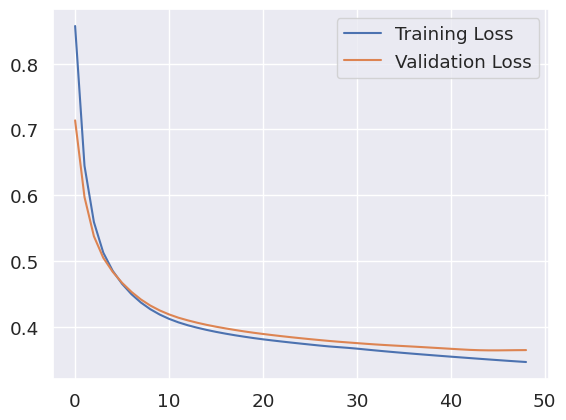

In [79]:
val_performance["LSTM"] = lstm_model.evaluate(w_lstm.val, verbose=1, return_dict=False)
loss["LSTM"] = history.history["loss"]
val_loss["LSTM"] = history.history["val_loss"]
pprint(val_performance)

# Plot the loss graph.
plt.plot(loss["LSTM"], label='Training Loss')
plt.plot(val_loss["LSTM"], label='Validation Loss')
plt.legend()
plt.savefig("/tf/figures/lstm_model_v4_200.pdf", facecolor='white')
plt.show()

We need to **predict the test** data to decide on the RMSE value.

In [119]:
# RMSE window size.
window_size = 45

# Predict test data.
test_pred = lstm_model.predict(w_lstm.test, batch_size=1024)
reshaped_test = test_pred.reshape(-1, 9)
rescaled_test = scaler_X.inverse_transform(reshaped_test)
original_shape_test_pred = rescaled_test.reshape(-1, WINDOW_SIZE, NUM_FEATURES)
test_data_np = test_data.to_numpy()
reshaped_test_data = np.empty((174856, 45, 9))

# Fill the reshaped_test_data with the appropriate windows from test_data_np
for i in range(174856):
    reshaped_test_data[i] = test_data_np[i:i+45]

# Calculate the squared differences between predictions and actual values
squared_differences = np.square(original_shape_test_pred - reshaped_test_data)

# Sum the squared differences across all timesteps and features within each window
sum_squared_differences = np.sum(squared_differences, axis=(1, 2))

# Take the square root of the sum to get the RMSE for each window
rmse_per_window = np.sqrt(sum_squared_differences)


def calculate_anomaly_rmse(anomaly_dataset, anomaly_window, scaler, model, window_size=45):
    # Predict anomaly data
    anomalous_preds = model.predict(anomaly_window, batch_size=1024)
    # Reshape and scale predictions back to original scale
    reshaped_preds = anomalous_preds.reshape(-1, 9)
    rescaled_preds = scaler.inverse_transform(reshaped_preds)
    rescaled_preds = rescaled_preds.reshape(-1, window_size, 9)

    # Prepare the actual data for comparison
    anomaly_data_np = anomaly_dataset.to_numpy()
    num_windows = rescaled_preds.shape[0]

    reshaped_anomaly_data = np.empty((num_windows, window_size, 9))
    for i in range(num_windows):
        reshaped_anomaly_data[i] = anomaly_data_np[i:i+window_size]

    # Calculate the squared differences between predictions and actual values
    squared_differences = np.square(rescaled_preds - reshaped_anomaly_data)

    # Sum the squared differences across all timesteps and features within each window
    sum_squared_differences = np.sum(squared_differences, axis=(1, 2))

    # Take the square root of the sum to get the RMSE for each window
    rmse_per_window = np.sqrt(sum_squared_differences)

    return rmse_per_window

# Now use this function for each anomaly type
rmse_per_window_ha = calculate_anomaly_rmse(df_hitting_arm, w_lstm.anol_hitting_arm, scaler_X, lstm_model)
rmse_per_window_hp = calculate_anomaly_rmse(df_hitting_platform, w_lstm.anol_hitting_platform, scaler_X, lstm_model)
rmse_per_window_eq = calculate_anomaly_rmse(df_earthquake, w_lstm.anol_earthquake, scaler_X, lstm_model)
rmse_per_window_ew = calculate_anomaly_rmse(df_extra_weight, w_lstm.anol_extra_weigth, scaler_X, lstm_model)
rmse_per_window_mf = calculate_anomaly_rmse(df_magnet, w_lstm.anol_magnetic_field, scaler_X, lstm_model)


# Predict nortmal data, when iteration is one.
# test_pred = lstm_model.predict(w_lstm.test, batch_size=1024)
# rescaled_test = scaler_X.inverse_transform(test_pred)
# reshaped_test = test_pred.reshape(-1, 9)
# rescaled_test = scaler_X.inverse_transform(reshaped_test)
# adjusted_test = test_data.to_numpy()[window_size:]
# rmse_per_row_test = np.sqrt(np.mean(np.square(rescaled_test - adjusted_test), axis=1))

# # Predict hitting arm.
# anomalous_preds_hitting_arm = lstm_model.predict(w_lstm.anol_hitting_arm, batch_size=1024)
# reshaped_ha = anomalous_preds_hitting_arm.reshape(-1, 9)
# rescaled_ha = scaler_X.inverse_transform(reshaped_ha)
# adjusted_ha = df_hitting_arm.to_numpy()[window_size:]
# rmse_per_row_ha = np.sqrt(np.mean(np.square(rescaled_ha - adjusted_ha), axis=1))

# # Predict hitting platform.
# anomalous_preds_hitting_platform = lstm_model.predict(w_lstm.anol_hitting_platform, batch_size=1024)
# reshaped_hp = anomalous_preds_hitting_platform.reshape(-1, 9)
# rescaled_hp = scaler_X.inverse_transform(reshaped_hp)
# adjusted_hp = df_hitting_platform.to_numpy()[window_size:]
# rmse_per_row_hp = np.sqrt(np.mean(np.square(rescaled_hp - adjusted_hp), axis=1))

# # Predict earthquake.
# anomalous_preds_earthquake = lstm_model.predict(w_lstm.anol_earthquake, batch_size=1024)
# reshaped_eq = anomalous_preds_earthquake.reshape(-1, 9)
# rescaled_eq = scaler_X.inverse_transform(reshaped_eq)
# adjusted_eq = df_earthquake.to_numpy()[window_size:]
# rmse_per_row_eq = np.sqrt(np.mean(np.square(rescaled_eq - adjusted_eq), axis=1))

# # Predict extra weight.
# anomalous_preds_extra_weigth = lstm_model.predict(w_lstm.anol_extra_weigth, batch_size=1024)
# reshaped_ew = anomalous_preds_extra_weigth.reshape(-1, 9)
# rescaled_ew = scaler_X.inverse_transform(reshaped_ew)
# adjusted_ew = df_extra_weight.to_numpy()[window_size:]
# rmse_per_row_ew = np.sqrt(np.mean(np.square(rescaled_ew - adjusted_ew), axis=1))

# # Predict magnetic field.
# anomalous_preds_magnetic_field = lstm_model.predict(w_lstm.anol_magnetic_field, batch_size=1024)
# reshaped_mf = anomalous_preds_magnetic_field.reshape(-1, 9)
# rescaled_mf = scaler_X.inverse_transform(reshaped_mf)
# adjusted_mf = df_magnet.to_numpy()[window_size:]
# rmse_per_row_mf = np.sqrt(np.mean(np.square(rescaled_mf - adjusted_mf), axis=1))

15/15 [==============================] - 0s 29ms/step


### Setting a same threshold for all.

In [19]:
rmse_slider_size = [45, 50, 100, 150, 200, 265]
final_metrics = {}

for size in rmse_slider_size:
    # Calculate RMSE sliding sums for each anomaly type
    rmse_sliding_sums_test = np.convolve(rmse_per_row_test, np.ones(size), 'valid')
    rmse_sliding_sums_ha = np.convolve(rmse_per_row_ha, np.ones(size), 'valid')
    rmse_sliding_sums_hp = np.convolve(rmse_per_row_hp, np.ones(size), 'valid')
    rmse_sliding_sums_eq = np.convolve(rmse_per_row_eq, np.ones(size), 'valid')
    rmse_sliding_sums_ew = np.convolve(rmse_per_row_ew, np.ones(size), 'valid')
    rmse_sliding_sums_mf = np.convolve(rmse_per_row_mf, np.ones(size), 'valid')

    # Concatenate RMSE arrays
    combined_rmse = np.concatenate((
        rmse_sliding_sums_test, 
        rmse_sliding_sums_ha,
        rmse_sliding_sums_hp, 
        rmse_sliding_sums_eq,
        rmse_sliding_sums_ew, 
        rmse_sliding_sums_mf
    ))

    # Create labels
    labels = np.concatenate((
        np.zeros(len(rmse_sliding_sums_test)), 
        np.ones(len(rmse_sliding_sums_ha)),
        np.ones(len(rmse_sliding_sums_hp)), 
        np.ones(len(rmse_sliding_sums_eq)),
        np.ones(len(rmse_sliding_sums_ew)), 
        np.ones(len(rmse_sliding_sums_mf))
    ))

    # Limits to find the threshold
    min_rmse = np.min(combined_rmse)
    max_rmse = np.max(combined_rmse)

    # Initialize variables for the best metrics
    best_metrics = {'F1': 0}
    best_predictions = None

    for threshold in np.linspace(min_rmse - (max_rmse - min_rmse) / 200, max_rmse + (max_rmse - min_rmse) / 200, 1000):
        predictions = (combined_rmse > threshold).astype(int)
        f1 = f1_score(labels, predictions)

        if f1 > best_metrics['F1']:
            tn, fp, fn, tp = confusion_matrix(labels, predictions).ravel()
            best_metrics = {
                'Threshold': threshold,
                'F1': f1,
                'Precision': precision_score(labels, predictions),
                'Recall': recall_score(labels, predictions),
                'Accuracy': accuracy_score(labels, predictions),
                'FPR': fp / (fp + tn) if (fp + tn) > 0 else 0
            }
            best_predictions = predictions

    # Store the best metrics for the current slider size
    final_metrics[size] = best_metrics

# Print final metrics for each slider size
for size, metrics in final_metrics.items():
    print(f"Metrics for slider size {size}:")
    for key, value in metrics.items():
        print(f"    {key}: {value}")
    print()

Metrics for slider size 45:
    Threshold: 101.07516973891518
    F1: 0.8971148049263629
    Precision: 0.9967465360177601
    Recall: 0.8155908421810892
    Accuracy: 0.9499568521326776
    FPR: 0.0009722285766573638

Metrics for slider size 50:
    Threshold: 108.67730061983254
    F1: 0.9113169525680321
    Precision: 0.9915796068026459
    Recall: 0.843074898563439
    Accuracy: 0.956117712121466
    FPR: 0.0026136539110442605

Metrics for slider size 100:
    Threshold: 219.0600782987094
    F1: 0.9267222465993857
    Precision: 0.9997633136094675
    Recall: 0.863627070128808
    Accuracy: 0.9635713806295725
    FPR: 7.437028392286086e-05

Metrics for slider size 150:
    Threshold: 283.27306430712235
    F1: 0.9800639959845657
    Precision: 0.9736345929100116
    Recall: 0.9865788767309301
    Accuracy: 0.9893230960501336
    FPR: 0.009682348026620735

Metrics for slider size 200:
    Threshold: 358.75184945917226
    F1: 0.9993734484919142
    Precision: 1.0
    Recall: 0.9987

### Setting a same threshold per pair.

In [20]:
rmse_slider_size = [45, 50, 100, 150, 200, 265]
anomaly_types = ["HA", "HP", "EQ", "EW", "MF"]  # Excluding "Non-Anomalous" as it's used in every pair

final_metrics = {}

for size in rmse_slider_size:
    # Calculate RMSE sliding sum for non-anomalous data
    rmse_sliding_sums_test = np.convolve(rmse_per_row_test, np.ones(size), 'valid')
    test_labels = np.zeros(len(rmse_sliding_sums_test))

    for anomaly_type in anomaly_types:
        # Calculate RMSE sliding sums for each anomaly type
        anomaly_rmse = {
            "HA": np.convolve(rmse_per_row_ha, np.ones(size), 'valid'),
            "HP": np.convolve(rmse_per_row_hp, np.ones(size), 'valid'),
            "EQ": np.convolve(rmse_per_row_eq, np.ones(size), 'valid'),
            "EW": np.convolve(rmse_per_row_ew, np.ones(size), 'valid'),
            "MF": np.convolve(rmse_per_row_mf, np.ones(size), 'valid')
        }[anomaly_type]

        # Concatenate RMSE arrays for non-anomalous and current anomaly
        combined_rmse = np.concatenate((rmse_sliding_sums_test, anomaly_rmse))

        # Create labels for non-anomalous and current anomaly
        labels = np.concatenate((test_labels, np.ones(len(anomaly_rmse))))

        # Initialize variables for the best metrics for the current size and anomaly type
        best_metrics = {'F1': 0}

        # Find the best threshold for the current size and anomaly type
        min_rmse = np.min(combined_rmse)
        max_rmse = np.max(combined_rmse)

        for threshold in np.linspace(min_rmse - (max_rmse - min_rmse) / 200, max_rmse + (max_rmse - min_rmse) / 200, 1000):
            predictions = (combined_rmse > threshold).astype(int)

            f1 = f1_score(labels, predictions, zero_division=0)

            if f1 > best_metrics['F1']:
                tn, fp, fn, tp = confusion_matrix(labels, predictions).ravel()
                best_metrics = {
                    'Threshold': threshold,
                    'F1': f1,
                    'Precision': precision_score(labels, predictions, zero_division=0),
                    'Recall': recall_score(labels, predictions, zero_division=0),
                    'Accuracy': accuracy_score(labels, predictions),
                    'FPR': fp / (fp + tn) if (fp + tn) > 0 else 0
                }

        # Store the best metrics for the current slider size and anomaly type
        final_metrics[(size, anomaly_type)] = best_metrics

# Print final metrics for each slider size and anomaly type
for (size, anomaly_type), metrics in final_metrics.items():
    print(f"Metrics for slider size {size} and anomaly type {anomaly_type}:")
    for key, value in metrics.items():
        print(f"    {key}: {value}")
    print()

Metrics for slider size 45 and anomaly type HA:
    Threshold: 98.96306441272442
    F1: 0.7488166132233929
    Precision: 0.9416282642089093
    Recall: 0.6215462610899873
    Accuracy: 0.9735659458677708
    FPR: 0.0026078601820926934

Metrics for slider size 45 and anomaly type HP:
    Threshold: 98.28327268758156
    F1: 0.8654452180285819
    Precision: 0.9514179825974863
    Recall: 0.7937222744992607
    Accuracy: 0.9806465894357363
    FPR: 0.003448551951319943

Metrics for slider size 45 and anomaly type EQ:
    Threshold: 102.28341176144366
    F1: 0.9916537867078826
    Precision: 0.9914348785871965
    Recall: 0.9918727915194346
    Accuracy: 0.9989848315572362
    FPR: 0.000554742187857437

Metrics for slider size 45 and anomaly type EW:
    Threshold: 99.6011076817971
    F1: 0.826070920491069
    Precision: 0.9579616277648784
    Recall: 0.7261022600963319
    Accuracy: 0.9822194212828302
    FPR: 0.0019673331198243127

Metrics for slider size 45 and anomaly type MF:
   

Convert to TinyML model.

In [19]:
run_model = tf.function(lambda x: lstm_model(x))
# This is important, let's fix the input size.
BATCH_SIZE = 1
STEPS = 45
INPUT_SIZE = 9
concrete_func = run_model.get_concrete_function(
    tf.TensorSpec([BATCH_SIZE, STEPS, INPUT_SIZE], lstm_model.inputs[0].dtype))

# model directory.
MODEL_DIR = "/tf/models/lstm"
lstm_model.save(MODEL_DIR, save_format="tf", signatures=concrete_func)

converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_DIR)
tflite_model = converter.convert()

# Specify the path for the TFLite model file
tflite_model_path = "/tf/models/lstm/lstm_model.tflite"

# Save the TFLite model to the file
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

print(f"Model saved to: {tflite_model_path}")

!xxd -i /tf/models/lstm/lstm_model.tflite > /tf/models/lstm/lstm.cc

INFO:tensorflow:Assets written to: /tf/models/lstm/assets


INFO:tensorflow:Assets written to: /tf/models/lstm/assets
2024-02-18 09:25:15.299992: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-02-18 09:25:15.300030: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-02-18 09:25:15.300208: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tf/models/lstm
2024-02-18 09:25:15.308946: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-02-18 09:25:15.308965: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tf/models/lstm
2024-02-18 09:25:15.339664: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-02-18 09:25:15.428967: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tf/models/lstm
2024-02-18 09:25:15.488407: I tensorflow/cc/saved_model/loader.cc:316] SavedModel loa

Model saved to: /tf/models/lstm/lstm_model.tflite


# Analysis of built-in Data

First we load the data and check how built-in data look like.

In [3]:
# Load the CSV file
file_path = "./datasets/right_arm.csv"  # Replace with your file's actual path if needed
data = pd.read_csv(file_path)

# Display the first few rows to understand the structure
print("Preview of the dataset:")
print(data.head())

# Check basic information about the dataset
print("\nDataset Information:")
print(data.info())

Preview of the dataset:
    Timestamp                             Actual Joint Positions  \
0  257258.126  [-1.5707390944110315, -1.5707948964885254, -1....   
1  257258.176  [-1.5707176367389124, -1.570843359033102, -1.5...   
2  257258.226  [-1.570730988179342, -1.5708185635008753, -1.5...   
3  257258.276  [-1.570660416279928, -1.5707827371409913, -1.5...   
4  257258.326  [-1.570700470601217, -1.570839067498678, -1.57...   

                            Actual Joint Velocities  \
0                    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]   
1                    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]   
2  [0.0, 0.0, 0.0, -0.010884314775466919, 0.0, 0.0]   
3   [0.0, 0.0, 0.0, -0.08753828704357147, 0.0, 0.0]   
4   [0.0, 0.0, 0.0, -0.14845426380634308, 0.0, 0.0]   

                               Actual Joint Currents  \
0  [0.18499481678009033, 1.1043120622634888, 1.38...   
1  [0.16534548997879028, 1.0664139986038208, 1.40...   
2  [0.1645040214061737, 1.0770467519760132, 1.354...   
3  [0.182183

We remove other data than joint velocities and anomaly state.

In [4]:
# Keep only the relevant columns
data_reduced = data[['Actual Joint Velocities', 'Anomaly State']]

# Debugging: Check the reduced dataset
print("Reduced dataset preview:")
print(data_reduced.head())
print("\nReduced dataset information:")
print(data_reduced.info())

Reduced dataset preview:
                            Actual Joint Velocities  Anomaly State
0                    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]              0
1                    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]              0
2  [0.0, 0.0, 0.0, -0.010884314775466919, 0.0, 0.0]              0
3   [0.0, 0.0, 0.0, -0.08753828704357147, 0.0, 0.0]              0
4   [0.0, 0.0, 0.0, -0.14845426380634308, 0.0, 0.0]              0

Reduced dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1762650 entries, 0 to 1762649
Data columns (total 2 columns):
 #   Column                   Dtype 
---  ------                   ----- 
 0   Actual Joint Velocities  object
 1   Anomaly State            int64 
dtypes: int64(1), object(1)
memory usage: 26.9+ MB
None


In [5]:
# Expand the "Actual Joint Velocities" into separate columns
joint_columns = [f'Joint_{i+1}' for i in range(6)]  # Create column names for 6 joints
data_split = data_reduced.copy()

# Convert "Actual Joint Velocities" to individual joint columns
data_split[joint_columns] = data_split['Actual Joint Velocities'].apply(
    lambda x: pd.Series(eval(x)) if isinstance(x, str) else pd.Series([None] * 6)
)

# Drop the original "Actual Joint Velocities" column
data_split = data_split.drop(columns=['Actual Joint Velocities'])

# Debugging: Check the first few rows of the split dataset
print("Split dataset preview:")
print(data_split.head())

# Debugging: Check the info of the split dataset
print("\nSplit dataset information:")
print(data_split.info())

Split dataset preview:
   Anomaly State  Joint_1  Joint_2  Joint_3   Joint_4  Joint_5  Joint_6
0              0      0.0      0.0      0.0  0.000000      0.0      0.0
1              0      0.0      0.0      0.0  0.000000      0.0      0.0
2              0      0.0      0.0      0.0 -0.010884      0.0      0.0
3              0      0.0      0.0      0.0 -0.087538      0.0      0.0
4              0      0.0      0.0      0.0 -0.148454      0.0      0.0

Split dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1762650 entries, 0 to 1762649
Data columns (total 7 columns):
 #   Column         Dtype  
---  ------         -----  
 0   Anomaly State  int64  
 1   Joint_1        float64
 2   Joint_2        float64
 3   Joint_3        float64
 4   Joint_4        float64
 5   Joint_5        float64
 6   Joint_6        float64
dtypes: float64(6), int64(1)
memory usage: 94.1 MB
None


In [6]:
# Find the first index where "Anomaly State" is 1
first_anomaly_index = data_split[data_split['Anomaly State'] == 1].index.min()

# Split into non-anomalous and anomalous datasets
non_anomalous_data = data_split.iloc[:first_anomaly_index]
anomalous_data = data_split.iloc[first_anomaly_index:]

# Debugging: Print the sizes of the subsets
print(f"First anomaly index: {first_anomaly_index}")
print(f"Non-anomalous data shape: {non_anomalous_data.shape}")
print(f"Anomalous data shape: {anomalous_data.shape}")

# Debugging: Preview the first few rows of each subset
print("\nNon-Anomalous Data Preview:")
print(non_anomalous_data.head())
print("\nAnomalous Data Preview:")
print(anomalous_data.head())

First anomaly index: 1080004
Non-anomalous data shape: (1080004, 7)
Anomalous data shape: (682646, 7)

Non-Anomalous Data Preview:
   Anomaly State  Joint_1  Joint_2  Joint_3   Joint_4  Joint_5  Joint_6
0              0      0.0      0.0      0.0  0.000000      0.0      0.0
1              0      0.0      0.0      0.0  0.000000      0.0      0.0
2              0      0.0      0.0      0.0 -0.010884      0.0      0.0
3              0      0.0      0.0      0.0 -0.087538      0.0      0.0
4              0      0.0      0.0      0.0 -0.148454      0.0      0.0

Anomalous Data Preview:
         Anomaly State  Joint_1  Joint_2  Joint_3  Joint_4  Joint_5  Joint_6
1080004              1      0.0      0.0     -0.0     -0.0     -0.0      0.0
1080005              1      0.0      0.0     -0.0     -0.0     -0.0      0.0
1080006              1      0.0      0.0     -0.0     -0.0     -0.0      0.0
1080007              1      0.0      0.0     -0.0     -0.0     -0.0      0.0
1080008              1     

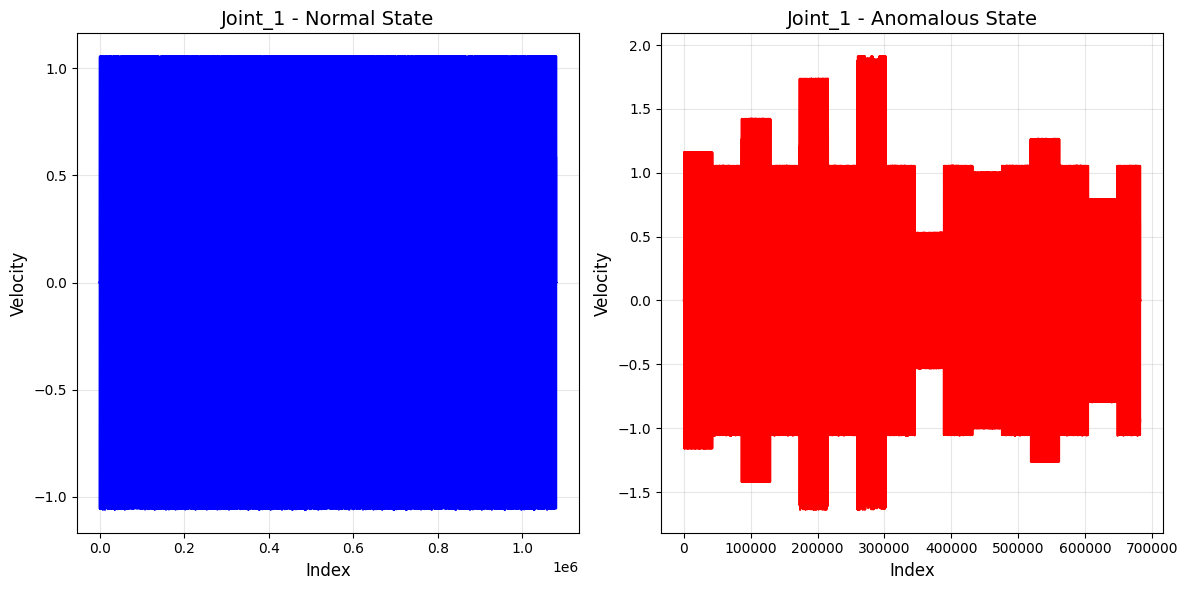

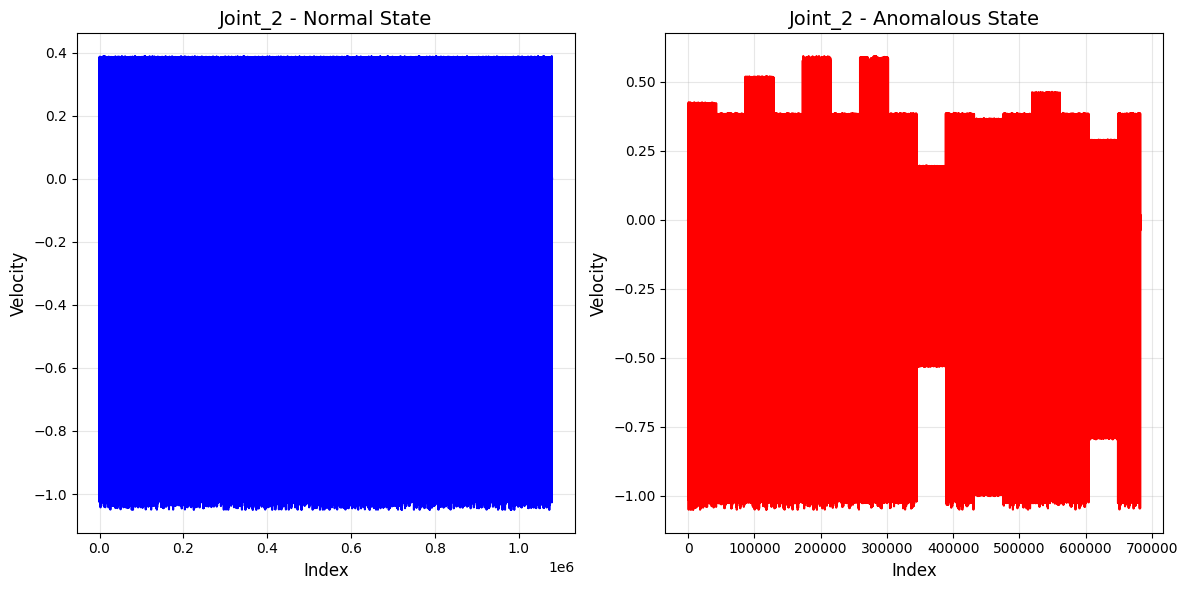

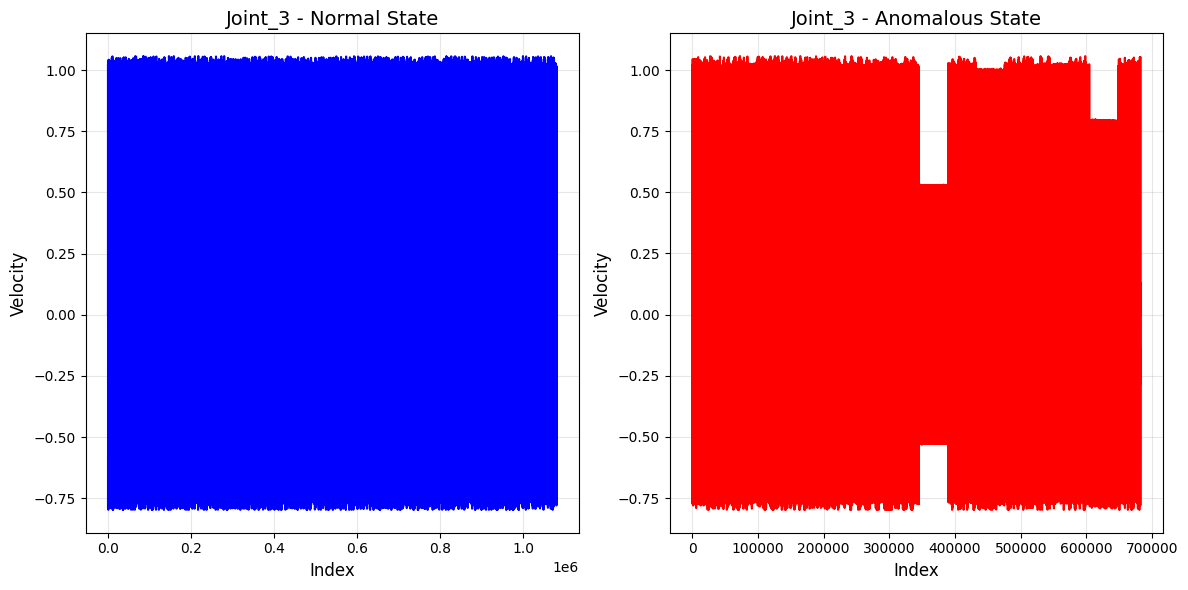

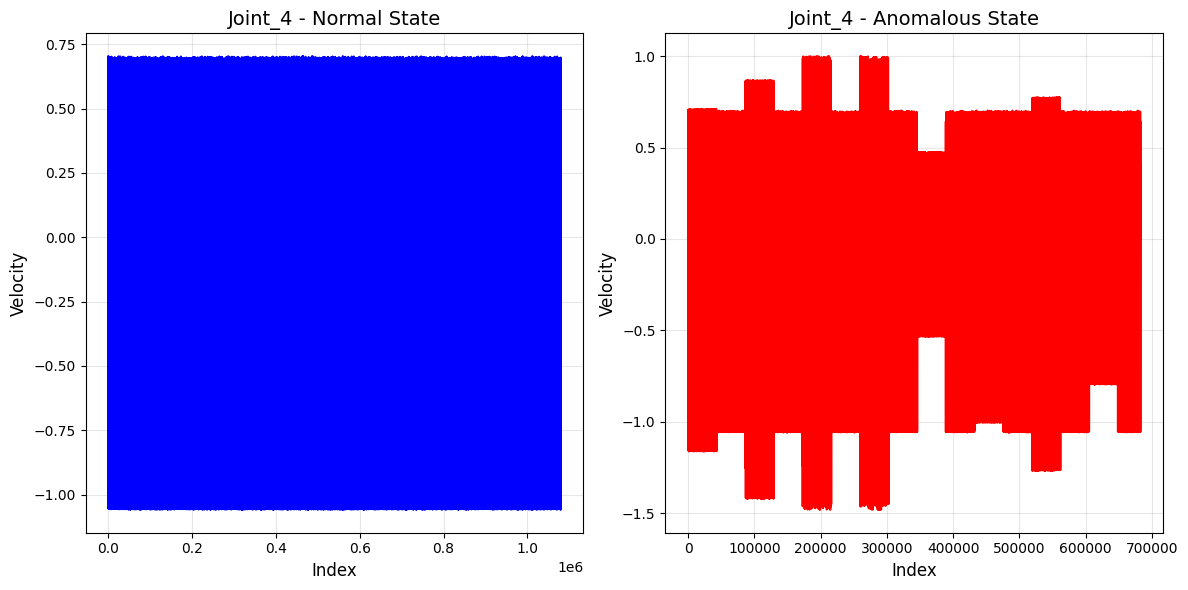

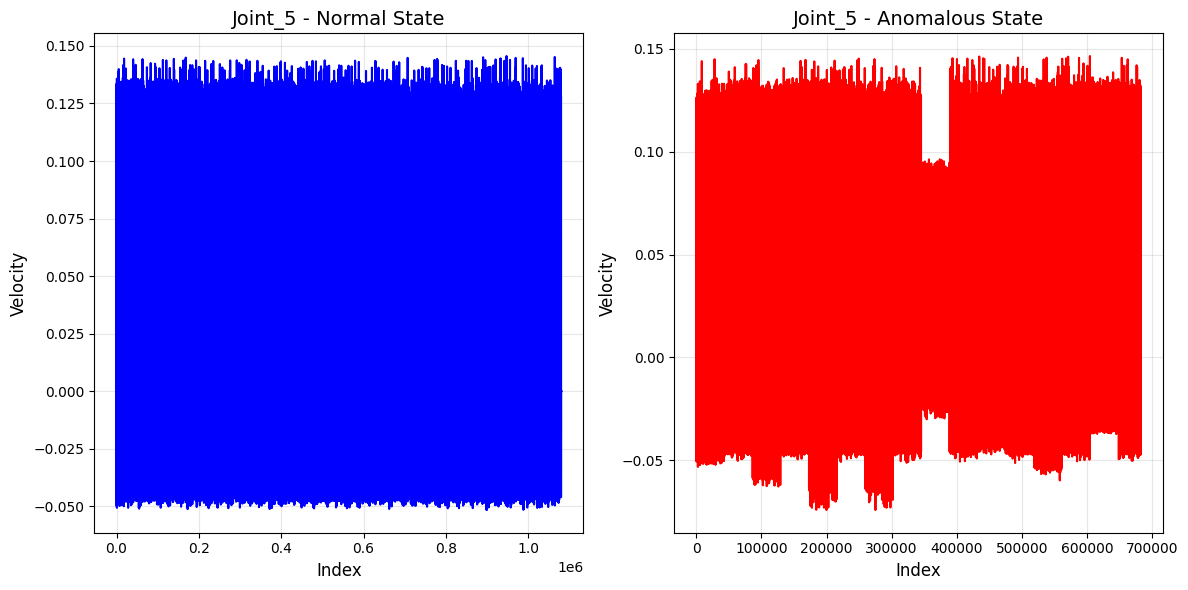

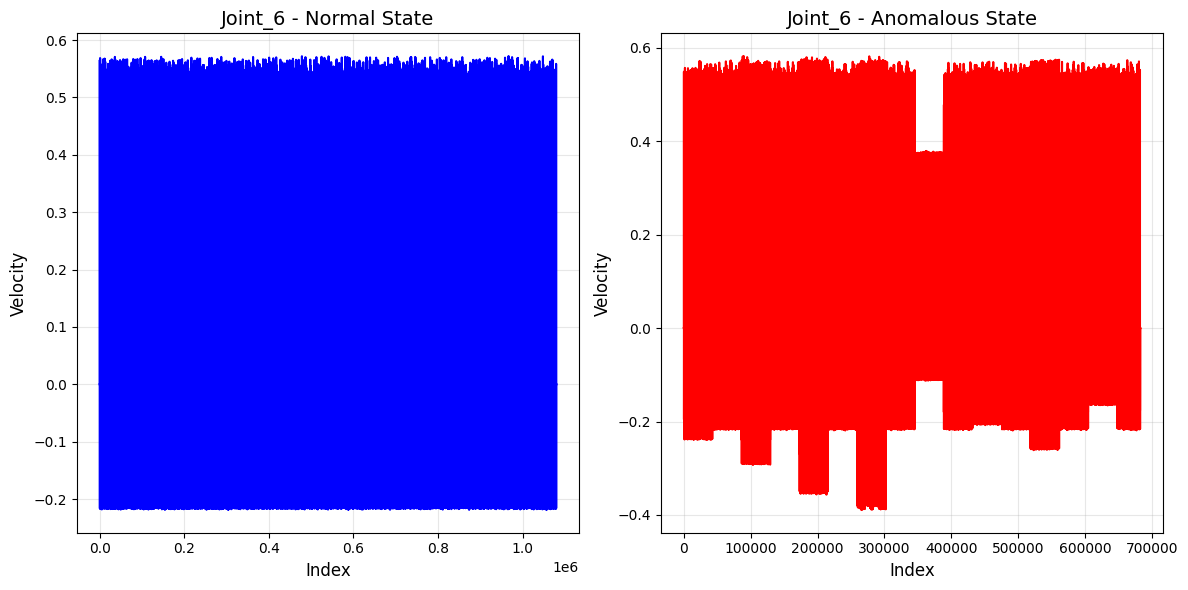

In [7]:
# List of joints to plot
joints = [f'Joint_{i+1}' for i in range(6)]

# Plot each joint's normal and anomalous data side by side
for joint in joints:
    plt.figure(figsize=(12, 6))

    # Plot normal data
    plt.subplot(1, 2, 1)
    plt.plot(non_anomalous_data[joint].values, color='blue')
    plt.title(f'{joint} - Normal State', fontsize=14)
    plt.xlabel('Index', fontsize=12)
    plt.ylabel('Velocity', fontsize=12)
    plt.grid(alpha=0.3)

    # Plot anomalous data
    plt.subplot(1, 2, 2)
    plt.plot(anomalous_data[joint].values, color='red')
    plt.title(f'{joint} - Anomalous State', fontsize=14)
    plt.xlabel('Index', fontsize=12)
    plt.ylabel('Velocity', fontsize=12)
    plt.grid(alpha=0.3)

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

In [9]:
max_lag = 765

# List of joint columns
joint_columns = ['Joint_1', 'Joint_2', 'Joint_3', 'Joint_4', 'Joint_5', 'Joint_6']

# Dictionary to store results
periodicity_results = {}

# Calculate periodicity for each joint
for joint in joint_columns:
    joint_data = non_anomalous_data[joint].values  # Extract joint data
    autocorrelations = [np.corrcoef(joint_data[:-lag], joint_data[lag:])[0, 1] if lag != 0 else 1.0 for lag in range(max_lag)]
    periodicity_lag = np.argmax(autocorrelations[1:]) + 1  # Find lag with highest autocorrelation
    periodicity_results[joint] = (periodicity_lag, autocorrelations[periodicity_lag])  # Store lag and value

# Debugging: Display periodicity results
for joint, result in periodicity_results.items():
    print(f"{joint}: Periodicity detected at lag {result[0]}, Autocorrelation value {result[1]}")

Joint_1: Periodicity detected at lag 760, Autocorrelation value 0.9999370292962388
Joint_2: Periodicity detected at lag 760, Autocorrelation value 0.9998381701060934
Joint_3: Periodicity detected at lag 760, Autocorrelation value 0.9997957304579954
Joint_4: Periodicity detected at lag 760, Autocorrelation value 0.9999075440149383
Joint_5: Periodicity detected at lag 760, Autocorrelation value 0.9970468896218941
Joint_6: Periodicity detected at lag 760, Autocorrelation value 0.9998181675545313


Since we know data greatly correlates with 760, we create sample windows.

In [10]:
# Define the window size and stride
window_size = 760
stride = 760

# Initialize a dictionary to store the windows for each joint
joint_windows = {}
joint_windows_anomalous = {}

# Create windows for each joint
for joint in joint_columns:
    joint_data = non_anomalous_data[joint].values  # Extract joint data
    num_windows = len(joint_data) // stride  # Calculate the number of complete windows
    joint_windows[joint] = [joint_data[i:i + window_size] for i in range(0, num_windows * stride, stride)]
    
    # Debugging: Verify the shape and content of windows for the current joint
    print(f"{joint}: Number of windows created = {len(joint_windows[joint])}")

# Create anomalous windows for each joint
for joint in joint_columns:
    joint_data_anomalous = anomalous_data[joint].values  # Extract joint data from anomalous dataset
    num_windows_anomalous = len(joint_data_anomalous) // stride  # Calculate the number of complete windows
    joint_windows_anomalous[joint] = [
        joint_data_anomalous[i:i + window_size] for i in range(0, num_windows_anomalous * stride, stride)
    ]

    # Debugging: Verify the shape and content of windows for the current joint in anomalous data
    print(f"{joint} (Anomalous): Number of windows created = {len(joint_windows_anomalous[joint])}")

Joint_1: Number of windows created = 1421
Joint_2: Number of windows created = 1421
Joint_3: Number of windows created = 1421
Joint_4: Number of windows created = 1421
Joint_5: Number of windows created = 1421
Joint_6: Number of windows created = 1421
Joint_1 (Anomalous): Number of windows created = 898
Joint_2 (Anomalous): Number of windows created = 898
Joint_3 (Anomalous): Number of windows created = 898
Joint_4 (Anomalous): Number of windows created = 898
Joint_5 (Anomalous): Number of windows created = 898
Joint_6 (Anomalous): Number of windows created = 898


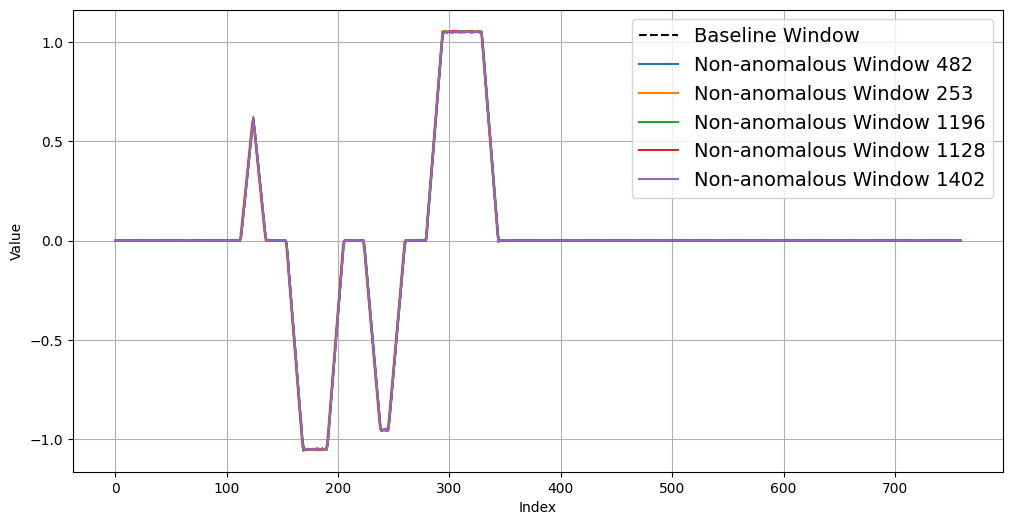

In [114]:
# Extract the joint windows
joint_1_windows = joint_windows['Joint_1']
joint_2_windows = joint_windows['Joint_2']
joint_3_windows = joint_windows['Joint_3']
joint_4_windows = joint_windows['Joint_4']
joint_5_windows = joint_windows['Joint_5']
joint_6_windows = joint_windows['Joint_6']

# Extract the joint windows for anomalous data
joint_1_windows_anomalous = joint_windows_anomalous['Joint_1']
joint_2_windows_anomalous = joint_windows_anomalous['Joint_2']
joint_3_windows_anomalous = joint_windows_anomalous['Joint_3']
joint_4_windows_anomalous = joint_windows_anomalous['Joint_4']
joint_5_windows_anomalous = joint_windows_anomalous['Joint_5']
joint_6_windows_anomalous = joint_windows_anomalous['Joint_6']

# Define the cross-correlation function to calculate the lag
def calculate_shift(reference, target):
    correlation = np.correlate(target, reference, mode="full")
    shift = np.argmax(correlation) - (len(reference) - 1)
    return shift

# Use the first window as the baseline
baseline_window = joint_1_windows[0]

# Calculate the lag for all windows
lags = []
for idx in range(1, len(joint_1_windows)):  # Process all windows except the baseline
    current_window = joint_1_windows[idx]
    lag = calculate_shift(baseline_window, current_window)
    lags.append(lag)
    # print(f"Lag between baseline and window {idx}: {lag}")

# Adjust all windows based on the lag
adjusted_windows = []

for idx, (window, lag) in enumerate(zip(joint_1_windows[1:], lags)):
    # Shift window to the left and pad with zeros on the right
    adjusted_window = np.concatenate((window[lag:], np.zeros(lag)))
    adjusted_windows.append(adjusted_window)

# Include the baseline in the adjusted windows for plotting
adjusted_windows.insert(0, baseline_window)

# Number of random windows to plot
num_random_windows = 5  # Adjust this as needed

# Randomly select indices for plotting (excluding the baseline, which is always plotted)
random_indices = np.random.choice(range(1, len(adjusted_windows)), size=num_random_windows, replace=False)


# Plot the baseline and random adjusted windows
plt.figure(figsize=(12, 6))

# Plot the baseline window
plt.plot(adjusted_windows[0], label="Baseline Window", color="black", linestyle="--")

# Plot the randomly selected adjusted windows
for idx in random_indices:
    plt.plot(adjusted_windows[idx], label=f"Non-anomalous Window {idx}")

# Add plot details
# plt.title("Alignment of Randomly Selected Adjusted Windows with Baseline")
plt.xlabel("Index")
plt.ylabel("Value")
plt.legend(fontsize=14, loc='upper right')
plt.grid()
# Save the plot as a PDF
plt.savefig("aligned_windows_plot.pdf", format="pdf", bbox_inches="tight")
plt.show()

Number of windows: 898
Shape of each window: (760,)
Labels for windows: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

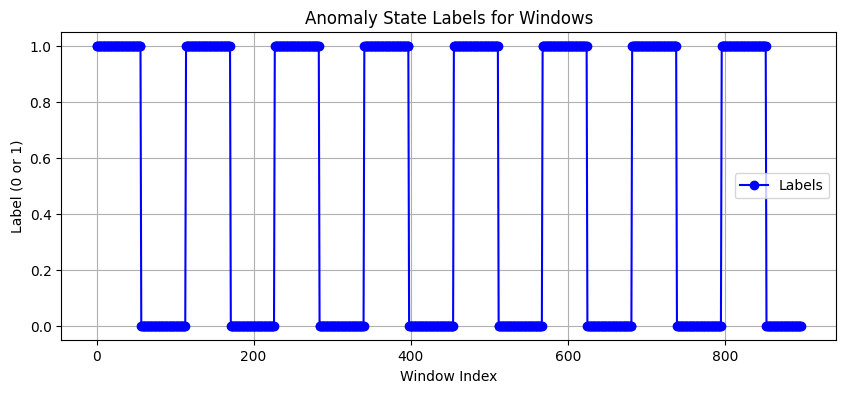

In [97]:
# Extract the 'Anomaly State' feature
anomaly_state = anomalous_data["Anomaly State"].values

# Create sliding windows of size 760
window_size = 760
step_size = 760
anomaly_state_windows = []

for start_idx in range(0, len(anomaly_state) - window_size + 1, step_size):
    window = anomaly_state[start_idx:start_idx + window_size]
    anomaly_state_windows.append(window)

# Convert windows to a NumPy array for easier handling
anomaly_state_windows = np.array(anomaly_state_windows)

# Determine labels for each window based on majority class
anomaly_state_labels = []
for window in anomaly_state_windows:
    label = 1 if np.sum(window) > window_size / 2 else 0
    anomaly_state_labels.append(label)

# Debugging: Print the results
print(f"Number of windows: {len(anomaly_state_windows)}")
print(f"Shape of each window: {anomaly_state_windows[0].shape}")
print(f"Labels for windows: {anomaly_state_labels}")

# Plot the labels as a line graph
plt.figure(figsize=(10, 4))

# Create the line plot
plt.plot(anomaly_state_labels, marker='o', linestyle='-', color='blue', label="Labels")

# Add plot details
plt.title("Anomaly State Labels for Windows")
plt.xlabel("Window Index")
plt.ylabel("Label (0 or 1)")
plt.grid()
plt.legend()

# Show the plot
plt.show()

In [100]:
# Split windows based on anomaly_state_labels
anomalous_windows = []
normal_windows = []

for window, label in zip(joint_1_windows_anomalous, anomaly_state_labels):
    if label == 1:
        anomalous_windows.append(window)
    else:
        normal_windows.append(window)

# Debugging: Check the sizes of the groups
print(f"Total windows: {len(joint_1_windows_anomalous)}")
print(f"Anomalous windows: {len(anomalous_windows)}")
print(f"Normal windows: {len(normal_windows)}")

Total windows: 898
Anomalous windows: 456
Normal windows: 442


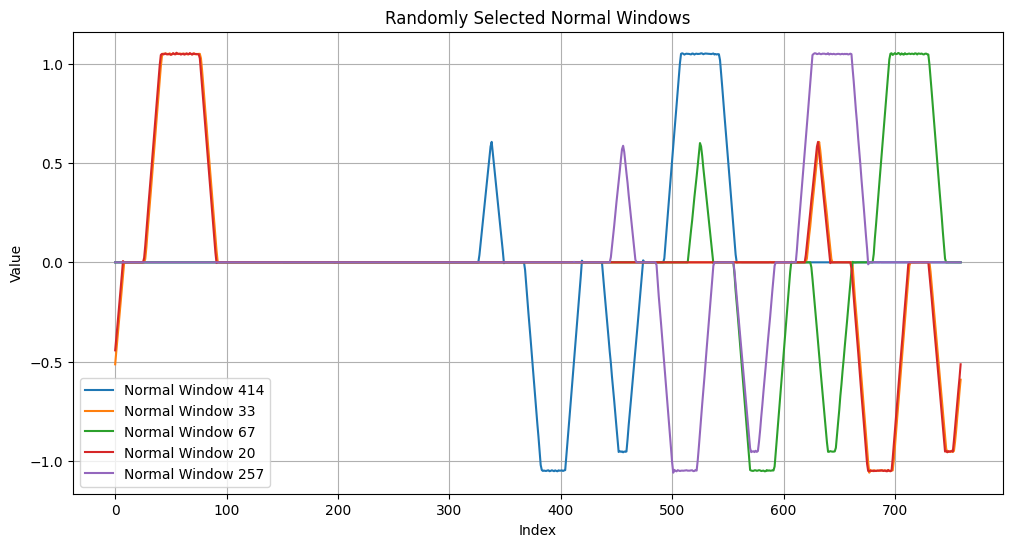

In [103]:
# Randomly select 5 normal windows
num_random_windows = 5
random_indices = random.sample(range(len(normal_windows)), min(num_random_windows, len(normal_windows)))

# Plot the selected normal windows
plt.figure(figsize=(12, 6))
for idx in random_indices:
    plt.plot(normal_windows[idx], label=f"Normal Window {idx}")

# Add plot details
plt.title("Randomly Selected Normal Windows")
plt.xlabel("Index")
plt.ylabel("Value")
plt.legend()
plt.grid()
plt.show()

Total adjusted normal windows: 442
Shape of one adjusted window: (760,)


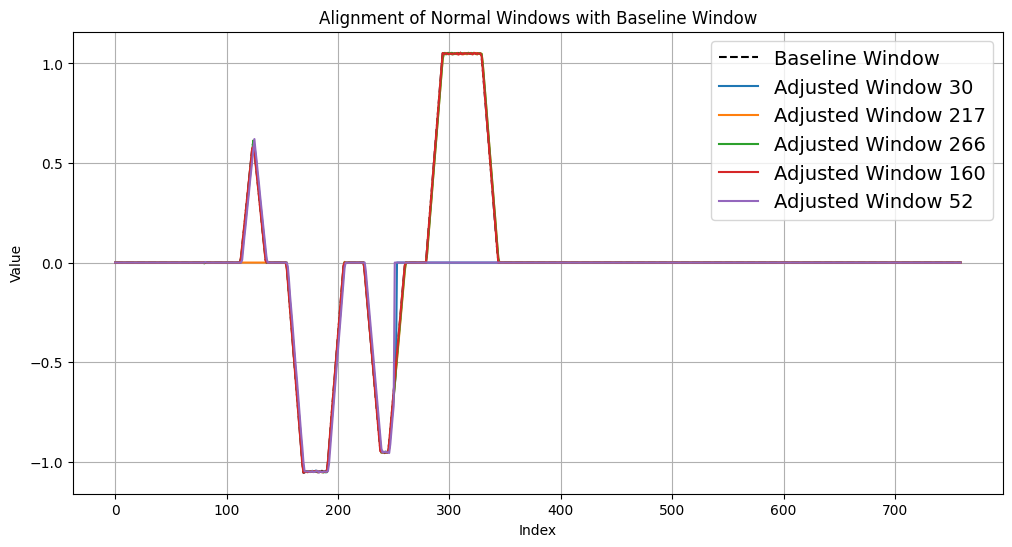

In [116]:
# Use the first window from joint_1_windows as the baseline
baseline_window = joint_1_windows[0]

# Define the cross-correlation function to calculate the lag
def calculate_shift(reference, target):
    correlation = np.correlate(target, reference, mode="full")
    shift = np.argmax(correlation) - (len(reference) - 1)
    return shift

# Calculate lags for all normal windows relative to the baseline window
lags_normal = []
for idx, current_window in enumerate(normal_windows):  # Include all normal windows
    lag = calculate_shift(baseline_window, current_window)
    lags_normal.append(lag)

# Adjust normal windows based on the calculated lags
adjusted_normal_windows = []

for idx, (window, lag) in enumerate(zip(normal_windows, lags_normal)):
    if lag > 0:
        # Shift window to the left and pad with zeros on the right
        adjusted_window = np.concatenate((window[lag:], np.zeros(lag)))
    elif lag < 0:
        # Shift window to the right and pad with zeros on the left
        adjusted_window = np.concatenate((np.zeros(-lag), window[:lag]))
    else:
        # No shift needed
        adjusted_window = window
    adjusted_normal_windows.append(adjusted_window)

# Debugging: Check the size of adjusted windows
print(f"Total adjusted normal windows: {len(adjusted_normal_windows)}")
print(f"Shape of one adjusted window: {adjusted_normal_windows[0].shape}")

# Plot the baseline and a few adjusted normal windows
plt.figure(figsize=(12, 6))

# Plot the baseline window
plt.plot(baseline_window, label="Baseline Window", color="black", linestyle="--")

# Plot a few adjusted windows
num_random_windows = 5  # Adjust this as needed
random_indices = np.random.choice(range(len(adjusted_normal_windows)), size=num_random_windows, replace=False)

for idx in random_indices:
    plt.plot(adjusted_normal_windows[idx], label=f"Adjusted Window {idx}")

# Add plot details
plt.title("Alignment of Normal Windows with Baseline Window")
plt.xlabel("Index")
plt.ylabel("Value")
plt.legend(fontsize=14, loc='upper right') 
plt.grid()
# Save the plot as a PDF
plt.savefig("aligned_windows_plot_test.pdf", format="pdf", bbox_inches="tight")
plt.show()

Total adjusted anomalous windows: 456
Shape of one adjusted window: (760,)


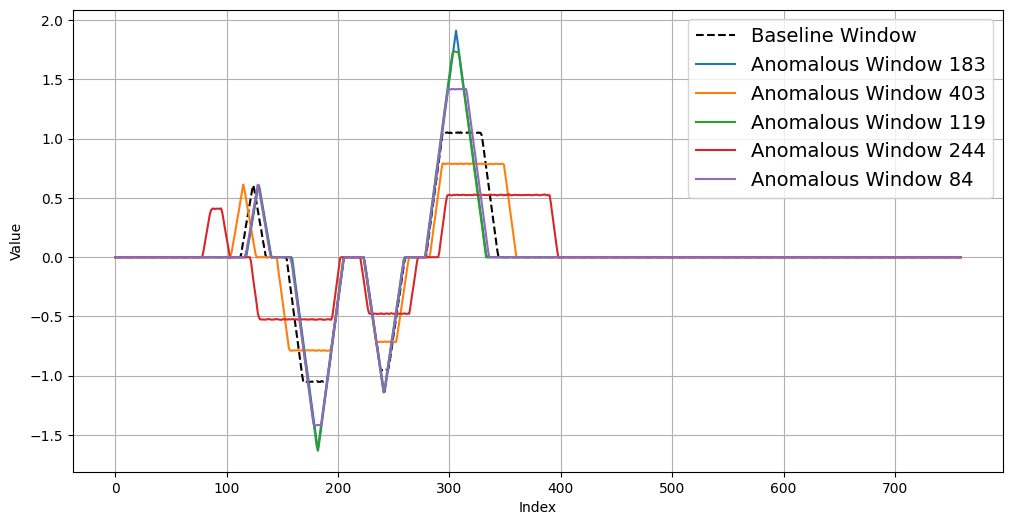

In [118]:
# Calculate lags for all anomalous windows relative to the baseline window
lags_anomalous = []
for idx, current_window in enumerate(anomalous_windows):  # Include all anomalous windows
    lag = calculate_shift(baseline_window, current_window)
    lags_anomalous.append(lag)

# Adjust anomalous windows based on the calculated lags
adjusted_anomalous_windows = []

for idx, (window, lag) in enumerate(zip(anomalous_windows, lags_anomalous)):
    if lag > 0:
        # Shift window to the left and pad with zeros on the right
        adjusted_window = np.concatenate((window[lag:], np.zeros(lag)))
    elif lag < 0:
        # Shift window to the right and pad with zeros on the left
        adjusted_window = np.concatenate((np.zeros(-lag), window[:lag]))
    else:
        # No shift needed
        adjusted_window = window
    adjusted_anomalous_windows.append(adjusted_window)

# Debugging: Check the size of adjusted windows
print(f"Total adjusted anomalous windows: {len(adjusted_anomalous_windows)}")
print(f"Shape of one adjusted window: {adjusted_anomalous_windows[0].shape}")

# Plot the baseline and a few adjusted anomalous windows
plt.figure(figsize=(12, 6))

# Plot the baseline window
plt.plot(baseline_window, label="Baseline Window", color="black", linestyle="--")

# Plot a few adjusted windows
num_random_windows = 5  # Adjust this as needed
random_indices = np.random.choice(range(len(adjusted_anomalous_windows)), size=num_random_windows, replace=False)

for idx in random_indices:
    plt.plot(adjusted_anomalous_windows[idx], label=f"Anomalous Window {idx}")

# Add plot details
# plt.title("Alignment of Anomalous Windows with Baseline Window")
plt.xlabel("Index")
plt.ylabel("Value")
# Customize legend to make it bigger
plt.legend(fontsize=14, loc='upper right')  # Increase font size and adjust location
plt.grid()
# Save the plot as a PDF
plt.savefig("aligned_windows_plot_anol.pdf", format="pdf", bbox_inches="tight")
plt.show()

## Peak-difference-based detection for built-in data.

In [119]:
# Function to calculate the difference between positive and negative peaks
def calculate_peak_difference(window):
    positive_peak = np.max(window)  # Maximum value in the window
    negative_peak = np.min(window)  # Minimum value in the window
    peak_difference = positive_peak - negative_peak
    return peak_difference

# Arrays to store peak differences
normal_peak_differences = []
anomalous_peak_differences = []

# Calculate peak differences for normal windows
for window in normal_windows:
    peak_diff = calculate_peak_difference(window)
    normal_peak_differences.append(peak_diff)

# Calculate peak differences for anomalous windows
for window in anomalous_windows:
    peak_diff = calculate_peak_difference(window)
    anomalous_peak_differences.append(peak_diff)

# Debugging: Check the calculated peak differences
print(f"Normal Peak Differences: {normal_peak_differences[:5]}")  # Print first 5 for verification
print(f"Anomalous Peak Differences: {anomalous_peak_differences[:5]}")  # Print first 5 for verification

Normal Peak Differences: [2.1112221479415894, 2.111487627029419, 2.11136531829834, 2.1107115745544434, 2.1094980239868164]
Anomalous Peak Differences: [2.3175528049468994, 2.3198307752609253, 2.3168883323669434, 2.315418004989624, 2.316137909889221]


In [120]:
# Debugging: Check the calculated peak differences
print(f"Normal Peak Differences (First 5): {normal_peak_differences[:5]}")
print(f"Anomalous Peak Differences (First 5): {anomalous_peak_differences[:5]}")

# Find maximum and minimum peak differences for normal windows
normal_max_peak_diff = np.max(normal_peak_differences)
normal_min_peak_diff = np.min(normal_peak_differences)

# Find maximum and minimum peak differences for anomalous windows
anomalous_max_peak_diff = np.max(anomalous_peak_differences)
anomalous_min_peak_diff = np.min(anomalous_peak_differences)

# Print maximum and minimum values
print(f"Normal Peak Differences -> Max: {normal_max_peak_diff}, Min: {normal_min_peak_diff}")
print(f"Anomalous Peak Differences -> Max: {anomalous_max_peak_diff}, Min: {anomalous_min_peak_diff}")

Normal Peak Differences (First 5): [2.1112221479415894, 2.111487627029419, 2.11136531829834, 2.1107115745544434, 2.1094980239868164]
Anomalous Peak Differences (First 5): [2.3175528049468994, 2.3198307752609253, 2.3168883323669434, 2.315418004989624, 2.316137909889221]
Normal Peak Differences -> Max: 2.4767682552337646, Min: 2.053109288215637
Anomalous Peak Differences -> Max: 3.5528935194015503, Min: 0.9434943199157715


We can spot two fault windows, which can be removed.

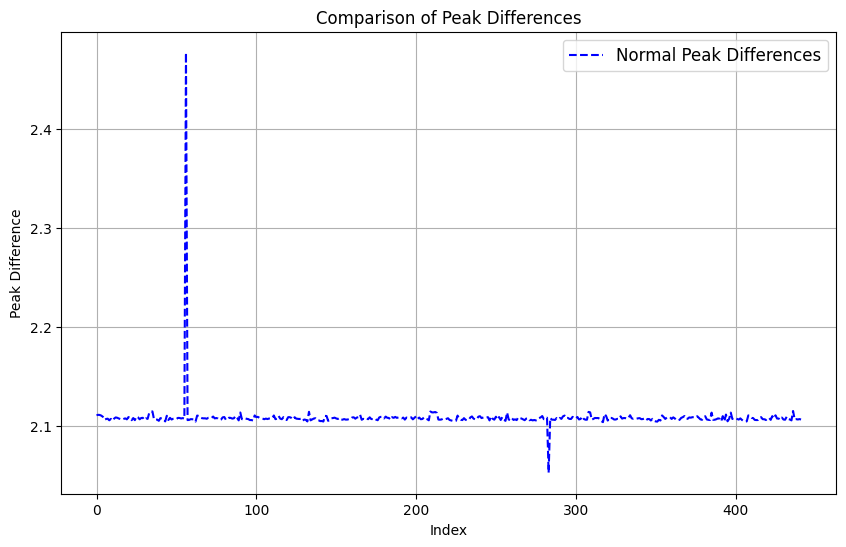

In [124]:
# Plot line graphs for peak differences
plt.figure(figsize=(10, 6))
plt.plot(normal_peak_differences, label="Normal Peak Differences", linestyle="--", color="blue")
# plt.plot(anomalous_peak_differences, label="Anomalous Peak Differences", linestyle="-", color="red")
plt.xlabel("Index")
plt.ylabel("Peak Difference")
plt.title("Comparison of Peak Differences")
plt.legend(fontsize=12)
plt.grid()
plt.show()

Original Normal Peak Differences: 442 values
Filtered Normal Peak Differences: 422 values


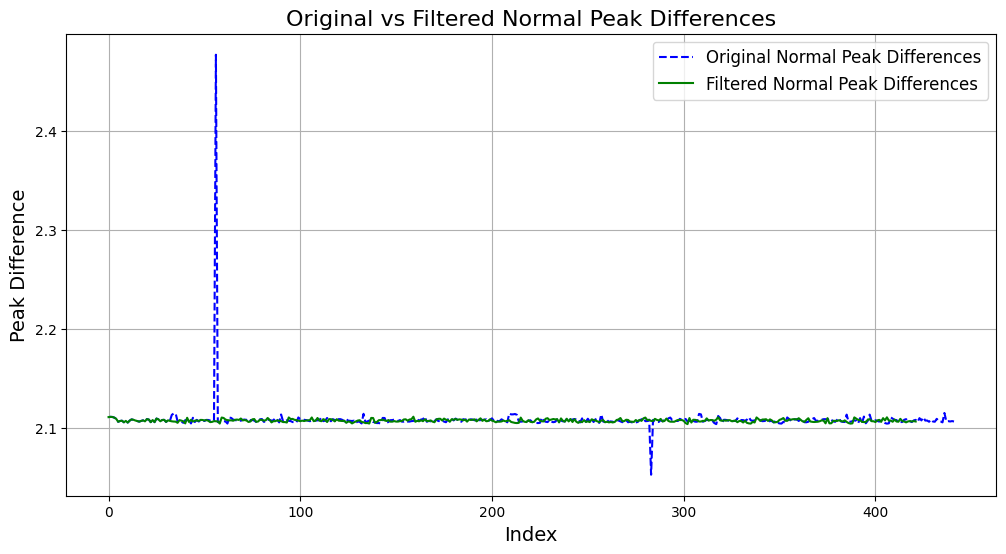

In [126]:
# Function to remove outliers using the IQR method
def remove_outliers(data):
    q1 = np.percentile(data, 25)  # First quartile (25th percentile)
    q3 = np.percentile(data, 75)  # Third quartile (75th percentile)
    iqr = q3 - q1                 # Interquartile range
    lower_bound = q1 - 1.5 * iqr  # Lower bound
    upper_bound = q3 + 1.5 * iqr  # Upper bound
    return [x for x in data if lower_bound <= x <= upper_bound]

# Remove outliers from normal_peak_differences
filtered_normal_peak_differences = remove_outliers(normal_peak_differences)

# Debugging: Compare original and filtered arrays
print(f"Original Normal Peak Differences: {len(normal_peak_differences)} values")
print(f"Filtered Normal Peak Differences: {len(filtered_normal_peak_differences)} values")

# Plot the original and filtered peak differences
plt.figure(figsize=(12, 6))

# Plot original normal peak differences
plt.plot(normal_peak_differences, label="Original Normal Peak Differences", linestyle="--", color="blue")

# Plot filtered normal peak differences
plt.plot(
    range(len(filtered_normal_peak_differences)),  # Adjust the index range for filtered data
    filtered_normal_peak_differences,
    label="Filtered Normal Peak Differences",
    linestyle="-",
    color="green"
)

# Add labels and title
plt.xlabel("Index", fontsize=14)
plt.ylabel("Peak Difference", fontsize=14)
plt.title("Original vs Filtered Normal Peak Differences", fontsize=16)

# Add legend and grid
plt.legend(fontsize=12, loc="upper right")
plt.grid()

# Show the plot
plt.show()

In [131]:
# Find the maximum and minimum values of the filtered normal peak differences
filtered_normal_max = np.max(filtered_normal_peak_differences)
filtered_normal_min = np.min(filtered_normal_peak_differences)

# Debugging: Print the maximum and minimum values
print(f"Filtered Normal Peak Differences -> Max: {filtered_normal_max}, Min: {filtered_normal_min}")

# Define the range of filtered normal peak differences
filtered_normal_range = (filtered_normal_min, filtered_normal_max)

# Find anomalous values within the filtered normal range along with their indices
anomalous_in_filtered_normal_range = [
    (idx, value) for idx, value in enumerate(anomalous_peak_differences)
    if filtered_normal_range[0] <= value <= filtered_normal_range[1]
]

# Debugging: Print the results
print(f"Filtered Normal Range: Min = {filtered_normal_range[0]}, Max = {filtered_normal_range[1]}")
print(f"Anomalous Values Within Filtered Normal Range: {anomalous_in_filtered_normal_range}")
print(f"Count of Anomalous Values in Filtered Normal Range: {len(anomalous_in_filtered_normal_range)}")

Filtered Normal Peak Differences -> Max: 2.111615538597107, Min: 2.1041316986083984
Filtered Normal Range: Min = 2.1041316986083984, Max = 2.111615538597107
Anomalous Values Within Filtered Normal Range: [(113, 2.1065514087677), (284, 2.1064342260360718)]
Count of Anomalous Values in Filtered Normal Range: 2
